# Explication du projet

La société Prêt à Dépenser est une société financière  qui propose des crédits à la consommation. Dans une logique de gestion du risque, l’entreprise souhaite mettre en place un outil de scoring de crédits capable d’estimer la probabilité qu’un client rembourse son emprunt. Cet outil permettra de classer automatiquement les demandes en deux catégories : les demandes de prêts peu risquées qui seront acceptées ou les demandes de prêts risquées qui seront refusées. Pour développer ce modèle de classification, la société a fourni un large pannel de données provenant de différentes sources et inclus des informations sociodemographiques et des données issues d'autres institutions financières.

Le projet visant à mettre en place cet outil de classification se décomposera en différentes étapes. Dans un premier temps, les différentes tables de données fournies par la société Prêt à dépenser seront explorées de manière à comprendre les données, a évaluer leur qualité et à identifier les variables pertinentes pour l'objectif du projet. Dans l'étape suivante, la table correspondant aux demandes de prêts sera enrichie via une jointure des variables identifiées précedemment et de nouvelles variables construites pour apporter des informations supplémentaires. La qualité de cette table enrichie sera évaluée dans la troisième étape. La quatrième étape permettra d'analyser la table enrichie pour identifier des premières tendances de relations entres les variables explicatives et entre les variables explicatives et la variable cible. Ensuite dans la cinquième étape, différents modèles de classification seront explorés et évalués. Dans la dernière étape, le modèle final retenu sera analysé plus en profondeur pour identifier les variables qui auront le plus implacté les résultats de prédiction du modèle.

# Sommaire
- [1 Explication du projet](#Explication-du-projet)
- [2 Sommaire](#Sommaire)
- [3 Import](#Import-des-bibliothèques-et-des-données)
- [4 Exploration des tables de données](#Exploration-des-tables-de-données)
- [5 Enrichissement de la table principale](#Enrichissement-de-la-table-principale)
- [6 Analyse de la table](#Analyse-de-la-table)
- [7 Sauvegarde des tables finales](#Sauvegarde-des-tables-finales)
- [8 Conclusions](#Conclusions)


# Import des bibliothèques et des données

**Librairies**

In [1]:
# Manipulation et analyse de données
import pandas as pd
import numpy as np
import missingno as msno
import math
from pandas.api.types import is_numeric_dtype, is_object_dtype

# Représentation graphique
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Librairies sickit learn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# Librairie de gestion de l'affichage
from IPython.display import Image, display

# Utils
from datetime import datetime

**Données**

In [2]:
# Chargement des différents jeux de données
Application_test = pd.read_csv("../Data/application_test.csv", index_col=0)
Application_train = pd.read_csv("../Data/application_train.csv", index_col=0)
Data_bureau = pd.read_csv("../Data/bureau.csv", index_col=0)
Data_bureau_bal = pd.read_csv("../Data/bureau_balance.csv", index_col=0)
Data_credit_bal = pd.read_csv("../Data/credit_card_balance.csv", index_col=0, encoding='ascii')
Home_credit_desc = pd.read_csv("../Data/HomeCredit_columns_description.csv", index_col=0, encoding='Windows-1252')
Data_intallment_pymnts = pd.read_csv("../Data/installments_payments.csv", index_col=0)
Data_POS_CASH_bal = pd.read_csv("../Data/POS_CASH_balance.csv", index_col=0)
Data_prev_app = pd.read_csv("../Data/previous_application.csv", index_col=0)
Data_sample_subm = pd.read_csv("../Data/sample_submission.csv", index_col=0)

# Exploration des tables de données

L'exploration des différentes tables fera intervenir différentes fonctions qui seront définies dans la section suivante.
- La première fonction permettra d'analyser le taux de valeurs manquantes pour l'ensemble des variables afin d'identifier les variables potentiellement problématiques.
- La deuxième fonction permettra de visualiser la distribution du taux de valeur manquante précédemment calculé.
- La troisième fonction permettra de nettoyer la table principale en supprimant les variables dont le taux de valeurs manquantes est supérieur à un seuil fixé, en traitant les valeurs abberantes parmis d'autres actions. Pour que cette étape puisse être intégrée dans un pipeline sickit learn, la fonction sera encapsulée dans une classe héritant des structure spécifiques à sickit learn suivantes: BaseEstimator et TransformerMixin
- La quatrième fonction permettra de visualiser les distributions des variables numériques sous la forme de boxplot afin de détecter d'éventuelles valeurs extrêmes ou anomalies.

## Fonctions communes

In [3]:
def missing_values_table(df):
    
    """
    Génère un tableau récapitulatif des valeurs manquantes détéctées dans une dataframe.

    Cette fonction calcule, pour chaque variable de la dataframe:
      - le nombre de valeurs manquantes
      - le pourcentage de valeurs manquantes par rapport au nombre total de lignes

    Le résultat est présenté dans un tableau trié par ordre décroissant 
    du pourcentage de valeurs manquantes (les colonnes sans valeurs manquantes 
    ne sont pas affichées).

    Paramètres
        df (pandas.DataFrame): La table de données à analyser.

    Sortie
        pandas.DataFrame: Un tableau contenant deux colonnes :
            - Missing Values: nombre de valeurs manquantes
            - % of Total Values: pourcentage de valeurs manquantes
    """
        
    # Calcul du nombre de valeurs manquantes par variable
    mis_val = df.isnull().sum()
        
    # Calcul du pourcentage de valeur manquante par variable
    mis_val_percent = 100 * df.isnull().mean()
        
    # Création d'une table contenant les résultats
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Attribution d'un nouveau nom aux colonnes
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Tri de la table par pourcentage décroissant
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
    # Affichage d'un résumé des informations 
    print ("La dataframe contient " + str(df.shape[1]) + " colonnes.\n"      
           "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
           " colonnes qui possèdent des valeurs manquantes.")
            
    return mis_val_table_ren_columns

In [4]:
def plot_missing_percentage_hist(df, percent_col='% of Total Values', bins=10):
    """
    Affiche un histplot de la distribution du % de valeurs manquantes des variables d'un dataframe.

    Paramètres :
    - df (pandas.DataFrame): Dataframe contenant une colonne avec les pourcentages de valeurs manquantes (entre 1 et 100)
    - percent_col (str): nom de la colonne avec les pourcentages de valeurs manquantes
    - bins (int or list of int): nombre de bornes si int ou liste des bornes si list of int
    """
    
    # Copie de la dataframe d'entrée
    df_plot = df.copy()

    # Initialisation de la figure
    plt.figure(figsize=(12, 4))
    
    # Construction de l'histogramme
    sns.histplot(df_plot[percent_col], bins=bins, edgecolor='black')

    # Ajout des labels
    plt.xlabel('Pourcentage de valeurs manquantes')
    plt.ylabel('Nombre de variables')
    
    # Ajout d'un titre
    plt.title('Distribution des % de valeurs manquantes')
    
    # Ajout d'une grille
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Ajustement de la figure
    plt.tight_layout()
    
    # Affichage de la figure
    plt.show()

In [5]:
class cleaning(BaseEstimator, TransformerMixin):
    """
    Classe de prétraitement pour nettoyer une dataframe.

    Cette classe supprime des colonnes selon un seuil de valeurs manquantes,
    remplace certaines valeurs aberrantes par des NaN (valeurs exactes, supérieures
    ou inférieures à un seuil), convertit des colonnes temporelles en années
    ou en valeur absolue et supprime des observations prenant certaines valeurs.

    Paramètres
        - threshold_percent (float): Pourcentage maximum de valeurs manquantes 
          toléré pour conserver une colonne. Si une colonne dépasse ce seuil, elle sera supprimée automatiquement.
        - drop_cols (list of str): Liste de colonnes à supprimer systématiquement, indépendamment du taux de NaN.
        - convert_days_to_years_cols (list of str): Colonnes exprimées en jours négatifs à convertir en années positives
        - convert_days_to_abs_cols (list of str): Colonnes exprimées en jours négatifs à convertir en valeurs absolues.
        - verbose (bool): Si True, affiche des informations sur les colonnes supprimées et les remplacements effectués.
        - aberrant_values (dict): Dictionnaire {colonne: [valeurs]} Toute valeur appartenant à cette liste est remplacée par NaN.
        - aberrant_min (dict): Dictionnaire {colonne: valeur_min}.Toute valeur inférieure à ce seuil est remplacée par NaN.
        - aberrant_max (dict): Dictionnaire {colonne: valeur_max}.Toute valeur supérieure à ce seuil est remplacée par NaN.
        - filter_values (dict): Dictionnaire {colonne: valeur}. Toute ligne prenant cette valeur sera supprimée

    """

    def __init__(self, threshold_percent=20.0, drop_cols=None,
                 convert_days_to_years_cols=None, convert_days_to_abs_cols=None,
                 verbose=False,
                 aberrant_values=None, aberrant_min=None, aberrant_max=None, filter_values=None):
        
        # Initialisation des paramètres de nettoyage
        self.threshold_percent = threshold_percent
        self.drop_cols = drop_cols if drop_cols is not None else []
        self.convert_days_to_years_cols = convert_days_to_years_cols if convert_days_to_years_cols else []
        self.convert_days_to_abs_cols = convert_days_to_abs_cols if convert_days_to_abs_cols else []
        self.filter_values = filter_values if filter_values is not None else {}
        self.verbose = verbose
        self.aberrant_values = aberrant_values if aberrant_values is not None else {}
        self.aberrant_min = aberrant_min if aberrant_min is not None else {}
        self.aberrant_max = aberrant_max if aberrant_max is not None else {}
        
        # Initialisation des attributs calculé au fit : colonnes conservées
        self.cols_to_keep_ = None

    def fit(self, X, y=None):
        """
        Apprend les colonnes à conserver en fonction du seuil de valeurs manquantes.
        """
        
        # Conversion de la table en dataframe
        X_df = pd.DataFrame(X)
        
        # Calcul du pourcentage de NaN par colonne
        na_percent = X_df.isnull().mean() * 100
        
        # Indentification des colonnes à conserver : sous le seuil + non supprimées manuellement
        self.cols_to_keep_ = na_percent[na_percent <= self.threshold_percent].index.tolist()
        self.cols_to_keep_ = [col for col in self.cols_to_keep_ if col not in self.drop_cols]

        # Si demandé
        if self.verbose:
            
            # Liste des colonnes supprimées automatiquement 
            dropped_auto = na_percent[na_percent > self.threshold_percent].index.tolist()
            
            # Liste des colonnes supprimées manuellement
            dropped_manual = [col for col in self.drop_cols if col in X_df.columns]
            
            # Liste complète des colonnes supprimées
            all_dropped = list(dict.fromkeys(dropped_auto + dropped_manual))
            
            # Si la liste complète n'est pas vide
            if all_dropped:
                
                # Affichage des du nombre de colonne supprimées
                print(f"\n Colonnes supprimées : {len(all_dropped)}")
                
                # Affichage des noms des colonnes supprimées
                print(all_dropped)
            else:
                print(f"\n Aucune colonne supprimée")
        return self

    def transform(self, X):
        
        """
        Applique le nettoyage aux données.
        """
        
        # Concerservation des colonnes identifiées lors du fit
        X_df = pd.DataFrame(X)[self.cols_to_keep_].copy()
        
        # Remplacement des valeurs aberrantes exactes
        for col, values in self.aberrant_values.items():
            if col in X_df.columns:
                nb_remplacements = X_df[col].isin(values).sum()
                X_df.loc[X_df[col].isin(values), col] = np.nan
                if self.verbose and nb_remplacements > 0:
                    print(f" {nb_remplacements} valeurs {values} remplacées par NaN dans '{col}'")

        # Remplacement des valeurs inférieures au seuil 
        for col, min_val in self.aberrant_min.items():
            if col in X_df.columns:
                nb_remplacements = (X_df[col] < min_val).sum()
                X_df.loc[X_df[col] < min_val, col] = np.nan
                if self.verbose and nb_remplacements > 0:
                    print(f" {nb_remplacements} valeurs < {min_val} remplacées par NaN dans '{col}'")

        # Remplacement des valeurs supérieures au seuil
        for col, max_val in self.aberrant_max.items():
            if col in X_df.columns:
                nb_remplacements = (X_df[col] > max_val).sum()
                X_df.loc[X_df[col] > max_val, col] = np.nan
                if self.verbose and nb_remplacements > 0:
                    print(f" {nb_remplacements} valeurs > {max_val} remplacées par NaN dans '{col}'")

        # Conversion jours -> années des variables à convertir
        for col in self.convert_days_to_years_cols:
            if col in X_df.columns:
                X_df[col] = (-X_df[col] / 365.25).round(1).astype(float)
                # Changement du nom de la variable 
                new_col = col.replace("DAYS", "YEARS")
                X_df.rename(columns={col: new_col}, inplace=True)
            if self.verbose:
                print(f" Conversion jours -> années sur : {self.convert_days_to_years_cols}")
    
        # Conversion jours -> valeur absolue des variables à convertir
        for col in self.convert_days_to_abs_cols:
            if col in X_df.columns:
                X_df[col] = X_df[col].abs().astype(float)
            if self.verbose:
                print(f" Conversion jours -> valeur absolue sur : {self.convert_days_to_abs_cols}")
                
        # Filtrage des lignes selon filter_values
        for col, values_to_remove in self.filter_values.items():
            if col in X_df.columns:
                before_count = len(X_df)
                X_df = X_df[~X_df[col].isin(values_to_remove)]
                after_count = len(X_df)
                if self.verbose:
                    print(f" Filtrage sur '{col}': {before_count - after_count} lignes supprimées")
                
        return X_df


In [6]:
def plot_variable_grid(df, variables, save_name, plot_type=sns.boxplot, n_cols=2, size_per_plot=(6,4),  **kwargs):
    
    """
    Affiche une grille de graphiques (boxplots par défaut) pour les variables listées dans df.
    
    Paramètres:
        df (pd.DataFrame): le dataframe contenant les données
        variables (list of str): liste des noms de colonnes à analyser
        save_name (str): nom de la sauvegarde
        plot_type (function): fonction de plot, par défaut sns.boxplot
        n_cols (int): nombre de colonnes dans la grille
        size_per_plot (tuple): taille (largeur, hauteur) de chaque plot
        **kwargs: autres arguments passés à la fonction plot_type
    """
    
    # Calcul du nombre de variables
    n_vars = len(variables)
    
    # Calcul du nombre de ligne que le graphique contiendra
    n_rows = math.ceil(n_vars / n_cols)
    
    # Initialisation de la figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size_per_plot[0]*n_cols, size_per_plot[1]*n_rows))
    
    # Transformation de l'objet axe
    if n_vars==1:
        axes = [axes]  
    else:
        axes = axes.flatten()
    
    # Pour chaque variable
    for i, var in enumerate(variables):
        
        # Extraction des valeurs de la variable
        data = df[var].dropna()
        
        # Construction du plot
        plot_type(y=data, ax=axes[i], **kwargs)
        
        # Ajout d'une grille sur les boxplots
        axes[i].grid(True, axis='y')
        
        # Ajout d'une étiquette sur l'axe des abscisses
        axes[i].set_xlabel(var)
        
        # Ajout d'un titre
        axes[i].set_title(f"{plot_type.__name__.capitalize()} de {var}")
    
    # Si il y a plus de sous plots que de variables, on cache les axes inutilisés
    for j in range(n_vars, len(axes)):
        fig.delaxes(axes[j])
    
    # Ajustement de la figure
    plt.tight_layout()
    
    # Sauvegarde de la figure
    plt.savefig(f'../Output/Analyses_univariées/{save_name}.png', format='png')
    
    # Affichage de la figure
    plt.show()


## App_train

In [7]:
# Affichage des 5 premières lignes de la table
Application_train.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                ...                    
100002          24700.5         351000.0  ...                0   
100003          35698.5        1129500.0  ...                0   
100004           6750.0         135000.0  ...                0   
100006          29686.5         297000.0  ...                0   
100007          21865.5         513000.0  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
100002                    0                0                0   
100003                    0                0                0   
100004                    0                0                0   
100006                    0                0                0   
100007                    0                0                0   

           AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                         
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   
100006                             NaN                        NaN   
100007                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
100002                            0.0                         1.0  
100003                            0.0                         0.0  
100004                            0.0                         0.0  
100006                            NaN                         NaN  
100007                            0.0                         0.0  

[5 rows x 121 columns]

La table application_train correspond à la table principale du jeu de données. Elle recense les demandes de crédit soumises par les clients, ainsi que l’étiquette cible indiquant si le crédit a été remboursé ou non. Chaque ligne correspond à une demande de crédit unique, accompagné d’un ensemble de caractéristiques décrivant le profil du client: situation familiale, statut professionnel, type de contrat de travail, niveau de revenu, situation immobilière, type de logement, niveau d’éducation, etc. Cette table est déjà très riche d'informations puisqu'elle contient 121 variables. On va analyser la qualité de ces variables et analyser plus finement leur signification pour déterminer les variables qui seront pertinentes et utiles pour entrainer un modèle de scoring capable de prédire la probabilité de remboursement d'un crédit.

In [8]:
# Affichage des informations liées aux différentes variables
Application_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


Les variables de cette table de données sont de différents types. 
- La majorité d'entre elles (n=65) correspondent à des variables numériques continue. 
- D'autres variables (n=40) correspondent à des variables numériques discrètes. 
- Le reste des variables (n=16) correspondent à des variables de type objet.

Cette table contient la variable cible à prédire, qui correspond à la capacité d’un client à rembourser ou non un crédit. Dans le cadre de ce projet, cette variable prend la valeur 1 si le client présente un risque élevé de défaut de paiment, et la valeur 0 si le client présente un risque faible de défaut de paiement.

Avant d’analyser cette table plus en détail, celle ci sera divisée en deux sous ensembles : un jeu d’entraînement et un jeu de test afin d’éviter que certaines étapes d’analyse ne soient influencées par les données de test ce qui permettra de garantir une évaluation plus fiable des performances du modèle. Il est toutefois important, avant toute séparation, d’examiner la distribution de la variable cible afin de vérifier l’équilibre des classes.

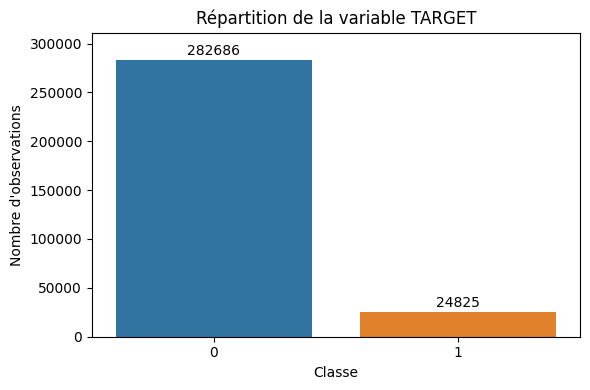

In [9]:
# Conversion de la colonne TARGET en int
Application_train['TARGET'] = Application_train['TARGET'].astype(int)

# Création d'une dataframe pour le barplot
target_counts = Application_train['TARGET'].value_counts().sort_index()
df_plot = pd.DataFrame({'TARGET': target_counts.index, 'count': target_counts.values})

# Construction de la figure 
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=df_plot,
    x='TARGET',
    y='count',
    hue='TARGET',           
    legend=False           
)

# Ajout d'un titre et des noms des axes
plt.title("Répartition de la variable TARGET")
plt.xlabel("Classe")
plt.ylabel("Nombre d'observations")

# Modification de la hauteur du graphique
plt.ylim(0, max(df_plot['count']) * 1.1)

# Ajout des valeurs sur les barres
for i, v in enumerate(df_plot['count']):
    ax.text(i, v + max(df_plot['count']) * 0.01, str(v), ha='center', va='bottom')

# Ajustement du graphique
plt.tight_layout()

# Sauvegarde du graphique
plt.savefig(f'../Output/Analyses_univariées/Distribution_variable_cible.png', format='png')

# Affichage du graphique
plt.show()

Le graphique représentant la répartition de la variable cible montre que la classe 0, correspondant aux clients à faible risque, est largement majoritaire par rapport à la classe 1, correspondant aux clients à risque élevé. En effet, la classe 0 représente environ 92 % de l’ensemble des observations. Cette forte asymétrie implique qu’il sera nécessaire d’appliquer une stratification lors du découpage des données, afin de garantir une répartition proportionnelle des deux classes dans les ensembles d’entraînement et de test. Pour les analyses suivantes, nous nous concentrerons uniquement sur le jeu d’entraînement.

In [10]:
# Découpage de la table de données en jeu d'entrainement et jeu de test
App_train, App_test = train_test_split(Application_train, stratify=Application_train['TARGET'], test_size=0.2, random_state=42)

# Affichage de la forme de la table du jeu d'entrainement
App_train.shape

(246008, 121)

<Axes: >

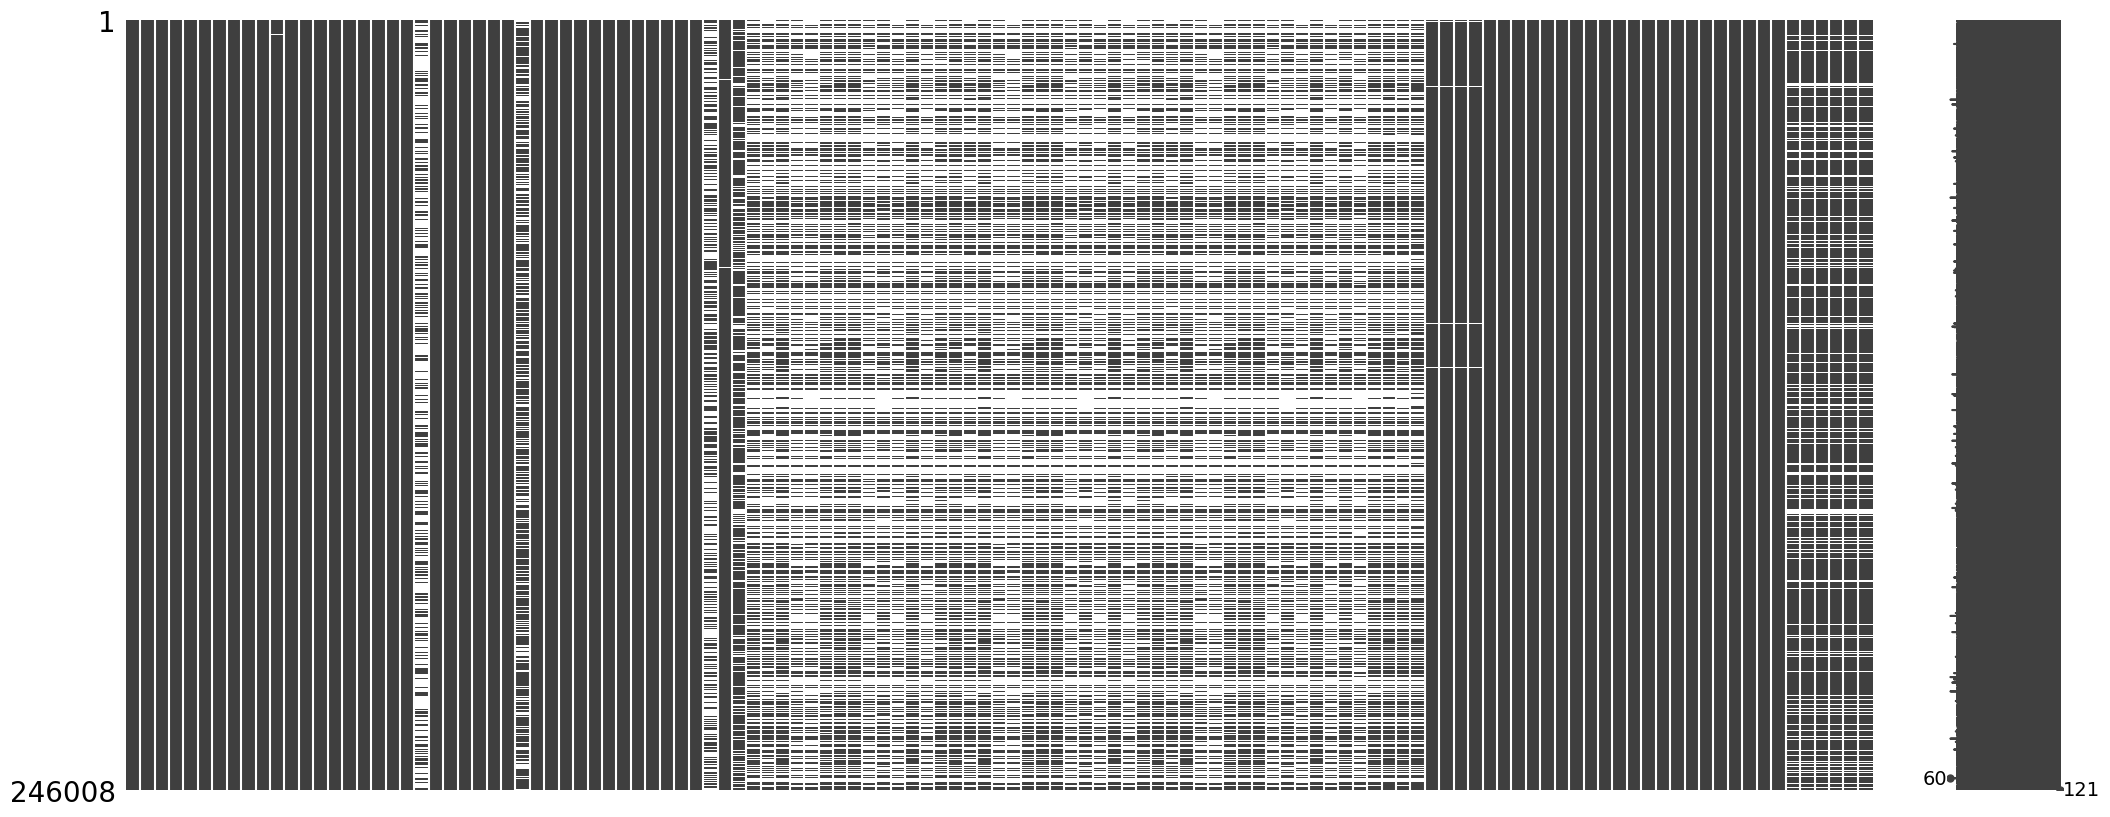

In [11]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(App_train)

Cette matrice binaire représentant les valeurs manquantes par variable nous indique qu'un certains nombre de variables sont peu renseignées. Le taux de valeurs manquantes sera calculé pour chacune des variables, puis une fonction sera utilisée pour éliminer les variables dont le taux de valeur manquante est supérieur à 25%.

La dataframe contient 121 colonnes.
Il y a 67 colonnes qui possèdent des valeurs manquantes.


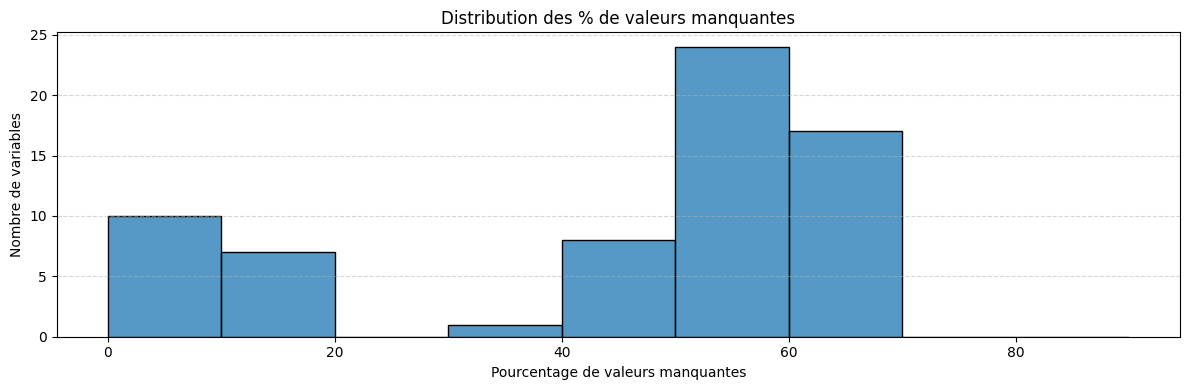


 Colonnes supprimées : 50
['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MOD

In [12]:
# Appel de la fonction
missing_values = missing_values_table(App_train)

# Appel de la fonction pour visualiser la distribution des taux de valeurs manquantes
plot_missing_percentage_hist(missing_values, bins=range(0,100,10))

# Initialisation de la fonction de nettoyage
cleaner = cleaning(threshold_percent=25, verbose=True)

# Fit sur App_train
App_train_2 = cleaner.fit_transform(App_train)

Au total, 50 variables ont été supprimées à cause de leur forte proportion de valeurs manquantes. On va tout de même regarder a quoi correspondait ces variables pour s'assurer qu'aucune variable susceptible d'être essentielle pour le projet n'ait été écartée.

In [13]:
# Liste des variables supprimées
variable_sup = [col for col in App_train.columns if col not in App_train_2.columns]

# Descriptions des variables de la table Application
sub_table = Home_credit_desc[Home_credit_desc['Table']=='application_{train|test}.csv']

# Filtres de la table pour garder que les variables supprimées
filtered_table = sub_table[sub_table['Row'].isin(variable_sup)]

# Affichage des descriptions
for index, row in filtered_table.iterrows():
    print(f"- {row['Row']} : {row['Description']}")

- OWN_CAR_AGE : Age of client's car
- OCCUPATION_TYPE : What kind of occupation does the client have
- EXT_SOURCE_1 : Normalized score from external data source
- APARTMENTS_AVG : Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
- BASEMENTAREA_AVG : Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
- YEARS_BEGINEXPLUATATION_AVG : Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevato

Les variables supprimées correspondent majoritairement à des informations relatives aux bien possédés par le client. On retrouve notamment l'age de la voiture personnelle du client ou un grand nombre d'informations caractérisant le logement du client telles que sa surface total et la surfaces des différentes pièces ou encore le matériaux de construction, l'année de construction ainsi que le nombre d'ascenceurs. La plupart de ces variables sont fournis avec 3 mesures statistiques (la moyenne, le mode et la médiane). 

La variable supprimée avec le moins de valeurs manquantes (31,35%) apporte des informatoins sur la profession du client. Cette variable parait pertinente et pourra être ajoutée ultérieurement si nécessaire.

<Axes: >

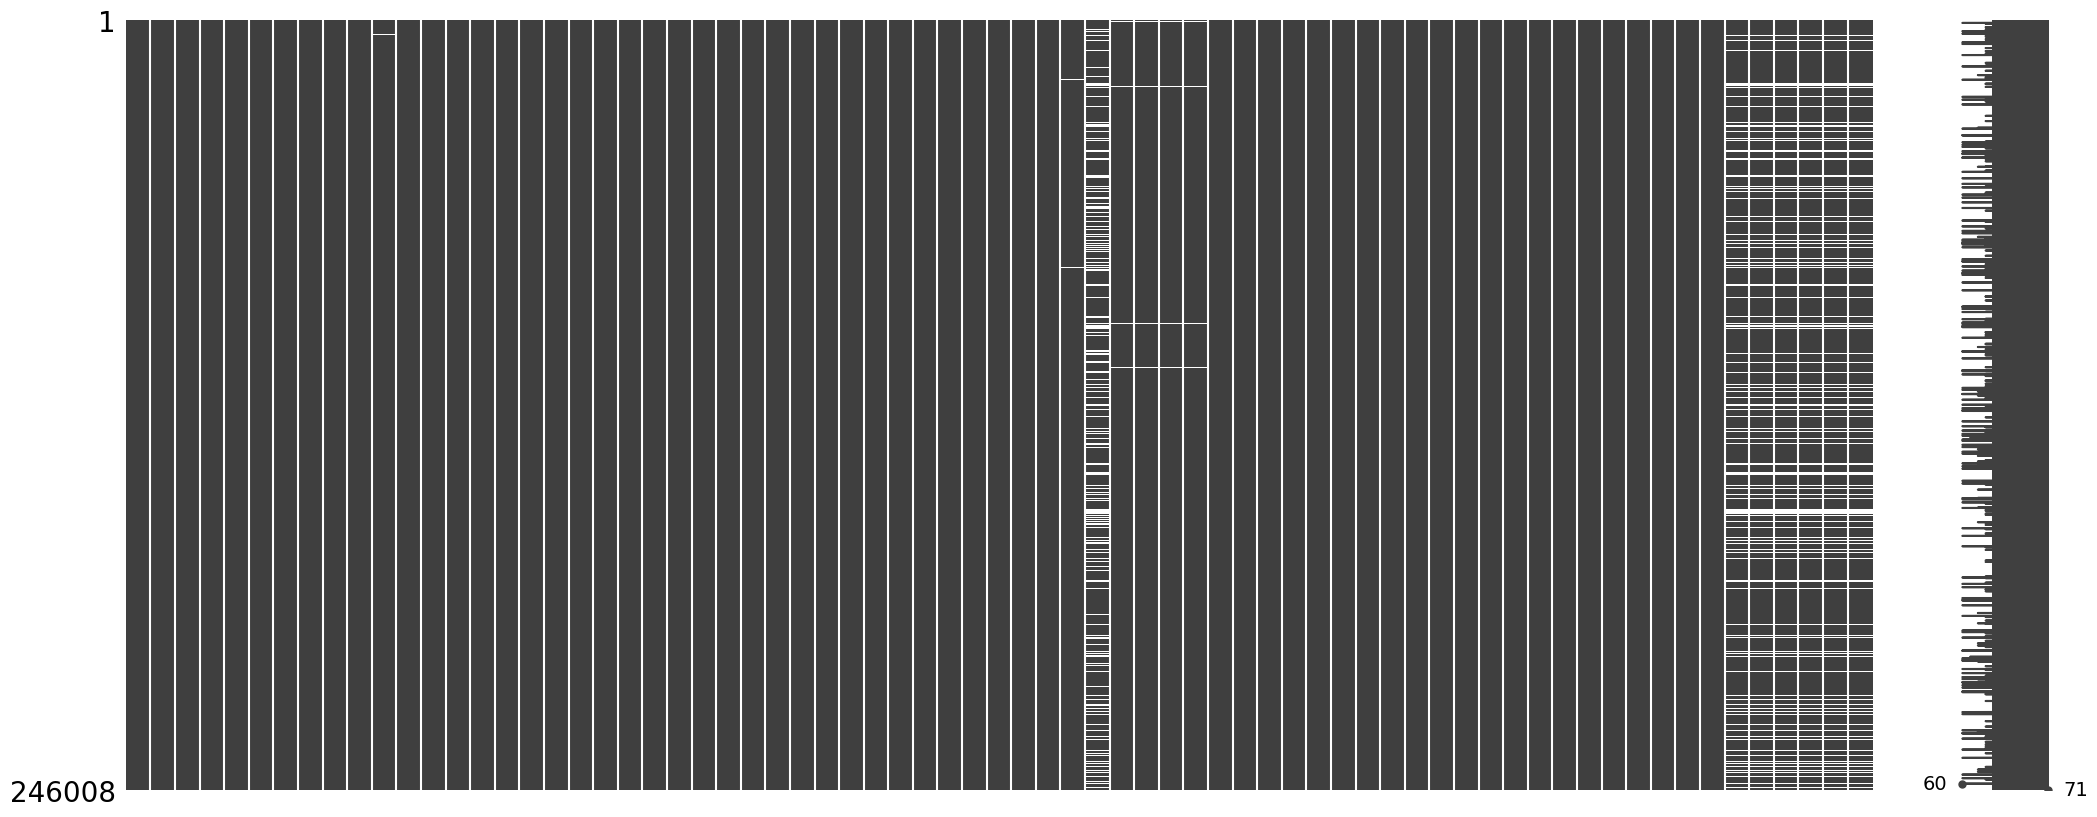

In [14]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(App_train_2)

Maintenant, que les variables avec une forte proportion de valeurs manquantes ont été écartées, on peut s'intéresser aux variables qui ont été conservées et analyser leur signification. Cela permettra d'éliminer d'éventuelles variables non pertinentes.

In [15]:
# Filtre de la table pour ne garder que les variables non supprimées
filtered_table = sub_table[~sub_table['Row'].isin(variable_sup)]

# Affichage des descriptions restantes
for index, row in filtered_table.iterrows():
    print(f"- {row['Row']}: {row['Description']}")

- SK_ID_CURR: ID of loan in our sample
- TARGET: Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
- NAME_CONTRACT_TYPE: Identification if loan is cash or revolving
- CODE_GENDER: Gender of the client
- FLAG_OWN_CAR: Flag if the client owns a car
- FLAG_OWN_REALTY: Flag if client owns a house or flat
- CNT_CHILDREN: Number of children the client has
- AMT_INCOME_TOTAL: Income of the client
- AMT_CREDIT: Credit amount of the loan
- AMT_ANNUITY: Loan annuity
- AMT_GOODS_PRICE: For consumer loans it is the price of the goods for which the loan is given
- NAME_TYPE_SUITE: Who was accompanying client when he was applying for the loan
- NAME_INCOME_TYPE: Clients income type (businessman, working, maternity leave,…)
- NAME_EDUCATION_TYPE: Level of highest education the client achieved
- NAME_FAMILY_STATUS: Family status of the client
- NAME_HOUSING_TYPE: Wh

Au total, 71 variables ont été conservées suite au nettoyage des variables avec un taux de valeurs manquantes  25%. 

On retrouve des caractéristiques relatives aux prets demandés telles que le type du contrat (NAME_CONTRACT_TYPE), le montant du crédit (AMT_CREDIT), le montant mensuel à rembourser (AMT_ANNUITY) ou encore le prix des biens à financer (AMT_GOOD_PRICE). D'autres variables indiquent les élements inclus dans le dossier, comme la présence ou l'absence de certains documents (FLAG_DOCUMENT) ou le nombre de demandes faites au cours de différentes périodes à plus ou moins court termes (AMT_REQ_CREDIT_BUREAU) ainsi que le jour de la semaine et l'heure de la demande (APPR_PROCESS_START). 

Les variables restantes fournissent des informations sociodémographiques comme le sexe (CODE_GENDER), la situation familliale (NAME_FAMILY_STATUS), le nombre d'enfant (CCNT_CHILDREN), le niveau d'éducation (NAME_EDUCATION_TYPE) ou le type de logement (NAME_HOUSING_TYPE). D'autres indicateurs précisent si le client possède une voiture (FLAG_OWN_CAR) ou un bien immobilier (FLAG_OWN_REALTY). Le profil professionel et financier de ces clients est décrit par le type de revenu (NAME_INCOME_TYPE), le revenu annuel déclaré (AMT_INCOME_TOTAL), et le type d'organisation dans laquelle le client est employé (ORGANIZATION_TYPE). On retrouve également des informations sur l'envirronement du client comme la densité de population de la région (REGION_POPULATION_RELATIVE), ou les notations régionales internes (REGIEN_RATING_CLIENT). La table renseigne également sur la correspondance entre les lieux de résidence et de travail à différents niveaux: ville, région (REG_REGION_NOT_WORK_REGION). 

Certaines variables donnent des informations sur le nombre de personnes dans l'entourage du client ayant eu des retard de paiments sur le dernier mois ou les deux derniers mois (CNT_SOCIAL_CIRCLE). Enfin, des scores provenant de sources externes et refletant la fiabililité financière du client sont également fournis (EXT_SOURCE).

On va maintenant analyser plus finement ces variables en s'intéressant aux différentes mesures statistiques et aux valeurs prises par les variables restantes.

In [16]:
# Ajuster l'affichage pour voir toutes les colonnes
pd.set_option('display.max_columns', None)

# Analyses statistiques des variables numériques
App_train.describe()

TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  246008.000000  246008.000000      2.460080e+05  2.460080e+05   
mean        0.080729       0.416409      1.688532e+05  5.993382e+05   
std         0.272419       0.719500      2.589606e+05  4.027258e+05   
min         0.000000       0.000000      2.565000e+04  4.500000e+04   
25%         0.000000       0.000000      1.125000e+05  2.700000e+05   
50%         0.000000       0.000000      1.476000e+05  5.147775e+05   
75%         0.000000       1.000000      2.025000e+05  8.086500e+05   
max         1.000000      19.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  245998.000000     2.457870e+05               246008.000000   
mean    27108.089708     5.386530e+05                    0.020858   
std     14520.904087     3.695950e+05                    0.013835   
min      1615.500000     4.050000e+04                    0.000290   
25%     16510.500000     2.385000e+05                    0.010006   
50%     24903.000000     4.500000e+05                    0.018850   
75%     34596.000000     6.795000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  246008.000000  246008.000000      246008.000000    246008.000000   
mean   -16029.515882   63581.163637       -4989.585005     -2994.150438   
std      4362.869037  141081.696923        3524.557231      1508.274570   
min    -25229.000000  -17912.000000      -24672.000000     -7197.000000   
25%    -19673.000000   -2762.000000       -7480.000000     -4298.000000   
50%    -15744.000000   -1215.000000       -4505.000000     -3255.000000   
75%    -12401.000000    -291.000000       -2015.000000     -1720.000000   
max     -7489.000000  365243.000000           0.000000         0.000000   

        OWN_CAR_AGE     FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
count  83590.000000  246008.000000   246008.000000    246008.000000   
mean      12.057363       0.999996        0.820518         0.199680   
std       11.911241       0.002016        0.383756         0.399761   
min        0.000000       0.000000        0.000000         0.000000   
25%        5.000000       1.000000        1.000000         0.000000   
50%        9.000000       1.000000        1.000000         0.000000   
75%       15.000000       1.000000        1.000000         0.000000   
max       91.000000       1.000000        1.000000         1.000000   

       FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  CNT_FAM_MEMBERS  \
count     246008.000000  246008.000000  246008.000000    246006.000000   
mean           0.998122       0.280942       0.056734         2.152025   
std            0.043295       0.449460       0.231334         0.908271   
min            0.000000       0.000000       0.000000         1.000000   
25%            1.000000       0.000000       0.000000         2.000000   
50%            1.000000       0.000000       0.000000         2.000000   
75%            1.000000       1.000000       0.000000         3.000000   
max            1.000000       1.000000       1.000000        20.000000   

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count         246008.000000                246008.000000   
mean               2.052303                     2.031462   
std                0.508873                     0.502598   
min                1.000000                     1.000000   
25%                2.000000                     2.000000   
50%                2.000000                     2.000000   
75%                2.000000                     2.000000   
max                3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            246008.000000               246008.000000   
mean                 12.061514                    0.015020   
std                   3.264146            

L'analyse de cette table nous permet de remarquer que la plupart des variables temporelles sont exprimées avec des valeurs négatives. Pour faciliter leur interprétation, leur valeurs seront converties en nombres positifs. De plus, on peut également s'apercevoir que l’âge du client est actuellement exprimé en jours. Pour rendre cette information plus intuitive, celle ci sera convertie en nombre d'années. Cela sera fait avec la même fonction de nettoyage utilisée précédemment via l'ajout d'une étape.

In [17]:
# Initialisation de la fonction de nettoyage
cleaner = cleaning(threshold_percent=25, verbose=True,
                   convert_days_to_years_cols=['DAYS_BIRTH'],
                   convert_days_to_abs_cols=['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'],)

# Fit sur App_train
App_train_2 = cleaner.fit_transform(App_train)


 Colonnes supprimées : 50
['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MOD

Il est également important d'analyser la distribution des variables numériques afin d'identifier d'éventuelles valeurs abberrantes. Pour cela, un boxplot sera construit pour chacune des variables numériques ayant des valeurs continues. Pour les variables discrêtes, des graphique de type countplot seront utilisés à la place.

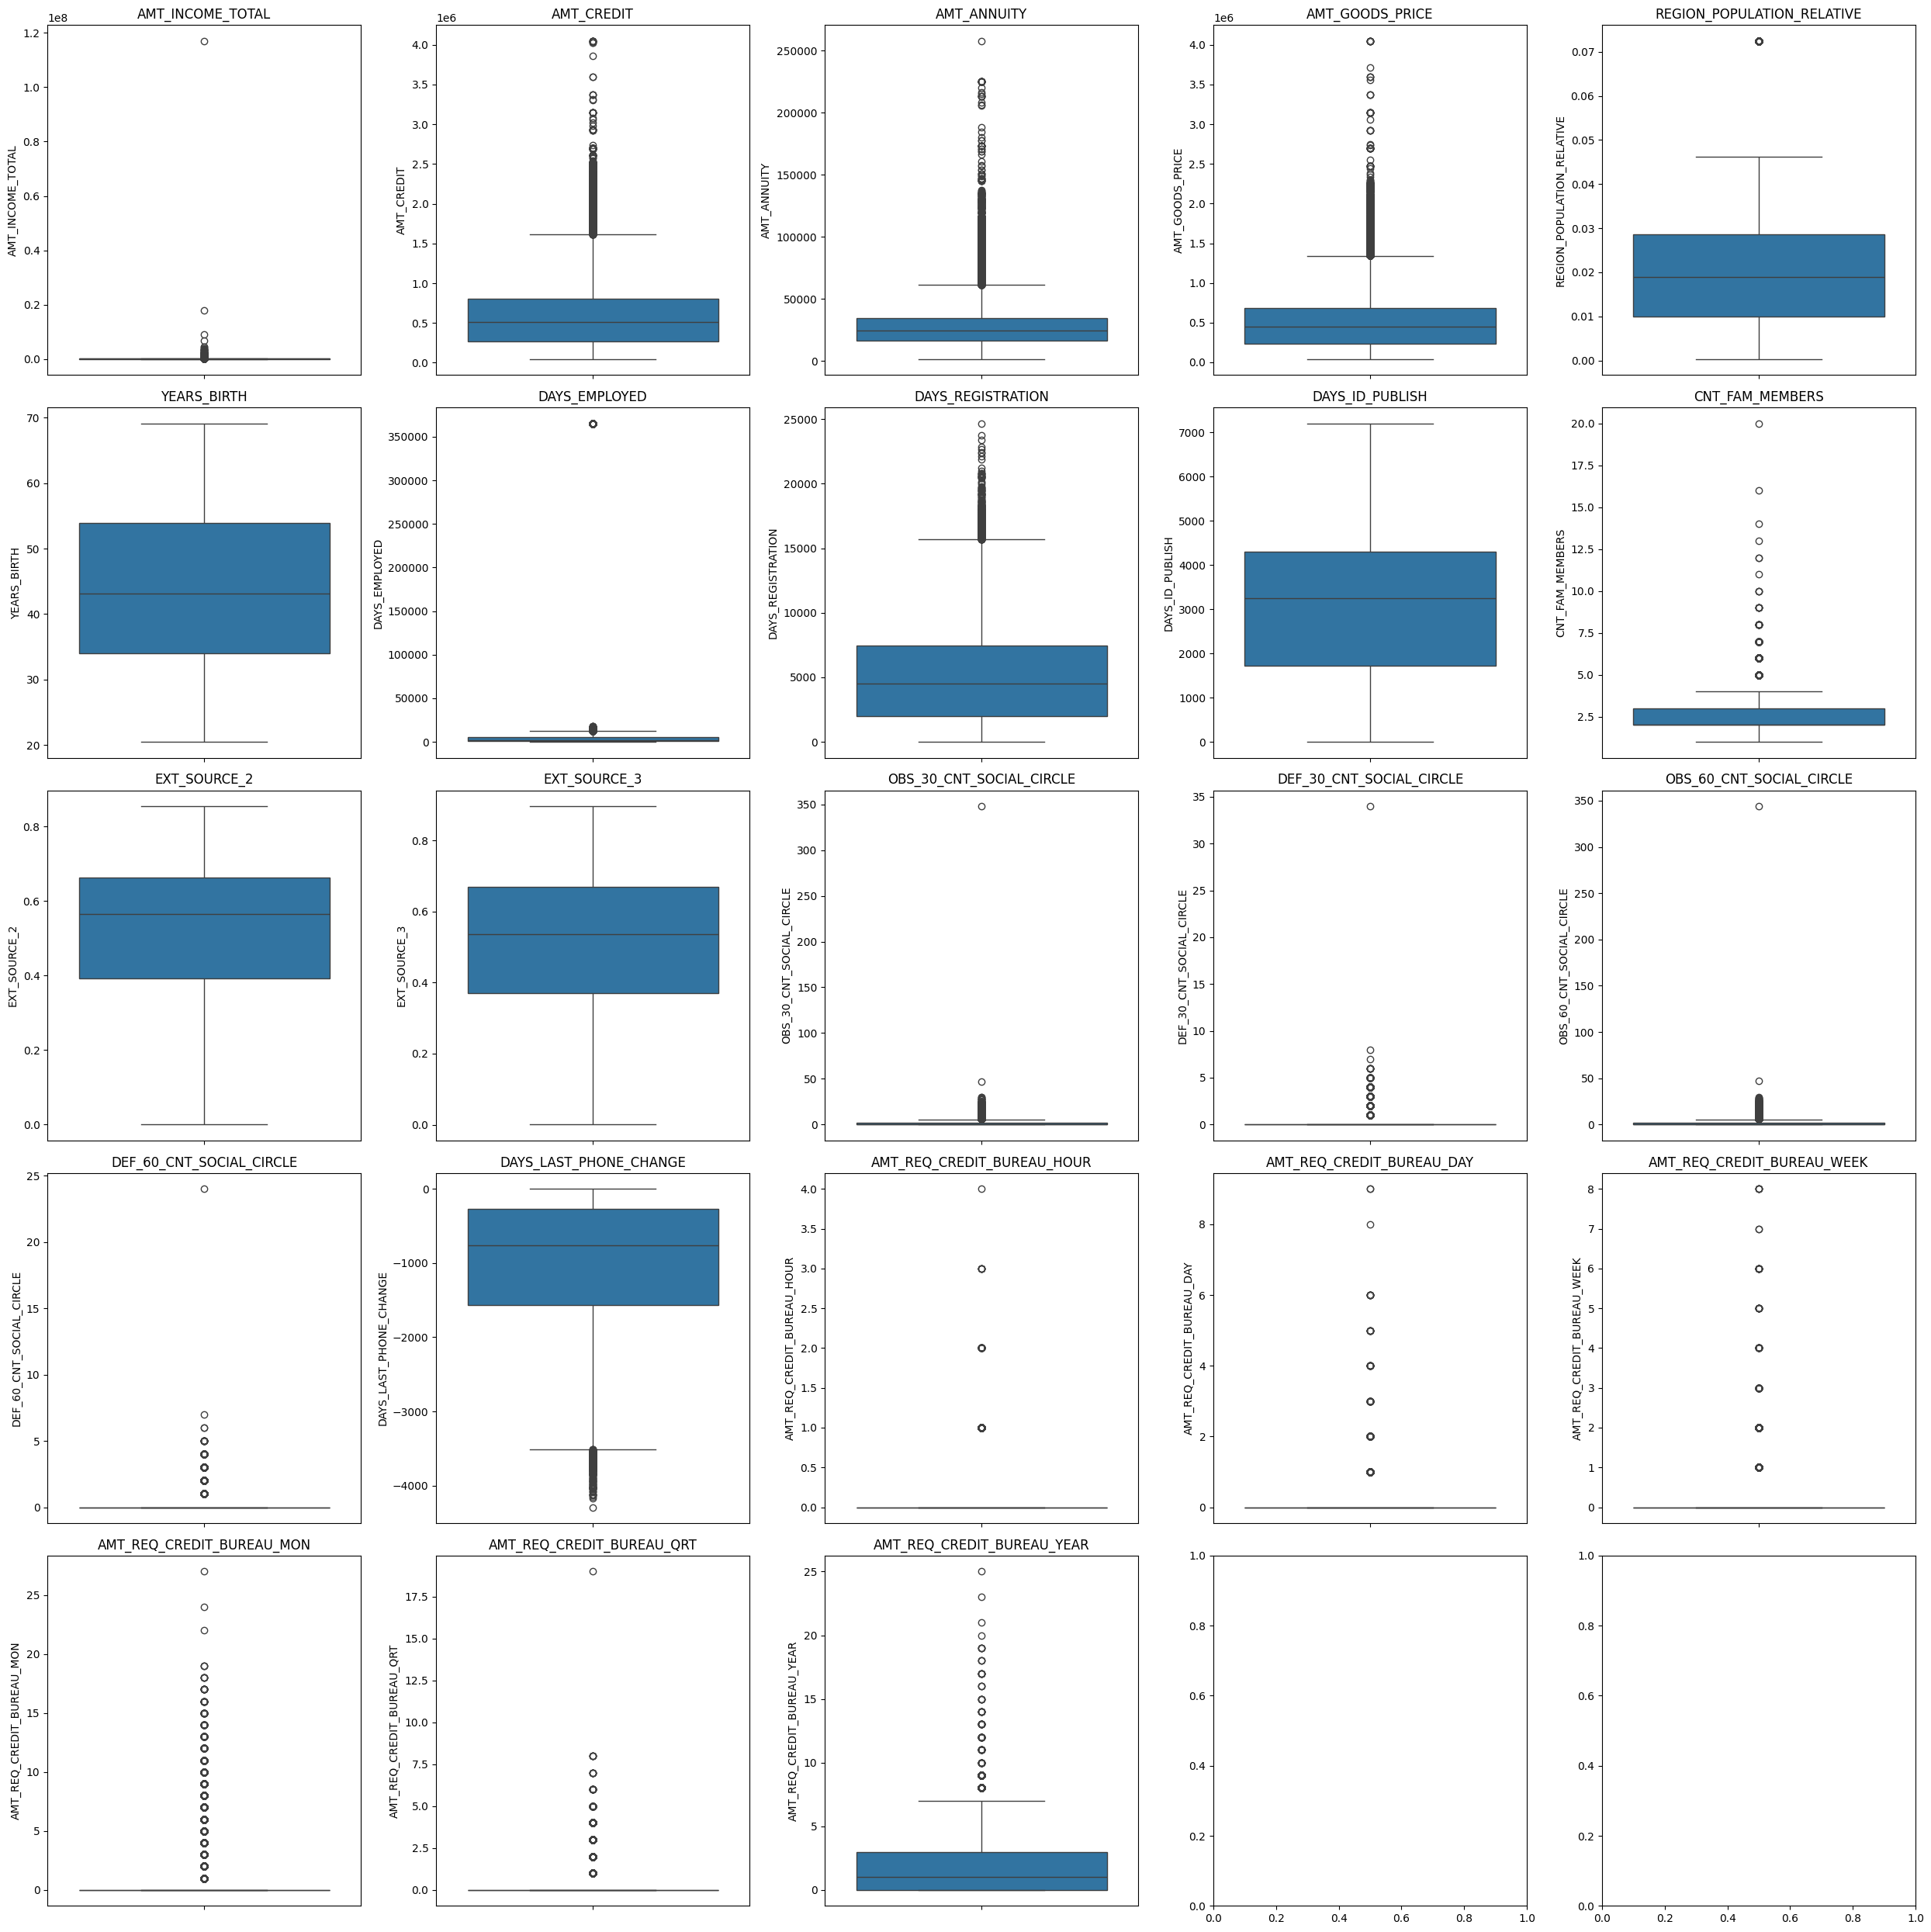

In [18]:
# Identification des variables numériques continues
float_cols = App_train_2.select_dtypes(include=['float']).columns

# Définition du nombre de colonnes à afficher dans le graphique
n_cols = 5

# Cacul du nombre de lignes 
n_rows = math.ceil(len(float_cols) / n_cols)

# Initialisation de la figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))

# Appltissement de l'objet des axes
axes = axes.flatten()

# Pour chaque variables, construction du boxplot
for i, col in enumerate(float_cols):
    sns.boxplot(y=App_train_2[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Ajustement de la figure
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig(f'../Output/Analyses_univariées/Distribution_variables_explicatives_numériques_(Application).png', format='png')

# Affichage de la figure
plt.show()

On note que la plupart des variables contiennent des valeurs extrèmes qui s'éloignent du 3ieme quartile. Notamment, la variable AMT_INCOME_TOTAL contient une valeur qui s'éloigne très fortement des autres valeur. De même pour la variable DAYS_EMPLOYED on note une valeur à plus de 350 000 jours ce qui correspond approximativement à plus de 950 années ce qui est aberrant. Cette dernière a en fait été signalée sur Kaggle comment étant une valeur indiquant une absence d'information pour les variables correspondant à des nombre de jours. Ces valeurs aberrantes seront remplacées par des valeurs manquantes qui seront imputées par la suite.

In [19]:
# Initialisation de la fonction de nettoyage
cleaner = cleaning(threshold_percent=25, verbose=True,    
                   aberrant_max={'AMT_INCOME_TOTAL': 10000000},
                   aberrant_values={"DAYS_EMPLOYED": [365243]},
                   convert_days_to_years_cols=['DAYS_BIRTH'],
                   convert_days_to_abs_cols=['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'],)

# Fit sur App_train
App_train_2 = cleaner.fit_transform(App_train)


 Colonnes supprimées : 50
['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MOD

Les variables numériques continues ayant été analysées, on peut maintenant s'intéresser aux variables de type FLAG qui représentent une information binaire et qui sont donc supposées prendre uniquement deux valeurs (0/1, True/False). On peut donc vérrifier que c'est bien le cas.

In [20]:
# Identification des colonnes FLAG
flag_columns = [col for col in App_train_2.columns if col.startswith('FLAG')]
flag_columns = flag_columns + ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION' , 'LIVE_REGION_NOT_WORK_REGION',
                               'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']

# Dictionnaire pour regrouper les colonnes selon leurs valeurs uniques
flag_groups = {}

# Pour chaque variable
for col in flag_columns:
    
    # Identification des valeurs uniques
    unique_vals = tuple(sorted(App_train_2[col].dropna().unique()))
    flag_groups.setdefault(unique_vals, []).append(col)

# Affichage
for vals, cols in flag_groups.items():
    print(f"Valeurs uniques {vals} :")
    print(", ".join(cols))
    print()


Valeurs uniques ('N', 'Y') :
FLAG_OWN_CAR, FLAG_OWN_REALTY

Valeurs uniques (0, 1) :
FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY



Les variables de type FLAG contiennent bien, comme attendu, uniquement deux modalités chacune. Une autre catégorie de variables correspond aux variables catégorielles. Il va être important dans un premier temps d’examiner le nombre de modalités distinctes prises par chacune de ces variables pour identifier les variables ayant un nombre de modalités élevé qu'on traitera différement.

In [21]:
# Identification des variables catégorielles 
cat_columns = App_train_2.select_dtypes(include=['object', 'category']).columns

# Affichage du nombre de modalité par variable catégorielle
App_train_2[cat_columns].nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

Il y a effectivement une variable, la variable ORGANIZATION_TYPE, qui contient un nombre très elevé de modalité s'élevant à plus de 50 modalité. On va d'abord s'intéresser aux variables catégorielles avec un nombre plus limité de modalité avant de revenir vers cette variable.

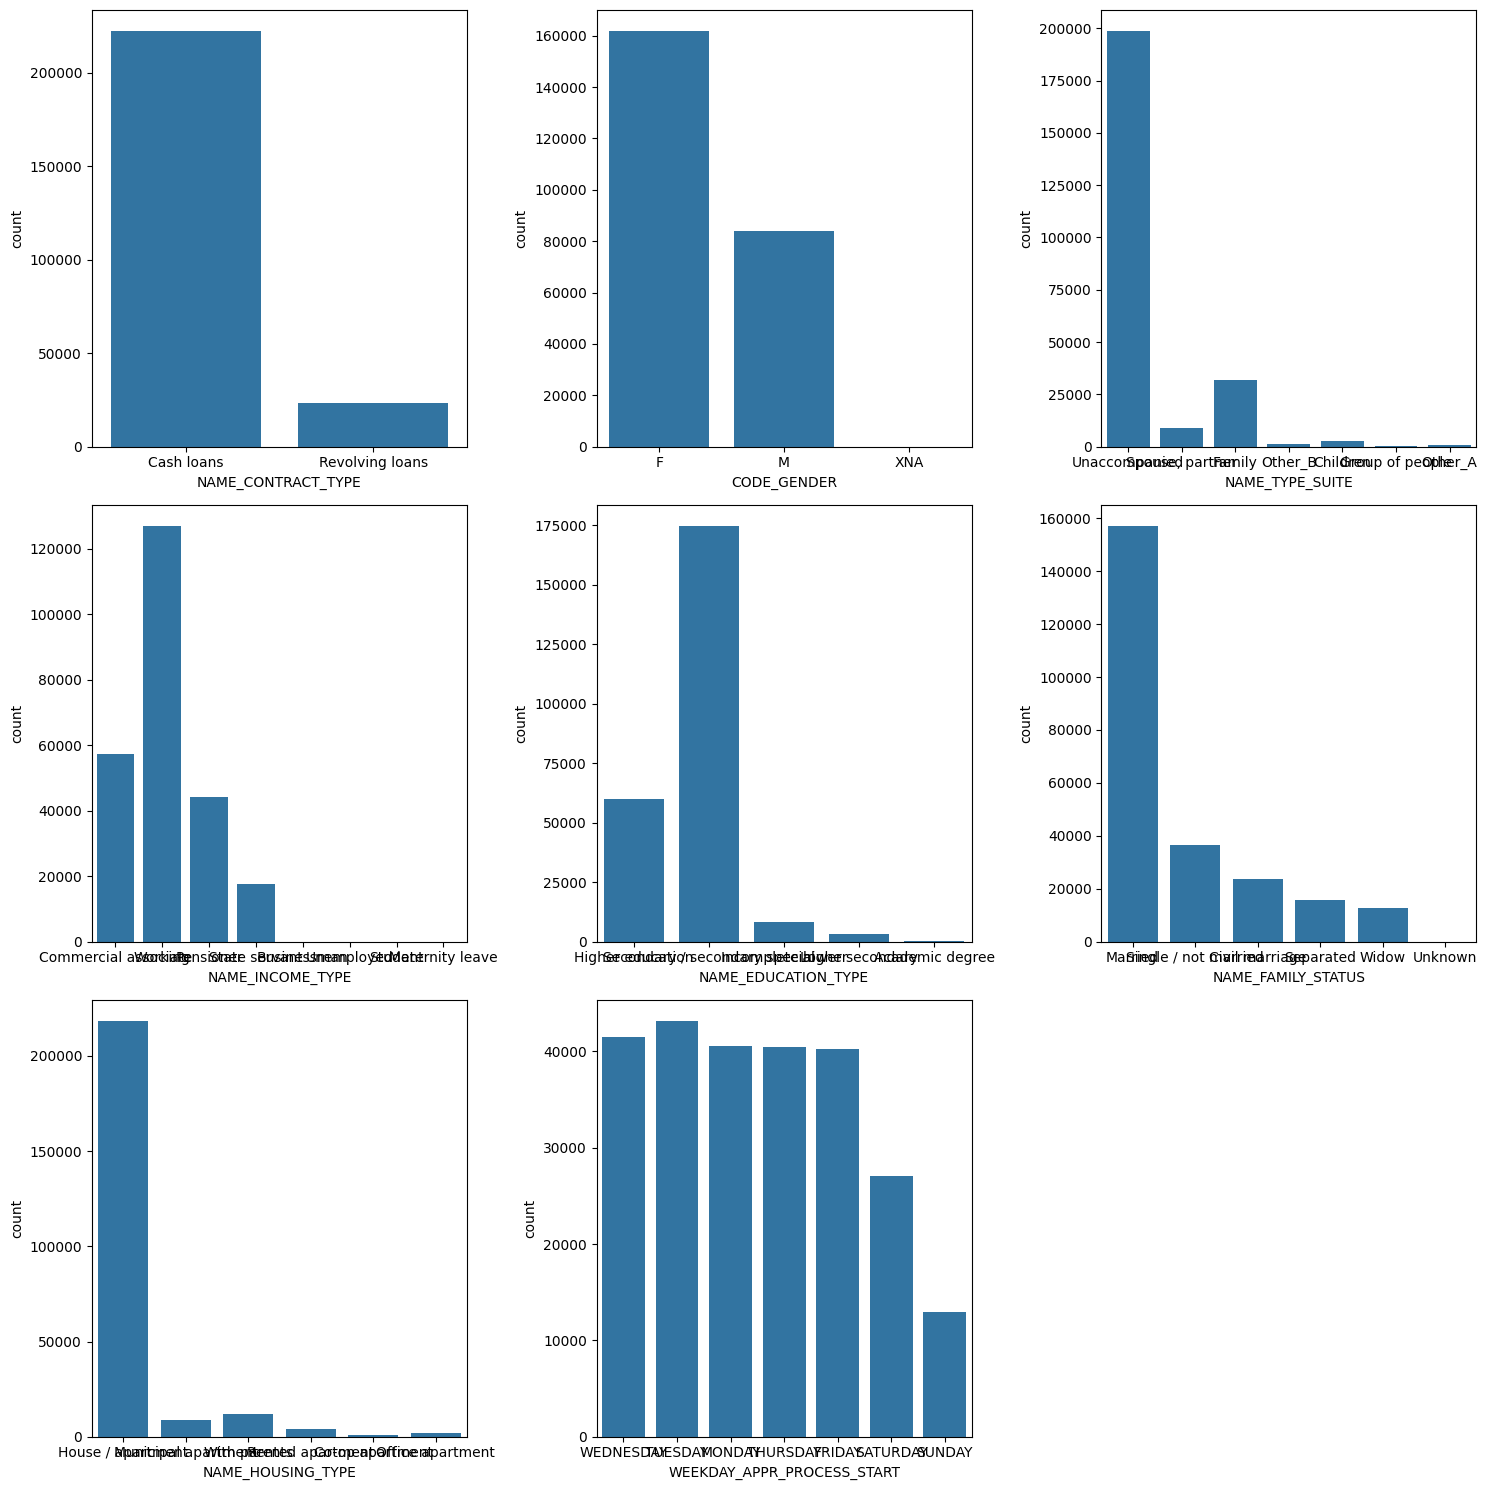

In [22]:
# Supression des variables correspondant à des flag
cat_columns = [col for col in cat_columns if col not in flag_columns and col!="ORGANIZATION_TYPE"]

# Défintion du nombre de colonnes à afficher
n_cols = 3

# Calcul du nombre de lignes correspondantes
n_rows = math.ceil(len(cat_columns) / n_cols)

# Initialisation de la figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))

# Applatissement de l'objet axe
axes = axes.flatten()

# Pour chaque variable, construction d'un countplot
for i, col in enumerate(cat_columns):
    graph = sns.countplot(x=col, data=App_train_2, ax=axes[i])
    ax.set_title(col, fontsize=14)
    ax.tick_params(axis='x', rotation=90, labelsize=12)

    #  Ajout d'une marge pour ajouter les effectifs
    ax.set_ylim(0, App_train_2[col].value_counts().max() * 1.1)

    # Ajout des effectifs
    for p in graph.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width()/2.,
            height,
            f'{int(height)}',
            ha="center", va="bottom", fontsize=9
        )
        
# Suppression des axes non utilisés
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
# Ajustement de la figure
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig(f'../Output/Analyses_univariées/Distribution_variable_explicatives_categorielles_(Application).png', format='png')

# Affichage de la figure
plt.show()

À l’exception de la variable GENDER, les variables catégorielles analysées ne semblent pas contenir de modalités aberrantes. La variable GENDER présente une modalité XNA, qui correspond probablement aux cas où le champ n’a pas été renseigné. Ces occurrences étant très rares, on peut décider de les supprimer du jeu de données. Pour cela, on pourra à nouveau utiliser la fonction de nettoyage, en y ajoutant une étape de filtrage pour exclure ces valeurs.

In [23]:
# Initialisation de la fonction de nettoyage
cleaner = cleaning(threshold_percent=25, verbose=True,
                   aberrant_max={'AMT_INCOME_TOTAL': 10000000},
                   aberrant_values={"DAYS_EMPLOYED": [365243]},                   
                   convert_days_to_years_cols=['DAYS_BIRTH'],
                   convert_days_to_abs_cols=['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'],
                   filter_values={"CODE_GENDER" : ['XNA']})

# Fit sur App_train
App_train_2 = cleaner.fit_transform(App_train)


 Colonnes supprimées : 50
['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MOD

<module 'matplotlib.pyplot' from 'C:\\Users\\33647\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

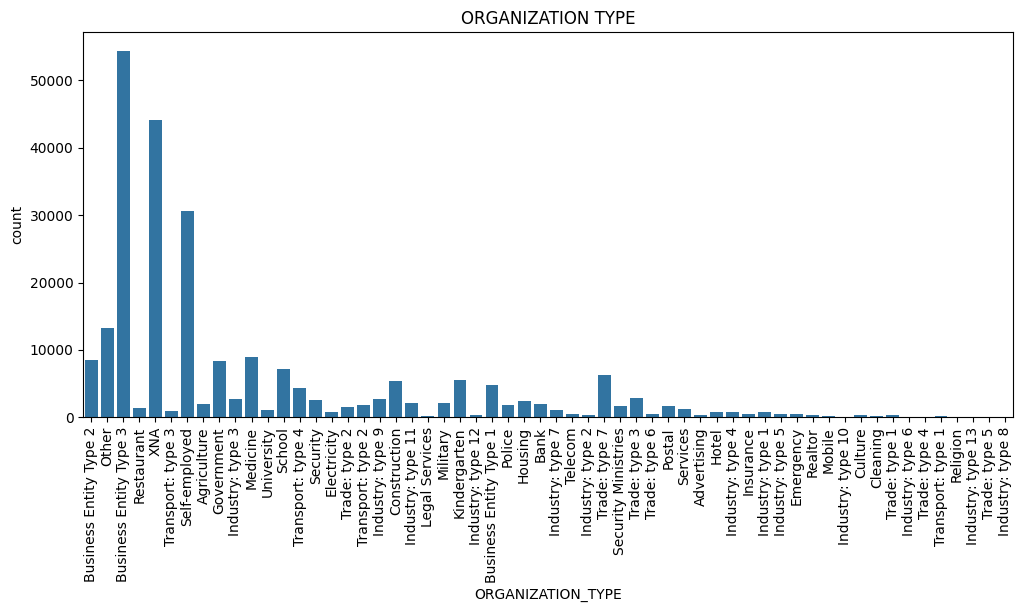

In [24]:
# Initialisation de la figure 
plt.figure(figsize=(12,5))

# Construction du countplot
sns.countplot(x='ORGANIZATION_TYPE', data=App_train_2)

# Rotation des labels
plt.tick_params(axis='x', rotation=90)

# Ajout du titre
plt.title('ORGANIZATION TYPE')


# Sauvegarde de la figure
plt.savefig(f'../Output/Analyses_univariées/Distribution_variable_organization_type_(Application).png', format='png')

# Affichage de la figure
plt

On observe que certaines des modalités de la variable ORGANIZATION_TYPE sont très peu représentées. Les variables à forte cardinalité ne sont pas toujours pertinentes pour la modélisation, car elles augmentent le nombre de variables après encodage et génèrent des matrices creuses. Il faudrait alors soit regrouper certaines modalités ensembles, soit ne pas prendre en compte cette variable. Dans un premier temps cette variable ne sera pas prise en compte.

In [25]:
# Initialisation de la fonction de nettoyage
cleaner = cleaning(threshold_percent=25, verbose=True,
                   aberrant_max={'AMT_INCOME_TOTAL': 10000000},
                   aberrant_values={"DAYS_EMPLOYED": [365243]},                   
                   drop_cols =  ['ORGANIZATION_TYPE'],
                   convert_days_to_years_cols=['DAYS_BIRTH'],
                   convert_days_to_abs_cols=['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'],
                   filter_values={"CODE_GENDER" : ['XNA']})


# Fit sur App_train
App_train_2 = cleaner.fit_transform(App_train)


 Colonnes supprimées : 51
['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MOD

Jusqu'à présent, ont été analysées les variables numériques continues, les variables binaires de type FLAG et les variables catégorielle. Il reste les variables numériques discrètes qu'on va maintenant analyser. 

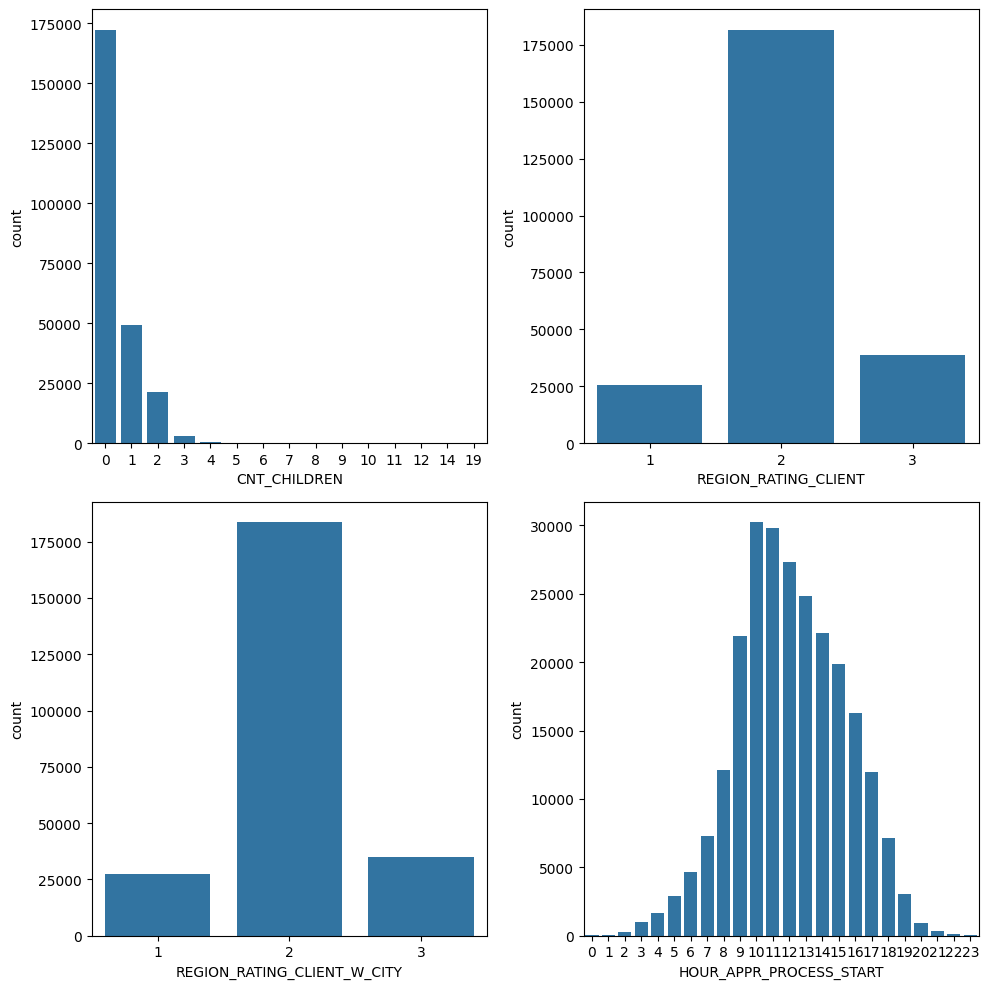

In [26]:
# Liste des variables pas encore représentées
other_columns = [
    col for col in App_train_2.columns
    if col not in flag_columns and col not in float_cols and col not in cat_columns and col!='TARGET' and col!='ORGANIZATION_TYPE'
]

# Défintion du nombre de colonne à afficher
n_cols = 2

# Calcul du nombre de lignes correspondantes
n_rows = math.ceil(len(other_columns) / n_cols)

# Initialisation de la figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))

# Applatissement de l'objet axe
axes = axes.flatten()

# Pour chaque variable, construction d'un countplot
for i, col in enumerate(other_columns):
    bars = sns.countplot(x=col, data=App_train_2, ax=axes[i])
    ax.set_title(col, fontsize=14)
    ax.tick_params(axis='x', rotation=90, labelsize=12)

    #  Ajout d'une marge pour ajouter les effectifs
    ax.set_ylim(0, App_train_2[col].value_counts().max() * 1.1)

    # Ajout des effectifs
    for p in bars.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width()/2.,
            height,
            f'{int(height)}',
            ha="center", va="bottom", fontsize=9
        )
       
    
# Suppression des axes non utilisés les axes inutilisés
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
# Ajustement de la figure
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig(f'../Output/Analyses_univariées/Distribution_variable_explicatives_numériques_discrètes_(Application).png', format='png')

# Affichage de la figure
plt.show()

Les quatres derniers graphiques ne révèlent pas de données abberantes. Le nombre d'enfant est toutefois atypique pour certains des clients dont certains ont plus de 10 enfants. Ces cas étant rares mais possibles, nous ne les traiterons pas, à moins que les performances des modèles ne soit pas satisfaisantes, auquel cas on pourra revenir sur cette partie de nettoyage des données.

## Data previous application

In [27]:
# Affichage des 5 premières lignes de la table
Data_prev_app.head()

SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
SK_ID_PREV                                                                
2030495         271877     Consumer loans     1730.430          17145.0   
2802425         108129         Cash loans    25188.615         607500.0   
2523466         122040         Cash loans    15060.735         112500.0   
2819243         176158         Cash loans    47041.335         450000.0   
1784265         202054         Cash loans    31924.395         337500.0   

            AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
SK_ID_PREV                                                  
2030495        17145.0               0.0          17145.0   
2802425       679671.0               NaN         607500.0   
2523466       136444.5               NaN         112500.0   
2819243       470790.0               NaN         450000.0   
1784265       404055.0               NaN         337500.0   

           WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
SK_ID_PREV                                                       
2030495                      SATURDAY                       15   
2802425                      THURSDAY                       11   
2523466                       TUESDAY                       11   
2819243                        MONDAY                        7   
1784265                      THURSDAY                        9   

           FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
SK_ID_PREV                                                       
2030495                              Y                       1   
2802425                              Y                       1   
2523466                              Y                       1   
2819243                              Y                       1   
1784265                              Y                       1   

            RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
SK_ID_PREV                                             
2030495                   0.0               0.182832   
2802425                   NaN                    NaN   
2523466                   NaN                    NaN   
2819243                   NaN                    NaN   
1784265                   NaN                    NaN   

            RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE  \
SK_ID_PREV                                                    
2030495                     0.867336                    XAP   
2802425                          NaN                    XNA   
2523466                          NaN                    XNA   
2819243                          NaN                    XNA   
1784265                          NaN                Repairs   

           NAME_CONTRACT_STATUS  DAYS_DECISION      NAME_PAYMENT_TYPE  \
SK_ID_PREV                                                              
2030495                Approved            -73  Cash through the bank   
2802425                Approved           -164                    XNA   
2523466                Approved           -301  Cash through the bank   
2819243                Approved           -512  Cash through the bank   
1784265                 Refused           -781  Cash through the bank   

           CODE_REJECT_REASON  NAME_TYPE_SUITE NAME_CLIENT_TYPE  \
SK_ID_PREV                                                        
2030495                   XAP              NaN         Repeater   
2802425                   XAP    Unaccompanied         Repeater   
2523466                   XAP  Spouse, partner         Repeater   
2819243                   XAP              NaN         Repeater   
1784265                    HC              NaN         Repeater   

           NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
SK_ID_PREV                                                        
2030495                 Mobile            POS               XNA   
2802425                    XNA           Cash            x-sell   
2523466                    XNA           Cash  

In [28]:
# Affichage des informations associées à la table
Data_prev_app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1670214 entries, 2030495 to 2418762
Data columns (total 36 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_CURR                   1670214 non-null  int64  
 1   NAME_CONTRACT_TYPE           1670214 non-null  object 
 2   AMT_ANNUITY                  1297979 non-null  float64
 3   AMT_APPLICATION              1670214 non-null  float64
 4   AMT_CREDIT                   1670213 non-null  float64
 5   AMT_DOWN_PAYMENT             774370 non-null   float64
 6   AMT_GOODS_PRICE              1284699 non-null  float64
 7   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 8   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 9   FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 10  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 11  RATE_DOWN_PAYMENT            774370 non-null   float64
 12  RATE_INTEREST_PRIMARY        5951 non-nul

La table Previous application correspond aux précédentes demandes faites par le clients chez Home Crédit. Elle contient une ligne par demandes qui sont caractérisées par 35 variables dont 18 sont quantitatives et 16 sont qualitatives. 

In [29]:
# Extraction des lignes correspondantes à la table dans la table description
sub_table = Home_credit_desc[Home_credit_desc['Table']=='previous_application.csv']

# Affichage de la description des variables de la table
for index, row in sub_table.iterrows():
    print(f"- {row['Row']} : {row['Description']}")

- SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit) 
- SK_ID_CURR : ID of loan in our sample
- NAME_CONTRACT_TYPE : Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application
- AMT_ANNUITY : Annuity of previous application
- AMT_APPLICATION : For how much credit did client ask on the previous application
- AMT_CREDIT : Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT
- AMT_DOWN_PAYMENT : Down payment on the previous application
- AMT_GOODS_PRICE : Goods price of good that client asked for (if applicable) on the previous application
- WEEKDAY_APPR_PROCESS_START

Chaque précédente demande de crédit est caractérisée par un identifiant unique (SK_ID_PREV) et est relié à l'identificant de la demande actuelle (SK_ID_CURR). Ces demandes sont caractérisées par un grand nombre de variables. 

On retrouve des variables quantitatives exprimant des montants comme le montant demandé (AMT_APPLICATION), le montant accordé (AMT_CREDIT), l’annuité (AMT_ANNUITY), l’apport initial (AMT_DOWN_PAYMENT) et le prix des biens financés (AMT_GOODS_PRICE). Ces variables sont complétées par des ratios et taux comme le taux d’apport (RATE_DOWN_PAYMENT) ou les taux d’intérêt (RATE_INTEREST). On note également la présence de variables temporelles qui permettent de situer certains évènement par rapport au prêt actuel, depuis le jour et l’heure de la demande jusqu’aux échéances et à la fin prévue du crédit (DAYS_DECISION, DAYS_FIRST_DRAWING, DAYS_LAST_DUE, etc.). 

La table comprend aussi des variables qui décrivent le type (NAME_CONTRACT_TYPE) et le statut (NAME_CONTRACT_STATUS) du contrat, la durée du crédit, certains indicateurs binaires sur la dernière demande (NFLAG) ou la souscription d’assurance (NFLAG_INSURED_ON_APPROVAL). Enfin, d'autres variables  renseignent sur l’objet du prêt (NAME_GOODS_CATEGORY), le mode de paiement ou encore le motif de refus éventuel (CODE_REJECT_REASON).

<Axes: >

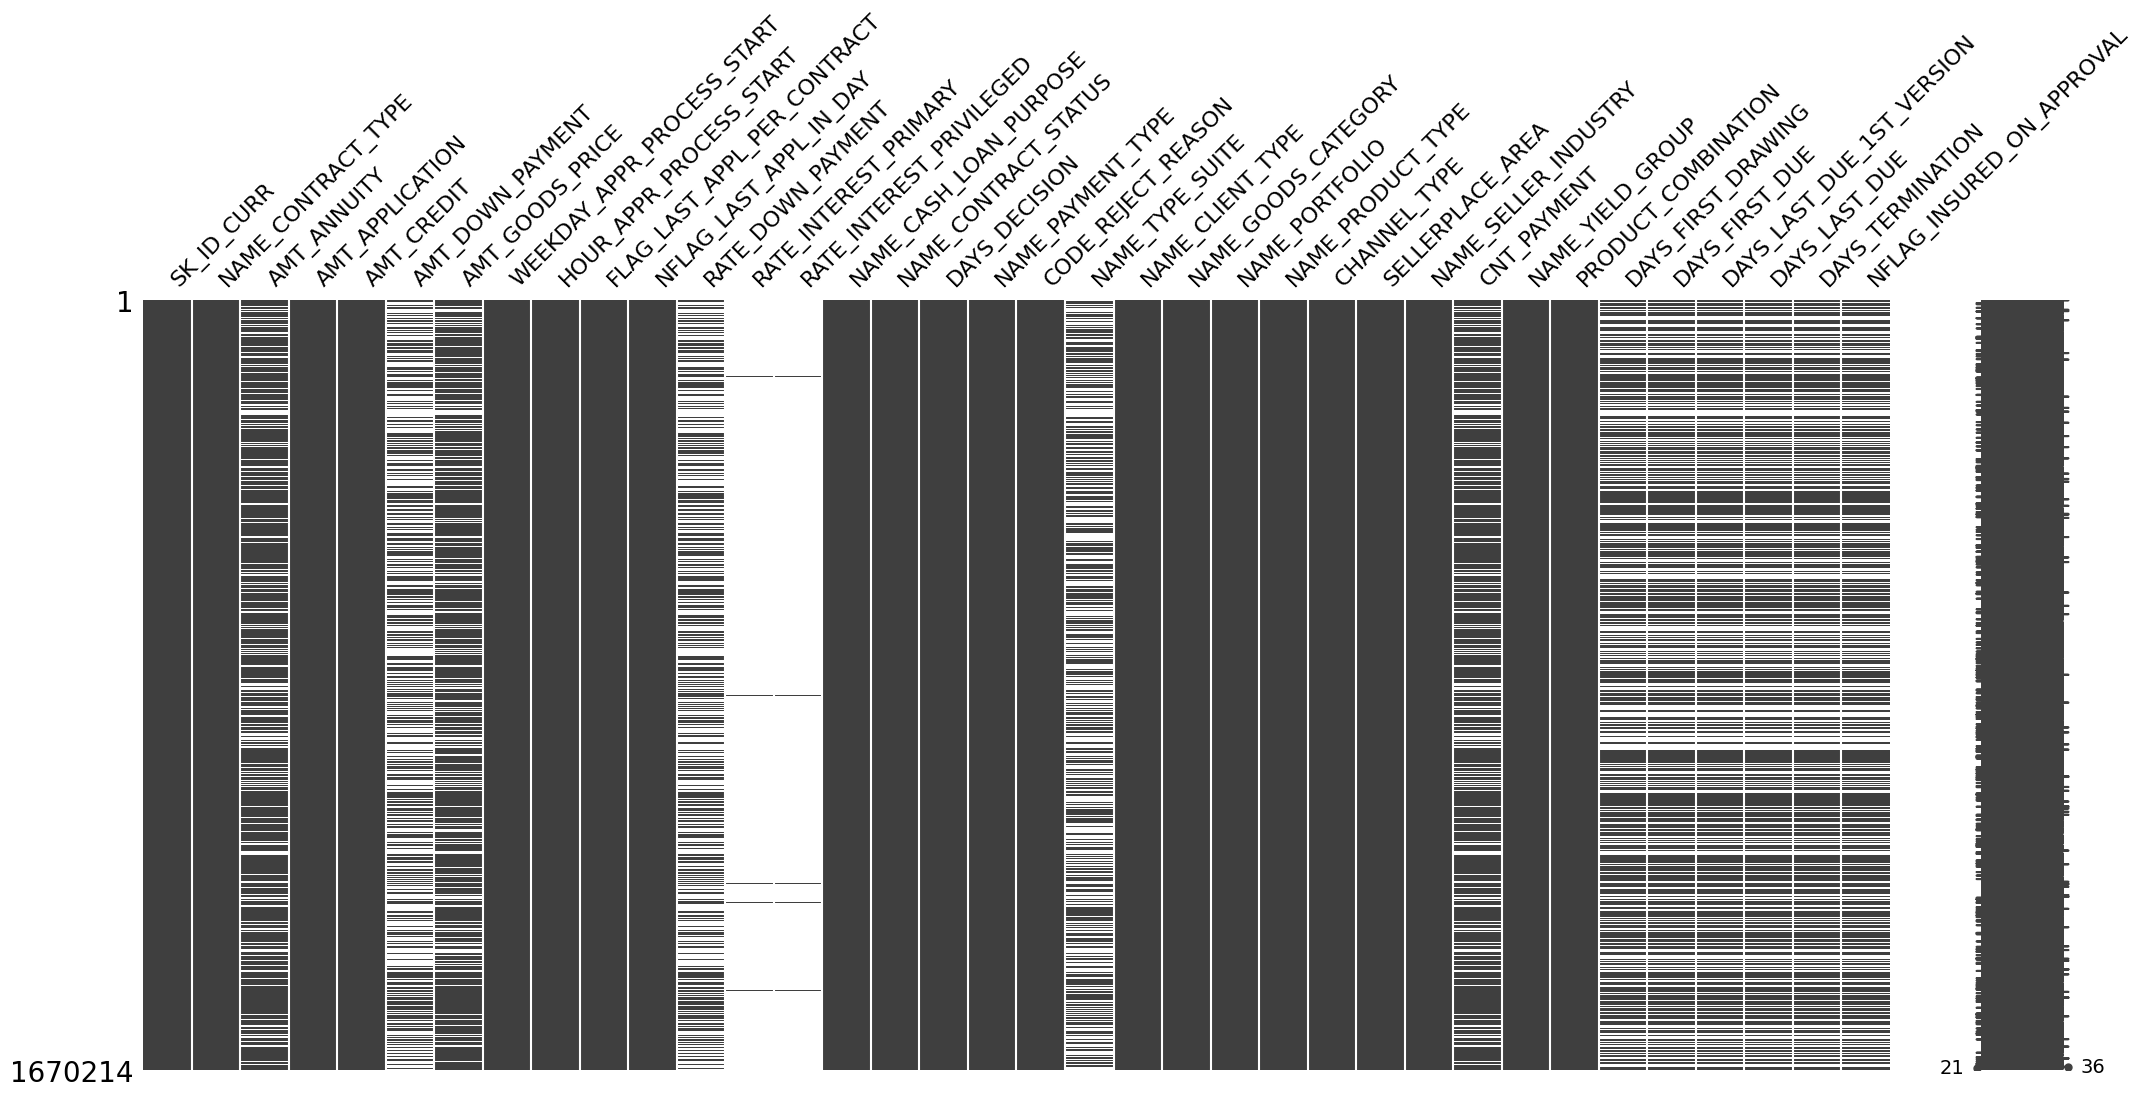

In [30]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(Data_prev_app)

In [31]:
# Description statistiques des variables numériques
Data_prev_app.describe()

SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION    AMT_CREDIT  \
count  1.670214e+06  1.297979e+06     1.670214e+06  1.670213e+06   
mean   2.783572e+05  1.595512e+04     1.752339e+05  1.961140e+05   
std    1.028148e+05  1.478214e+04     2.927798e+05  3.185746e+05   
min    1.000010e+05  0.000000e+00     0.000000e+00  0.000000e+00   
25%    1.893290e+05  6.321780e+03     1.872000e+04  2.416050e+04   
50%    2.787145e+05  1.125000e+04     7.104600e+04  8.054100e+04   
75%    3.675140e+05  2.065842e+04     1.803600e+05  2.164185e+05   
max    4.562550e+05  4.180581e+05     6.905160e+06  6.905160e+06   

       AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  \
count      7.743700e+05     1.284699e+06             1.670214e+06   
mean       6.697402e+03     2.278473e+05             1.248418e+01   
std        2.092150e+04     3.153966e+05             3.334028e+00   
min       -9.000000e-01     0.000000e+00             0.000000e+00   
25%        0.000000e+00     5.084100e+04             1.000000e+01   
50%        1.638000e+03     1.123200e+05             1.200000e+01   
75%        7.740000e+03     2.340000e+05             1.500000e+01   
max        3.060045e+06     6.905160e+06             2.300000e+01   

       NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
count            1.670214e+06      774370.000000            5951.000000   
mean             9.964675e-01           0.079637               0.188357   
std              5.932963e-02           0.107823               0.087671   
min              0.000000e+00          -0.000015               0.034781   
25%              1.000000e+00           0.000000               0.160716   
50%              1.000000e+00           0.051605               0.189122   
75%              1.000000e+00           0.108909               0.193330   
max              1.000000e+00           1.000000               1.000000   

       RATE_INTEREST_PRIVILEGED  DAYS_DECISION  SELLERPLACE_AREA  \
count               5951.000000   1.670214e+06      1.670214e+06   
mean                   0.773503  -8.806797e+02      3.139511e+02   
std                    0.100879   7.790997e+02      7.127443e+03   
min                    0.373150  -2.922000e+03     -1.000000e+00   
25%                    0.715645  -1.300000e+03     -1.000000e+00   
50%                    0.835095  -5.810000e+02      3.000000e+00   
75%                    0.852537  -2.800000e+02      8.200000e+01   
max                    1.000000  -1.000000e+00      4.000000e+06   

        CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count  1.297984e+06       997149.000000   997149.000000   
mean   1.605408e+01       342209.855039    13826.269337   
std    1.456729e+01        88916.115834    72444.869708   
min    0.000000e+00        -2922.000000    -2892.000000   
25%    6.000000e+00       365243.000000    -1628.000000   
50%    1.200000e+01       365243.000000     -831.000000   
75%    2.400000e+01       365243.000000     -411.000000   
max    8.400000e+01       365243.000000   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              997149.000000  997149.000000     997149.000000   
mean                33767.774054   76582.403064      81992.343838   
std                106857.034789  149647.415123     153303.516729   
min                 -2801.000000   -2889.000000      -2874.000000   
25%                 -1242.000000   -1314.000000      -1270.000000   
50%                  -361.000000    -537.000000       -499.000000   
75%                   129.000000     -74.000000        -44.000000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL  
count              997149.000000  
mean                    0.332570  
std                     0.471134  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     1.000000  
max                     1.000000

On note à nouveau la présence de valeurs abberantes dans les variables correspondant à un nombre de jours. Il faudra donc gérer ces valeurs aberrantes avant d'utiliser ces variables. On peut également analyser la distribution des variables les plus intéressantes pour le projet. Pour évaluer la cohérence de certaines informations contenues dans cette tables, des variables intermédiaires vont être créées et visualisées graphiqument ce qui permettra d'identifier plus facilement d'éventuelles anomalies.

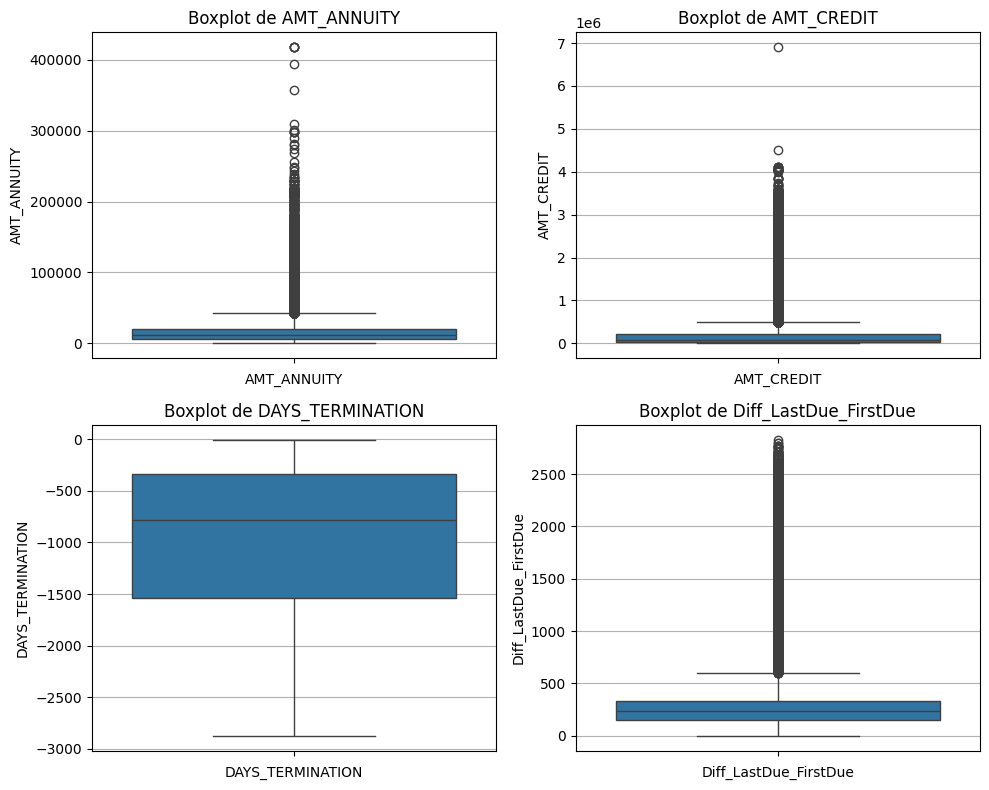

In [32]:
# Définition des variables à traiter
feat = ['DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']

# Copie de la table
Data_prev_app_plot = Data_prev_app.copy()

# Remplacement des valeurs abberantes par des valeurs manquantes
Data_prev_app_plot[feat] = Data_prev_app_plot[feat].replace(365243, np.nan)

# Conversion des variables temporelles en valeur absolue
Data_prev_app_plot['DAYS_FIRST_DUE'] = Data_prev_app_plot['DAYS_FIRST_DUE'].abs()
Data_prev_app_plot['DAYS_LAST_DUE'] = Data_prev_app_plot['DAYS_LAST_DUE'].abs()

# Verrification de la cohérence des variales temporelles
Data_prev_app_plot['Diff_LastDue_FirstDue'] =  Data_prev_app_plot['DAYS_FIRST_DUE'] - Data_prev_app_plot['DAYS_LAST_DUE'] 

# Appel de la fonction de visualisation des distributions des variables numériques
plot_variable_grid(Data_prev_app_plot,
                   variables=["AMT_ANNUITY", "AMT_CREDIT", "DAYS_TERMINATION", "Diff_LastDue_FirstDue"],
                   save_name="Distribution_variables_numériques_(Previous_Application)",
                   plot_type=sns.boxplot,
                   n_cols=2,
                   size_per_plot=(5, 4))

Les distributions ci dessus indiquent que les annuités et le montant du crédit contiennent des valeurs extrêmes qui s'éloignent du troisième quartile. Néanmoins, ces valeurs bien qu'élevées pouraient correspondre à des cas atypiques et seront conservées telles quelles. Concernant les variables correspondant à des échéances sépcifiques, il ne semble pas y avoir d'incohérence puisque le nombre de jour depuis la première échéance est bien plus important que celui depuis la dernière échéance.

In [33]:
# Analyse du nombre de valeur unique des variables catégorielles
Data_prev_app[['NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS']].nunique()

NAME_CONTRACT_TYPE      4
NAME_CONTRACT_STATUS    4
dtype: int64

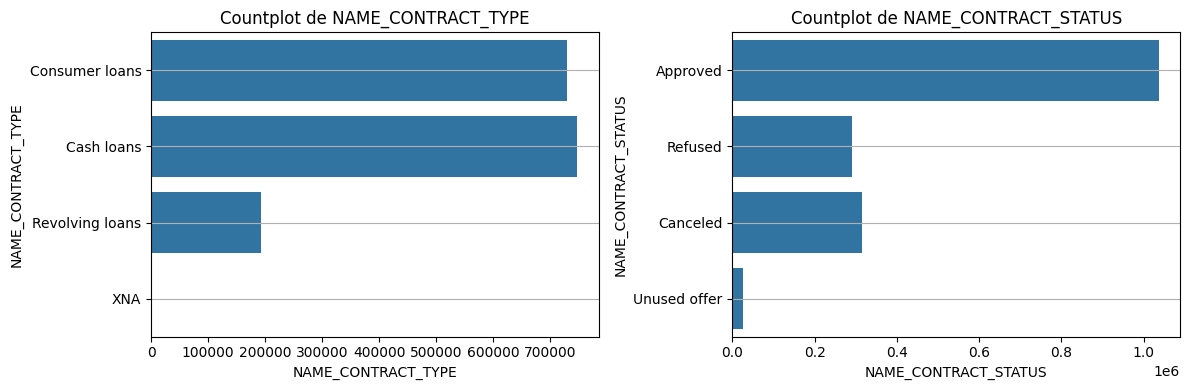

In [34]:
# Appel de la fonction de visualisation des distributions des variables numériques
plot_variable_grid(Data_prev_app,
                   variables=["NAME_CONTRACT_TYPE", "NAME_CONTRACT_STATUS"],
                   save_name="Distribution_variables_catégorielles_(Previous_Application)",
                   plot_type=sns.countplot,
                   n_cols=2,
                   size_per_plot=(6, 4))

L'analyse de la distribution de la variable portant sur les type de contrat indique que cette variable présente 4 modalités dont 2 sont majoritaires et l'une correspond à une valeur correspondant probablement à une absence de renseignement pour ce champ. Concernant les status des crédits, on note que la majorité des crédits ont été approuvés et que certains ont été refusés par la société ou annulés par le client. On observe également quelques demande de crédits pour lesquels une offre a été faite mais jamais concrétisée.

## Data installment payment

In [35]:
# Affichage des 5 premières lignes de la table
Data_intallment_pymnts.head()

SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
SK_ID_PREV                                                              
1054186         161674                     1.0                      6   
1330831         151639                     0.0                     34   
2085231         193053                     2.0                      1   
2452527         199697                     1.0                      3   
2714724         167756                     1.0                      2   

            DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
SK_ID_PREV                                                                    
1054186             -1180.0             -1187.0        6948.360     6948.360  
1330831             -2156.0             -2156.0        1716.525     1716.525  
2085231               -63.0               -63.0       25425.000    25425.000  
2452527             -2418.0             -2426.0       24350.130    24350.130  
2714724             -1383.0             -1366.0        2165.040     2160.585

In [36]:
# Affichage des informations associées à la table
Data_intallment_pymnts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13605401 entries, 1054186 to 2448869
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   NUM_INSTALMENT_VERSION  float64
 2   NUM_INSTALMENT_NUMBER   int64  
 3   DAYS_INSTALMENT         float64
 4   DAYS_ENTRY_PAYMENT      float64
 5   AMT_INSTALMENT          float64
 6   AMT_PAYMENT             float64
dtypes: float64(5), int64(2)
memory usage: 830.4 MB


In [37]:
# Extraction des lignes correspondantes à la table dans la table description
sub_table = Home_credit_desc[Home_credit_desc['Table']=='installments_payments.csv']

# Affichage de la description des variables de la table
for index, row in sub_table.iterrows():
    print(f"- {row['Row']} : {row['Description']}")

- SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- SK_ID_CURR : ID of loan in our sample
- NUM_INSTALMENT_VERSION : Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
- NUM_INSTALMENT_NUMBER : On which installment we observe payment
- DAYS_INSTALMENT : When the installment of previous credit was supposed to be paid (relative to application date of current loan)
- DAYS_ENTRY_PAYMENT : When was the installments of previous credit paid actually (relative to application date of current loan)
- AMT_INSTALMENT : What was the prescribed installment amount of previous credit on this installment
- AMT_PAYMENT : What the client actually paid on previous credit on this installment


Les variables fournies dans cette table permettent de suivre le paiement des crédits précédents accordés par Home Crédits. 

On retrouve les identifiants (SK_ID_CURR, SK_ID_PREV) qui permettront de lier le prêt actuel aux demandes précédentes présentes dans cette table. On retrouve des informations sur les échéances comme la date prévue de paiement (DAYS_INSTALMENT) et la date réelle de paiement (DAYS_ENTRY_PAYMENT). D'autres variables indiquent les montants qui étaient dûs (AMT_INSTALMENT) et ce qui a été effectivement payé par le client (AMT_PAYMENT). Ces variables permettent de mesurer la ponctualité et la régularité des remboursements du client sur les crédits précédents.

<Axes: >

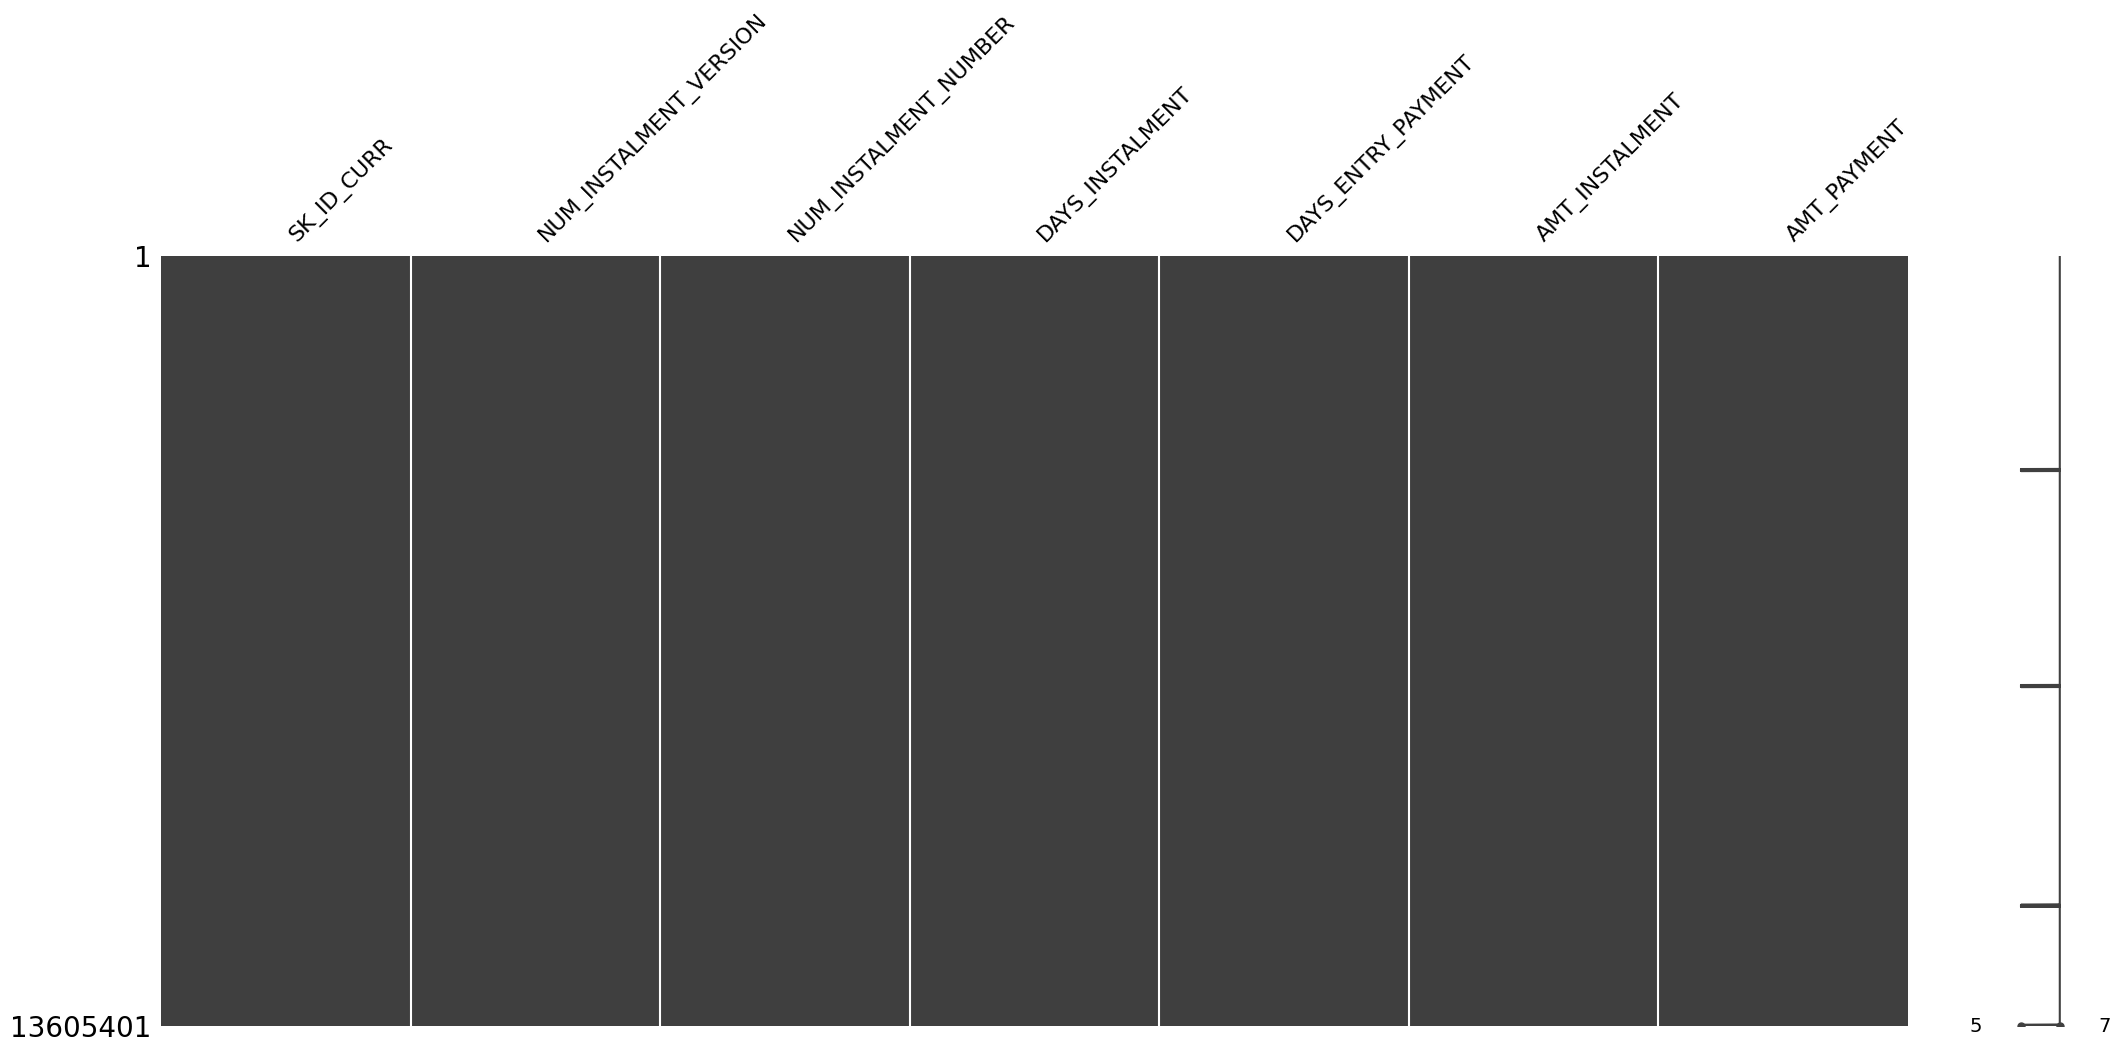

In [38]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(Data_intallment_pymnts)

In [39]:
# Description statistiques des variables numériques
Data_intallment_pymnts.describe()

SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
count  1.360540e+07            1.360540e+07           1.360540e+07   
mean   2.784449e+05            8.566373e-01           1.887090e+01   
std    1.027183e+05            1.035216e+00           2.666407e+01   
min    1.000010e+05            0.000000e+00           1.000000e+00   
25%    1.896390e+05            0.000000e+00           4.000000e+00   
50%    2.786850e+05            1.000000e+00           8.000000e+00   
75%    3.675300e+05            1.000000e+00           1.900000e+01   
max    4.562550e+05            1.780000e+02           2.770000e+02   

       DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  
count     1.360540e+07        1.360250e+07    1.360540e+07  1.360250e+07  
mean     -1.042270e+03       -1.051114e+03    1.705091e+04  1.723822e+04  
std       8.009463e+02        8.005859e+02    5.057025e+04  5.473578e+04  
min      -2.922000e+03       -4.921000e+03    0.000000e+00  0.000000e+00  
25%      -1.654000e+03       -1.662000e+03    4.226085e+03  3.398265e+03  
50%      -8.180000e+02       -8.270000e+02    8.884080e+03  8.125515e+03  
75%      -3.610000e+02       -3.700000e+02    1.671021e+04  1.610842e+04  
max      -1.000000e+00       -1.000000e+00    3.771488e+06  3.771488e+06

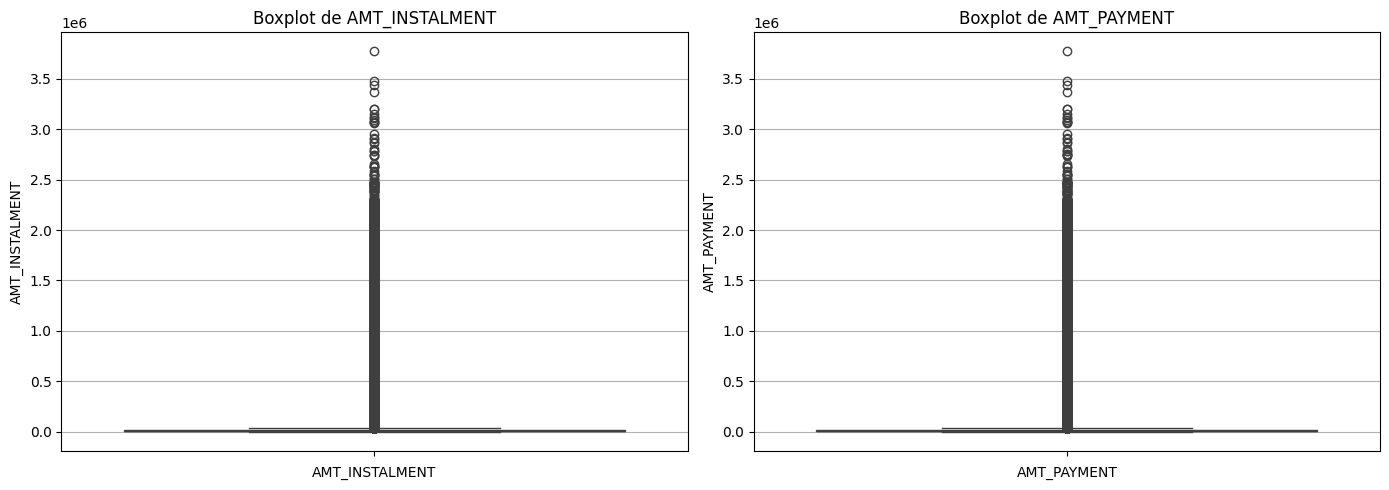

In [40]:
# Appel de la fonction de visualisation des distributions des variables numériques
plot_variable_grid(Data_intallment_pymnts,
                   variables=["AMT_INSTALMENT", "AMT_PAYMENT"],
                   save_name="Distrubution_variables_numériques_(Installment_payment)",
                   plot_type=sns.boxplot,
                   n_cols=2,
                   size_per_plot=(7, 5))


A nouveau on remarque pour les deux variables analysées la présence de valeur extrèmes s'éloignant du troisième quartile. La encore il pourrait s'agit de valeurs atypiques qu'on conservera telle quelle. Une analyse plus approfondie du profil associés à ces clients serait nécessaire pour évaluer si ces valeurs sont anormales ou atypiques. Cette décision de conserver ces valeurs pourrait être réévaluer dans le cas où les performances des modèles ne soient pas satisfaisantes. 

## Data credit balance 

In [41]:
# Affichage des 5 premières lignes de la table
Data_credit_bal.head()

SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_PREV                                                                     
2562384         378907              -6       56.970                   135000   
2582071         363914              -1    63975.555                    45000   
1740877         371185              -7    31815.225                   450000   
1389973         337855              -4   236572.110                   225000   
1891521         126868              -1   453919.455                   450000   

            AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
SK_ID_PREV                                                   
2562384                          0.0                 877.5   
2582071                       2250.0                2250.0   
1740877                          0.0                   0.0   
1389973                       2250.0                2250.0   
1891521                          0.0               11547.0   

            AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
SK_ID_PREV                                                         
2562384                            0.0                     877.5   
2582071                            0.0                       0.0   
1740877                            0.0                       0.0   
1389973                            0.0                       0.0   
1891521                            0.0                   11547.0   

            AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
SK_ID_PREV                                                 
2562384                    1700.325               1800.0   
2582071                    2250.000               2250.0   
1740877                    2250.000               2250.0   
1389973                   11795.760              11925.0   
1891521                   22924.890              27000.0   

            AMT_PAYMENT_TOTAL_CURRENT  AMT_RECEIVABLE_PRINCIPAL  \
SK_ID_PREV                                                        
2562384                        1800.0                     0.000   
2582071                        2250.0                 60175.080   
1740877                        2250.0                 26926.425   
1389973                       11925.0                224949.285   
1891521                       27000.0                443044.395   

            AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  \
SK_ID_PREV                                                                  
2562384             0.000                 0.000                       0.0   
2582071         64875.555             64875.555                       1.0   
1740877         31460.085             31460.085                       0.0   
1389973        233048.970            233048.970                       1.0   
1891521        453919.455            453919.455                       0.0   

            CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
SK_ID_PREV                                                     
2562384                        1                         0.0   
2582071                        1                         0.0   
1740877                        0                         0.0   
1389973                        1                         0.0   
1891521                        1                         0.0   

            CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  \
SK_ID_PREV                                                        
2562384                          1.0                       35.0   
2582071                          0.0                       69.0   
1740877                          0.0                       30.0   
1389973                          0.0                       10.0   
1891521                          1.0                      101.0   

           NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
SK_ID_PREV                                           
2562384                  Active       0           0  
2582071                  Ac

In [42]:
# Extraction des lignes correspondantes à la table dans la table description
sub_table = Home_credit_desc[Home_credit_desc['Table']=='credit_card_balance.csv']

# Affichage de la description des variables de la table
for index, row in sub_table.iterrows():
    print(f"- {row['Row']} : {row['Description']}")

- SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- SK_ID_CURR : ID of loan in our sample
- MONTHS_BALANCE : Month of balance relative to application date (-1 means the freshest balance date)
- AMT_BALANCE : Balance during the month of previous credit
- AMT_CREDIT_LIMIT_ACTUAL : Credit card limit during the month of the previous credit
- AMT_DRAWINGS_ATM_CURRENT : Amount drawing at ATM during the month of the previous credit
- AMT_DRAWINGS_CURRENT : Amount drawing during the month of the previous credit
- AMT_DRAWINGS_OTHER_CURRENT : Amount of other drawings during the month of the previous credit
- AMT_DRAWINGS_POS_CURRENT : Amount drawing or buying goods during the month of the previous credit
- AMT_INST_MIN_REGULARITY : Minimal installment for this month of the previous credit
- AMT_PAYMENT_CURRENT : How much did the client pay during the month on the previous credit
- AMT

<Axes: >

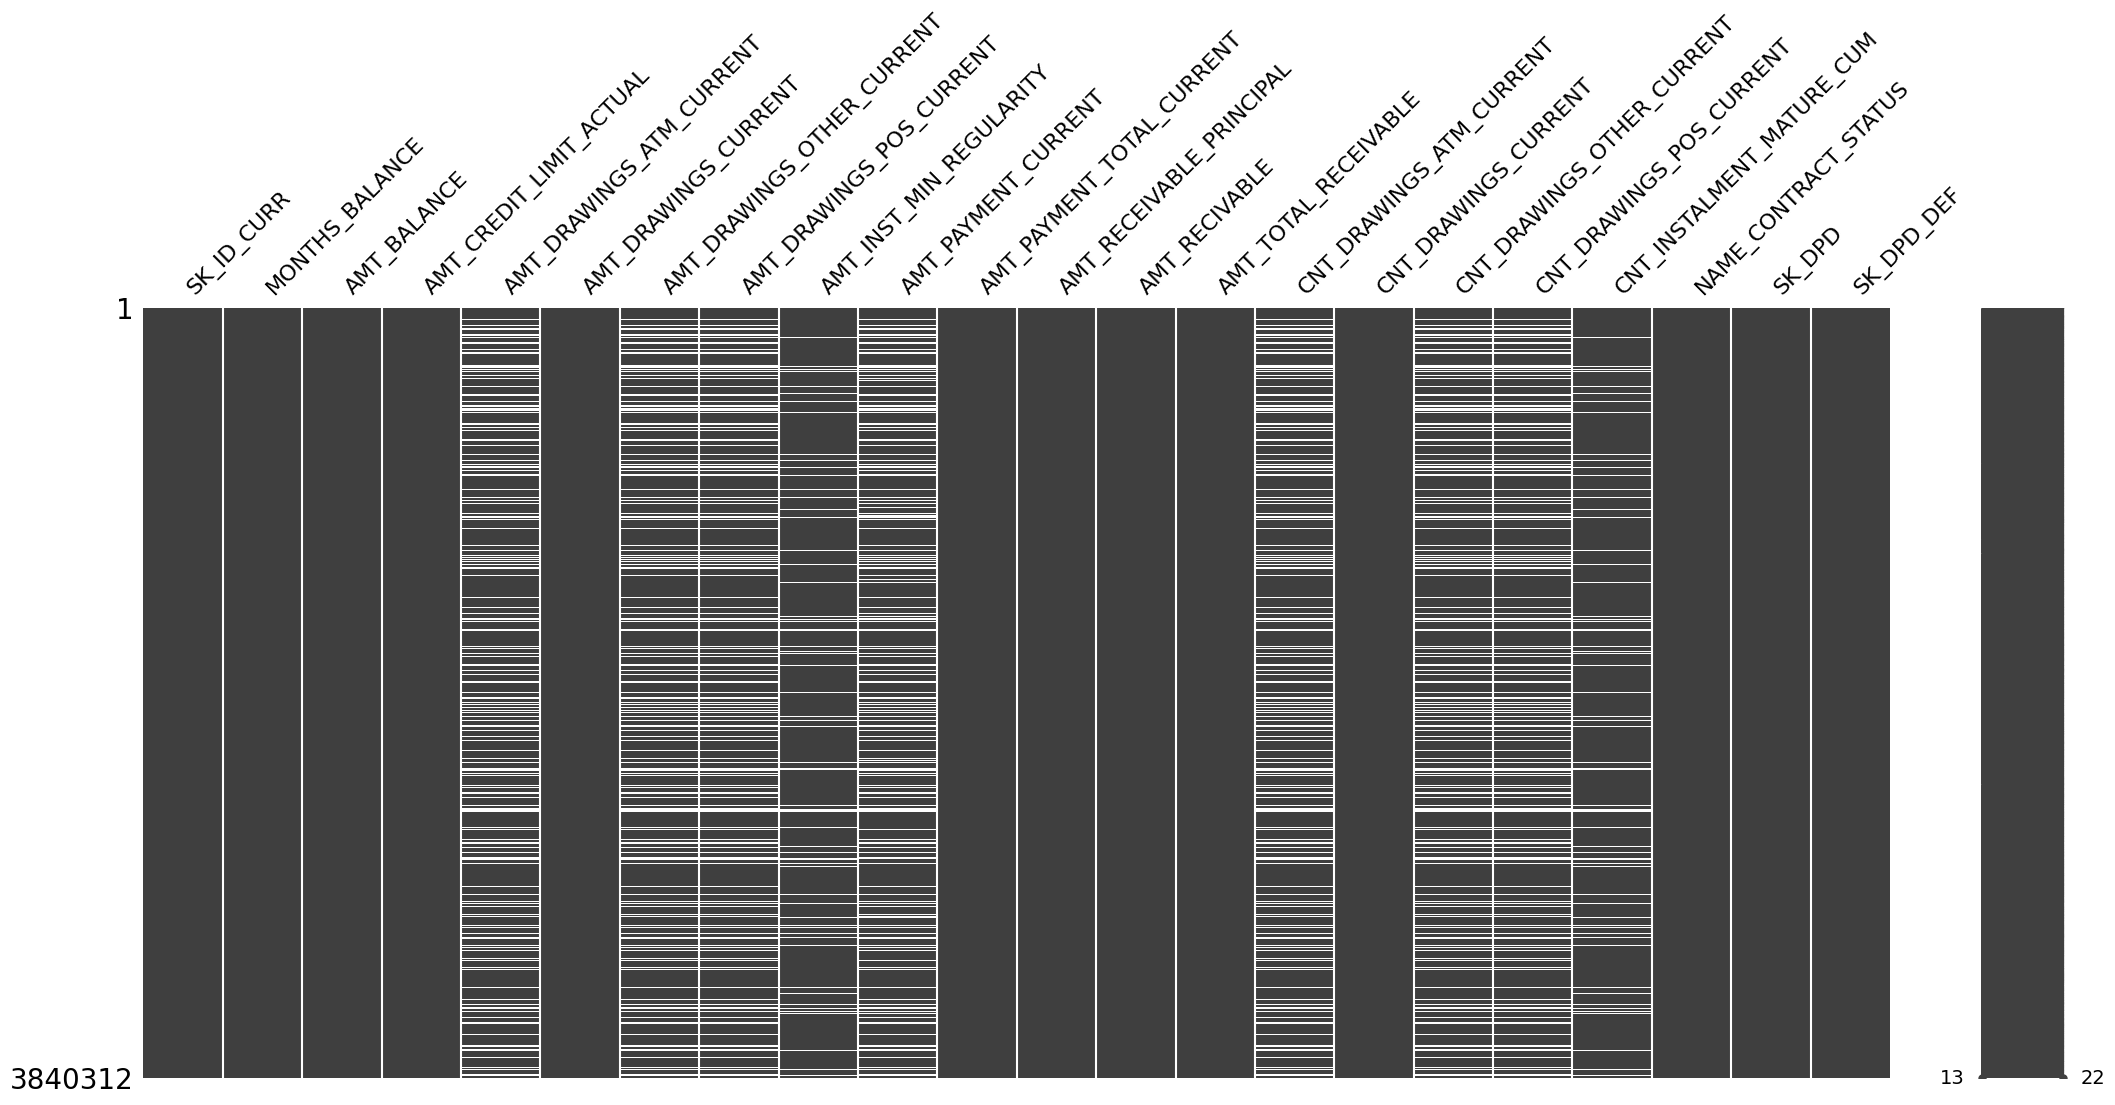

In [43]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(Data_credit_bal)

## Data POS CASH balance

In [44]:
# Affichage des 5 premières lignes de la table
Data_POS_CASH_bal.head()

SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE  \
SK_ID_PREV                                                                      
1803195         182943             -31            48.0                   45.0   
1715348         367990             -33            36.0                   35.0   
1784872         397406             -32            12.0                    9.0   
1903291         269225             -35            48.0                   42.0   
2341044         334279             -35            36.0                   35.0   

           NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
SK_ID_PREV                                           
1803195                  Active       0           0  
1715348                  Active       0           0  
1784872                  Active       0           0  
1903291                  Active       0           0  
2341044                  Active       0           0

In [45]:
# Extraction des lignes correspondantes à la table dans la table description
sub_table = Home_credit_desc[Home_credit_desc['Table']=='POS_CASH_balance.csv']

# Affichage de la description des variables de la table
for index, row in sub_table.iterrows():
    print(f"- {row['Row']} : {row['Description']}")

- SK_ID_PREV  : ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- SK_ID_CURR : ID of loan in our sample
- MONTHS_BALANCE : Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
- CNT_INSTALMENT : Term of previous credit (can change over time)
- CNT_INSTALMENT_FUTURE : Installments left to pay on the previous credit
- NAME_CONTRACT_STATUS : Contract status during the month
- SK_DPD : DPD (days past due) during the month of previous credit
- SK_DPD_DEF : DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit


<Axes: >

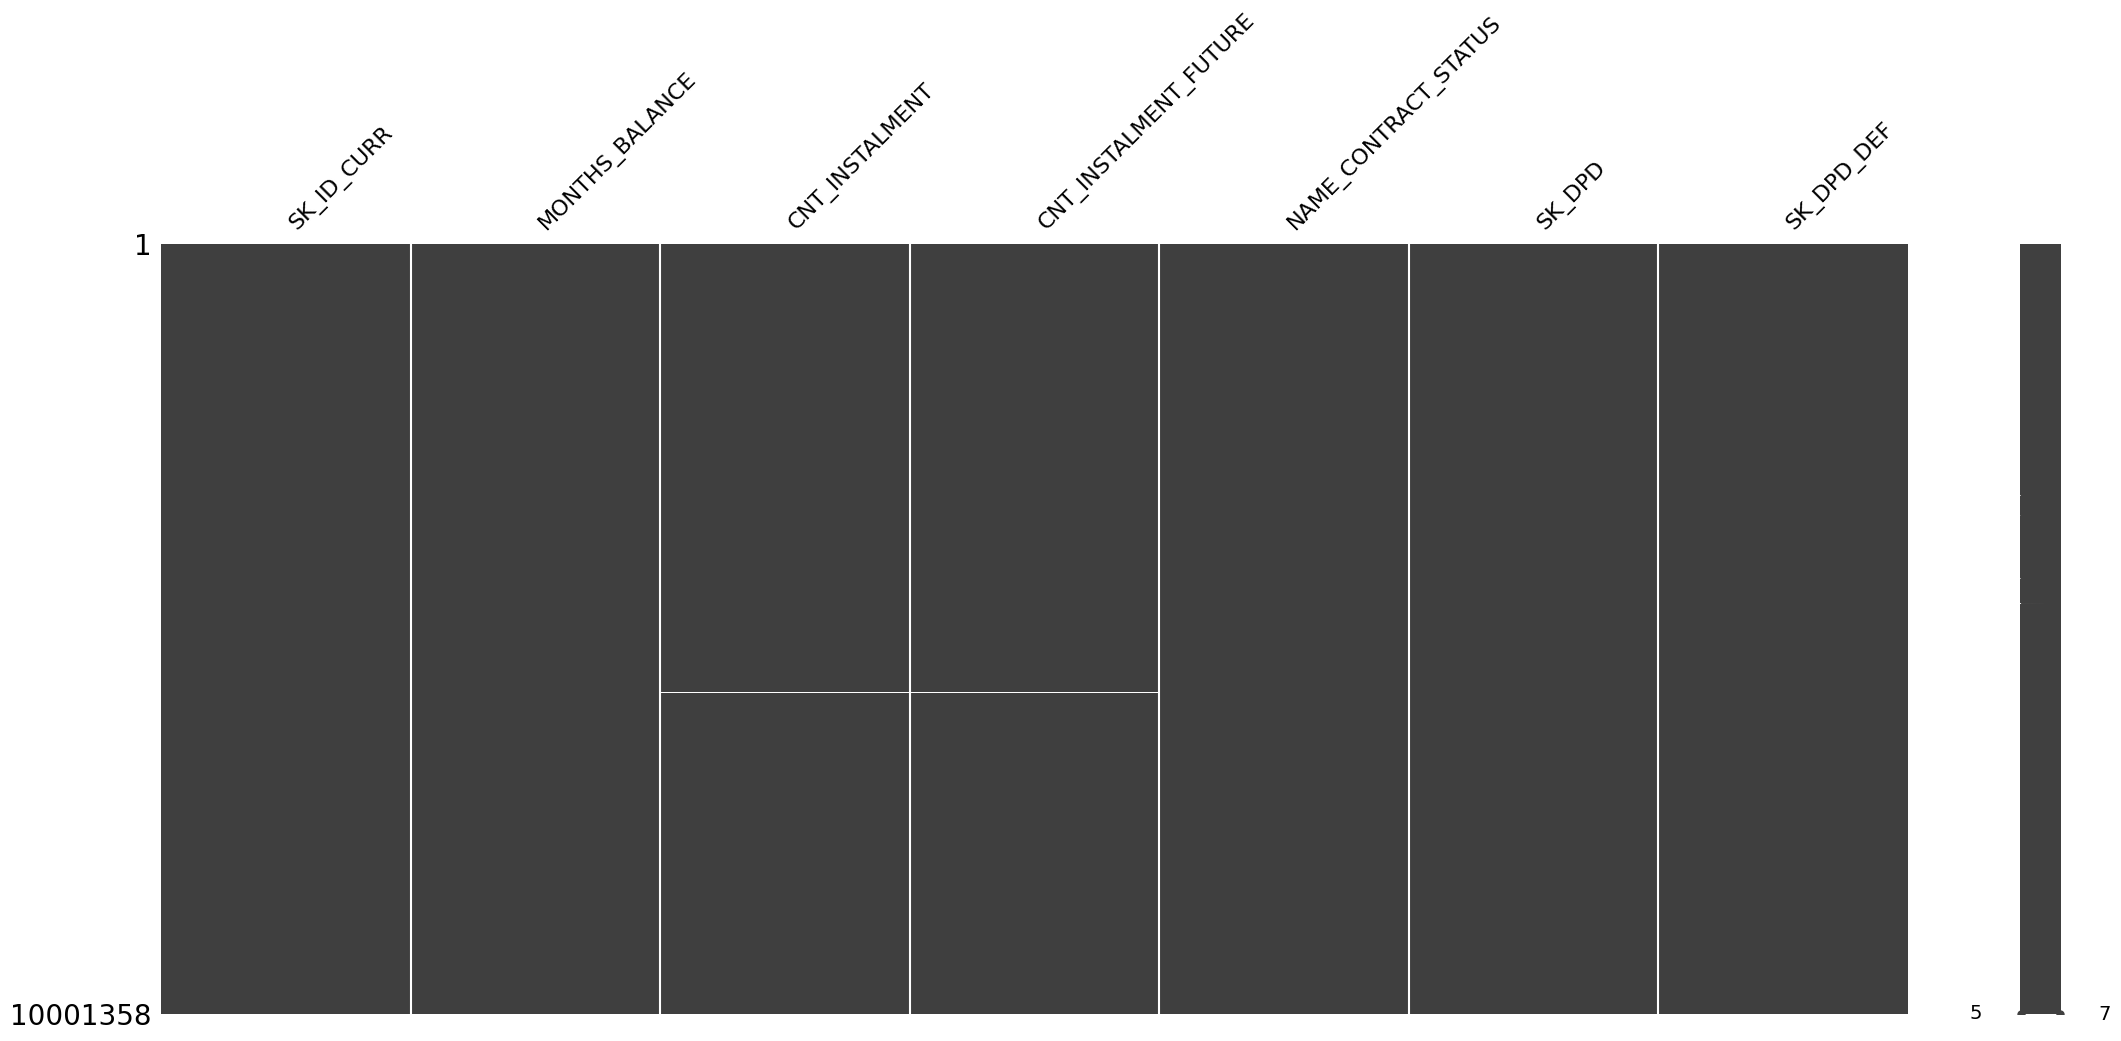

In [46]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(Data_POS_CASH_bal)

## Bureau

In [47]:
# Affichage des 5 premières lignes de la table
Data_bureau.head()

SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
SK_ID_CURR                                                            
215354           5714462        Closed      currency 1         -497   
215354           5714463        Active      currency 1         -208   
215354           5714464        Active      currency 1         -203   
215354           5714465        Active      currency 1         -203   
215354           5714466        Active      currency 1         -629   

            CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
SK_ID_CURR                                                               
215354                       0               -153.0             -153.0   
215354                       0               1075.0                NaN   
215354                       0                528.0                NaN   
215354                       0                  NaN                NaN   
215354                       0               1197.0                NaN   

            AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
SK_ID_CURR                                                               
215354                         NaN                   0         91323.0   
215354                         NaN                   0        225000.0   
215354                         NaN                   0        464323.5   
215354                         NaN                   0         90000.0   
215354                     77674.5                   0       2700000.0   

            AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
SK_ID_CURR                                                                      
215354                      0.0                   NaN                     0.0   
215354                 171342.0                   NaN                     0.0   
215354                      NaN                   NaN                     0.0   
215354                      NaN                   NaN                     0.0   
215354                      NaN                   NaN                     0.0   

                CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
SK_ID_CURR                                                    
215354      Consumer credit                -131          NaN  
215354          Credit card                 -20          NaN  
215354      Consumer credit                 -16          NaN  
215354          Credit card                 -16          NaN  
215354      Consumer credit                 -21          NaN

In [48]:
# Extraction des lignes correspondantes à la table dans la table description
sub_table = Home_credit_desc[Home_credit_desc['Table']=='bureau.csv']

# Affichage de la description des variables de la table
for index, row in sub_table.iterrows():
    print(f"- {row['Row']} : {row['Description']}")

- SK_ID_CURR : ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau 
- SK_BUREAU_ID : Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
- CREDIT_ACTIVE : Status of the Credit Bureau (CB) reported credits
- CREDIT_CURRENCY : Recoded currency of the Credit Bureau credit
- DAYS_CREDIT : How many days before current application did client apply for Credit Bureau credit
- CREDIT_DAY_OVERDUE : Number of days past due on CB credit at the time of application for related loan in our sample
- DAYS_CREDIT_ENDDATE : Remaining duration of CB credit (in days) at the time of application in Home Credit
- DAYS_ENDDATE_FACT : Days since CB credit ended at the time of application in Home Credit (only for closed credit)
- AMT_CREDIT_MAX_OVERDUE : Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
- CNT_CREDIT_PROLONG : How many times was t

Cette table regroupe les précédentes demandes de crédits du client réalisées dans une institution externe à Home Credit.  Là encore, on retrouve des variables d'identifiants (SK_ID_CURR, SK_BUREAU_ID) permettant de lier chaque demande de prêt actuelle aux précédents crédits externes associés. 

Certaines variables fournissent des informations sur le statut (CREDIT_ACTIVE) et type de crédit (CREDIT_TYPE). On retrouve également des informations sur les montants (AMT_CREDIT_SUM) les dettes (AMT_CREDIT_SUM_DEBT) et l'annuité (AMT_ANNUITY) associé à ces prédéents crédits

La table comprend de nouveau des variables temporelles renseignant sur la date de la demande par rapport au prêt actuel (DAYS_CREDIT), le retard à la date de demande (CREDIT_DAY_OVERDUE), la durée restante du crédit (DAYS_CREDIT_ENDDATE), le temps écoulé depuis la fin d’un crédit clos (DAYS_ENDDATE_FACT) et la date de mise à jour de l’information Bureau (DAYS_CREDIT_UPDATE). Enfin, CNT_CREDIT_PROLONG indique le nombre de fois que le crédit a été prolongé.

<Axes: >

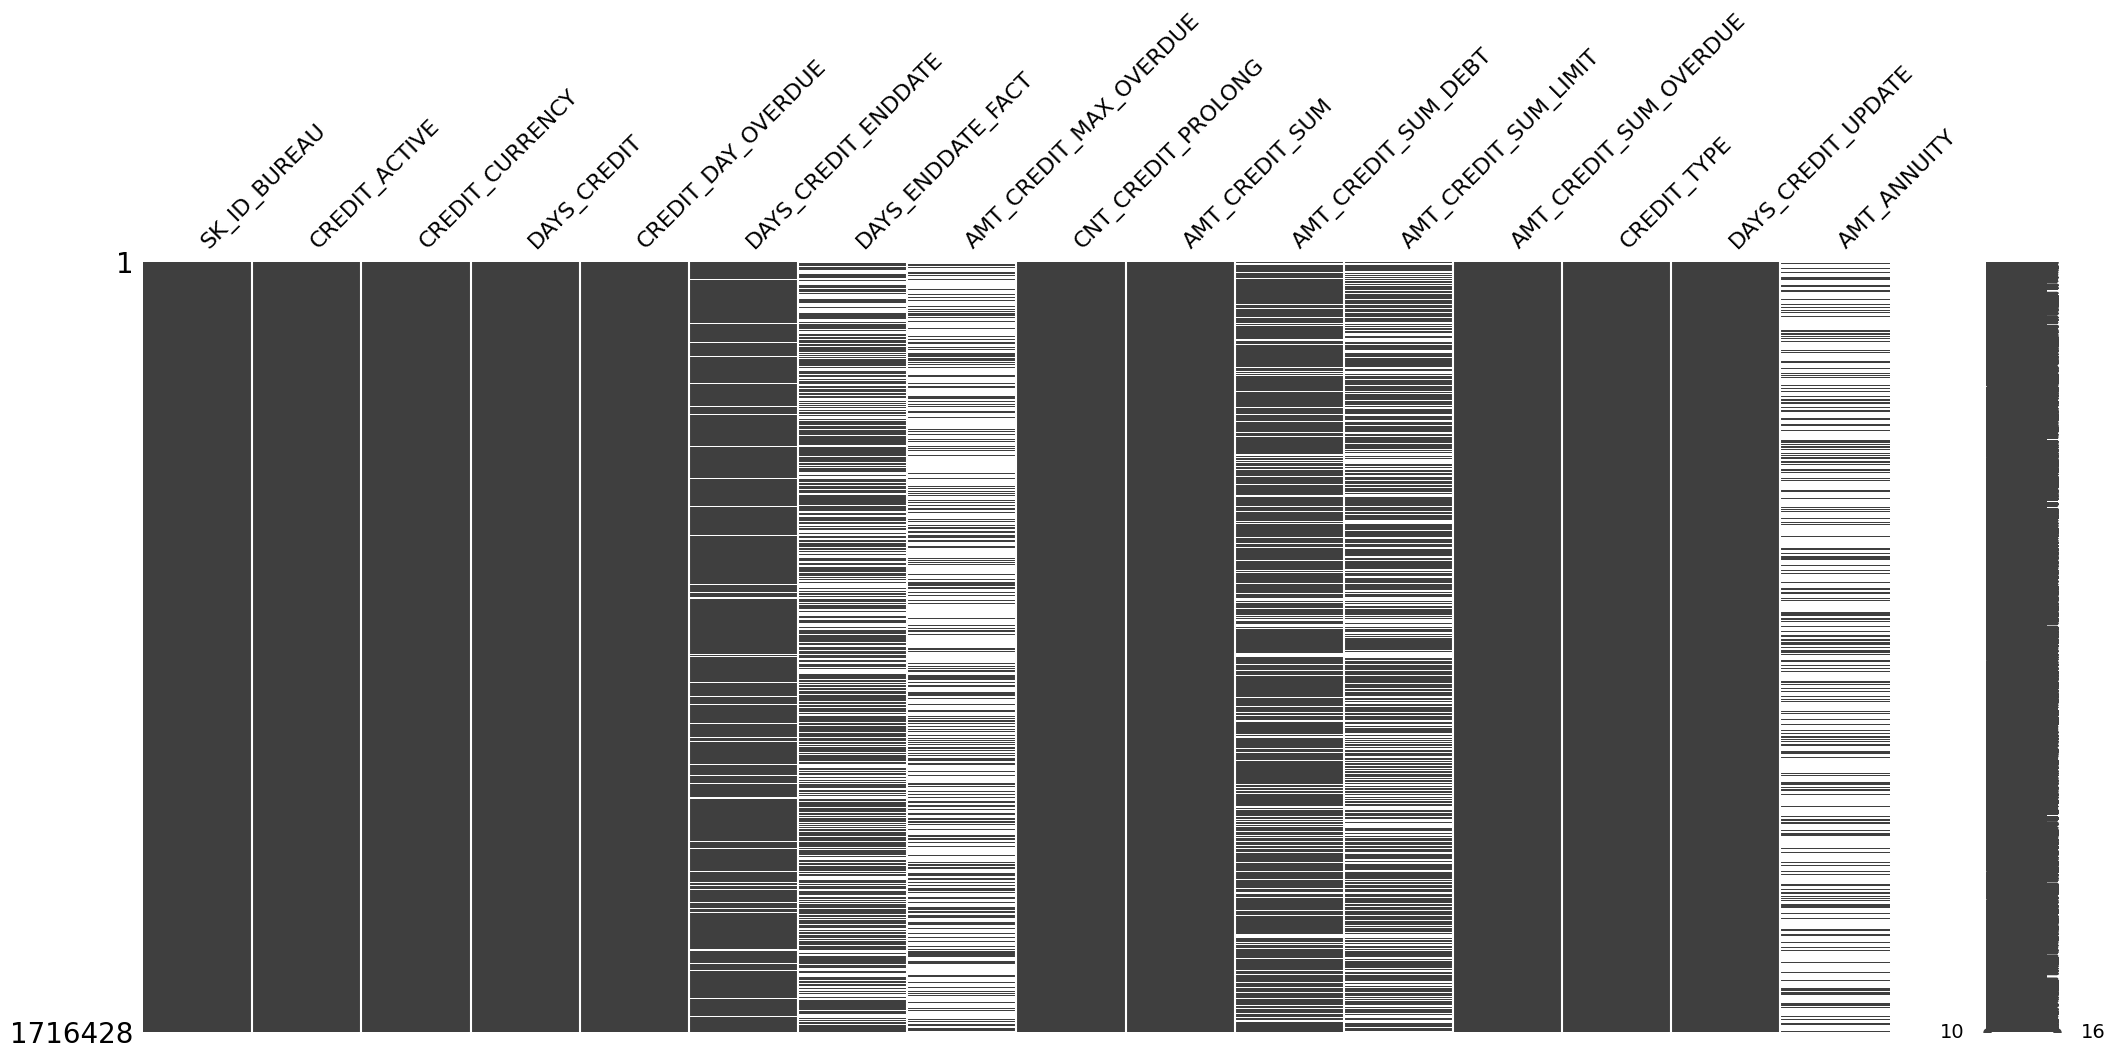

In [49]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(Data_bureau)

In [50]:
# Analyse stat de la table
Data_bureau.describe()

SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
count  1.716428e+06  1.716428e+06        1.716428e+06         1.610875e+06   
mean   5.924434e+06 -1.142108e+03        8.181666e-01         5.105174e+02   
std    5.322657e+05  7.951649e+02        3.654443e+01         4.994220e+03   
min    5.000000e+06 -2.922000e+03        0.000000e+00        -4.206000e+04   
25%    5.463954e+06 -1.666000e+03        0.000000e+00        -1.138000e+03   
50%    5.926304e+06 -9.870000e+02        0.000000e+00        -3.300000e+02   
75%    6.385681e+06 -4.740000e+02        0.000000e+00         4.740000e+02   
max    6.843457e+06  0.000000e+00        2.792000e+03         3.119900e+04   

       DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
count       1.082775e+06            5.919400e+05        1.716428e+06   
mean       -1.017437e+03            3.825418e+03        6.410406e-03   
std         7.140106e+02            2.060316e+05        9.622391e-02   
min        -4.202300e+04            0.000000e+00        0.000000e+00   
25%        -1.489000e+03            0.000000e+00        0.000000e+00   
50%        -8.970000e+02            0.000000e+00        0.000000e+00   
75%        -4.250000e+02            0.000000e+00        0.000000e+00   
max         0.000000e+00            1.159872e+08        9.000000e+00   

       AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
count    1.716415e+06         1.458759e+06          1.124648e+06   
mean     3.549946e+05         1.370851e+05          6.229515e+03   
std      1.149811e+06         6.774011e+05          4.503203e+04   
min      0.000000e+00        -4.705600e+06         -5.864061e+05   
25%      5.130000e+04         0.000000e+00          0.000000e+00   
50%      1.255185e+05         0.000000e+00          0.000000e+00   
75%      3.150000e+05         4.015350e+04          0.000000e+00   
max      5.850000e+08         1.701000e+08          4.705600e+06   

       AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE   AMT_ANNUITY  
count            1.716428e+06        1.716428e+06  4.896370e+05  
mean             3.791276e+01       -5.937483e+02  1.571276e+04  
std              5.937650e+03        7.207473e+02  3.258269e+05  
min              0.000000e+00       -4.194700e+04  0.000000e+00  
25%              0.000000e+00       -9.080000e+02  0.000000e+00  
50%              0.000000e+00       -3.950000e+02  0.000000e+00  
75%              0.000000e+00       -3.300000e+01  1.350000e+04  
max              3.756681e+06        3.720000e+02  1.184534e+08

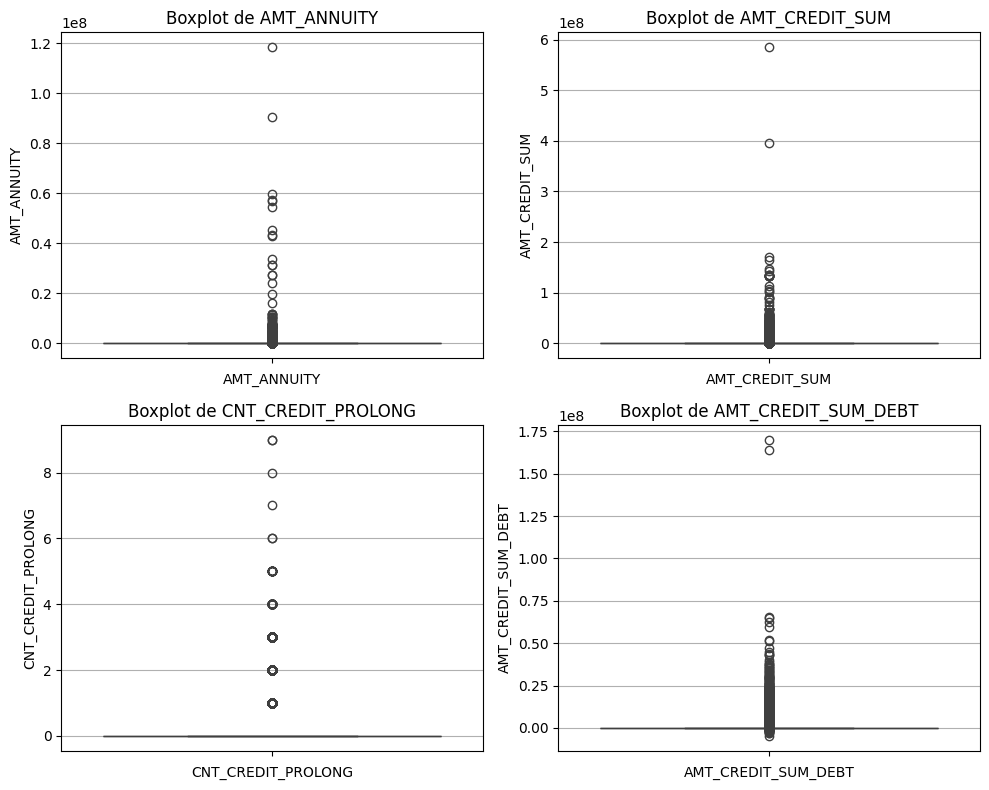

In [51]:
# Copie de la table
Data_bureau_plot = Data_bureau.copy()

# Appel de la fonction de visualisation des distributions des variables numériques
plot_variable_grid(Data_bureau_plot,
                   variables=["AMT_ANNUITY", "AMT_CREDIT_SUM", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM_DEBT"],
                   save_name="Distribution_variables_numériques_(Bureau)",
                   plot_type=sns.boxplot,
                   n_cols=2,
                   size_per_plot=(5, 4))

L'analyse de la distribution des variables représentant des montants présentent à nouveau des valeurs extrêmes s'éloignant fortement du troisième quartiles. Ici ces montants paraissent particulièrement élevés et sont nettement supérieurs à ceux observés dans la table des précédentes demandes internes. On va donc traiter ces valeurs et remplacer les valeurs dépassant un certain seuil par des NaN qui seront imputés ultérieurement. Concernant le nombre de prolongation de crédits, les valeurs observées ne paraissent pas aberrantes. 

In [52]:
# Analyse du nombre de valeur unique des variables catégorielles
Data_bureau[['CREDIT_TYPE', 'CREDIT_ACTIVE']].nunique()

CREDIT_TYPE      15
CREDIT_ACTIVE     4
dtype: int64

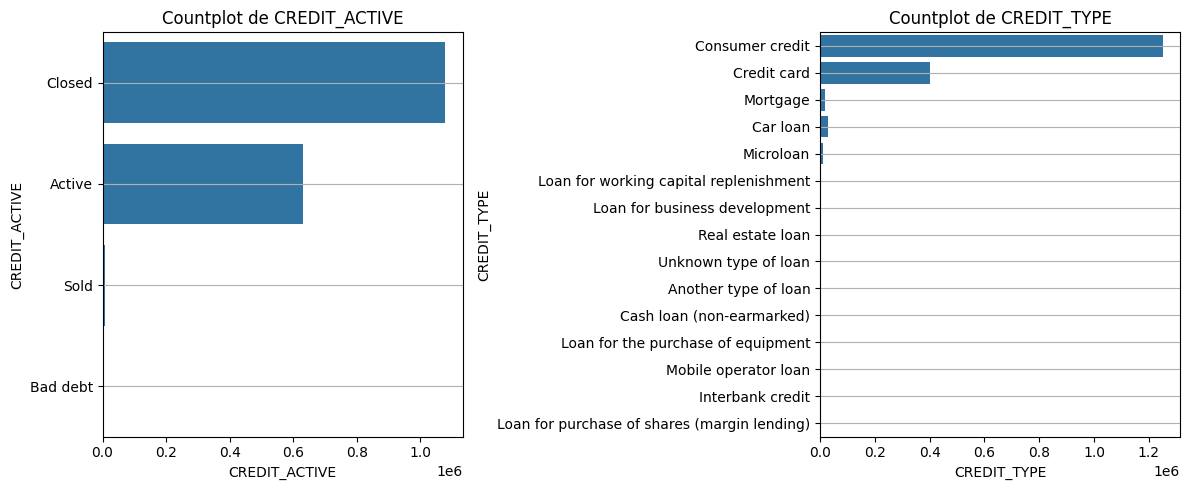

In [53]:
# Appel de la fonction de visualisation des distributions des variables numériques
plot_variable_grid(Data_bureau,
                   variables=["CREDIT_ACTIVE", "CREDIT_TYPE"],
                   save_name="Distrubtion_variables_numériques_(Bureau)",
                   plot_type=sns.countplot,
                   n_cols=2,
                   size_per_plot=(6, 5))

L'analyse de la distribution de la variable illustrant le statut des crédits indiquent que cette variable présente 4 modalités et que la majorité des crédits sont soit en cours soit cloturés. Un nombre minoritaire de crédits correspondent à des crédits en défaut de paiement ou à des crédits qui ont été revendu à une autre institution. Concernant la variable caractérisant le type de crédit on note un nombre plus important de modalité recensée pour les crédits externe de data bureau par rapport aux crédit internes. Il sera donc important d'homogénéiser le type de crédits des crédits internes et externes en regroupand certaines catégories. 

## Bureau balance

In [54]:
# Affichage des 5 premières lignes de la table
Data_bureau_bal.head()

MONTHS_BALANCE STATUS
SK_ID_BUREAU                       
5715448                    0      C
5715448                   -1      C
5715448                   -2      C
5715448                   -3      C
5715448                   -4      C

<Axes: >

C:\Users\33647\anaconda3\Lib\site-packages\matplotlib\image.py:183: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


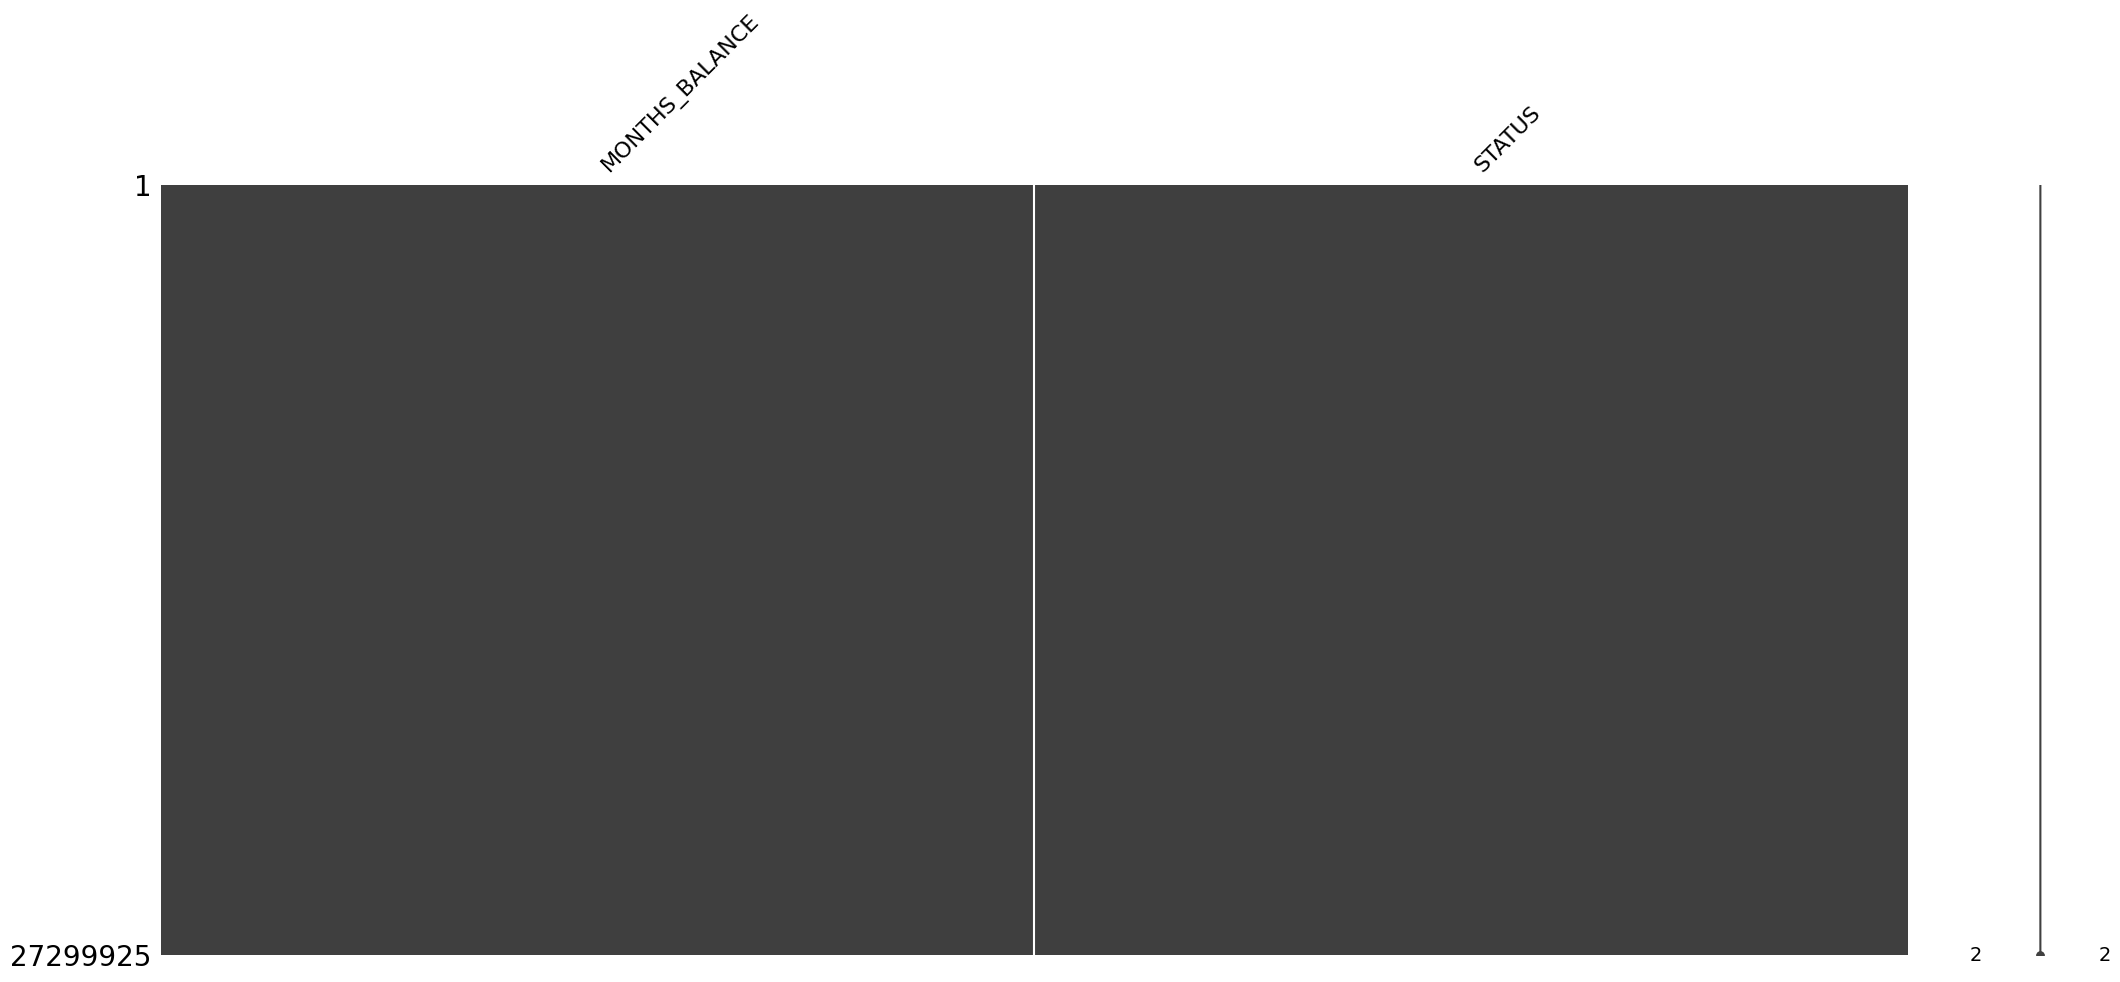

In [55]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(Data_bureau_bal)

In [56]:
# Extraction des lignes correspondantes à la table dans la table description
sub_table = Home_credit_desc[Home_credit_desc['Table']=='bureau_balance.csv']

# Affichage de la description des variables de la table
for index, row in sub_table.iterrows():
    print(f"- {row['Row']} : {row['Description']}")

- SK_BUREAU_ID : Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table 
- MONTHS_BALANCE : Month of balance relative to application date (-1 means the freshest balance date)
- STATUS : Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )


Cette table comprend peu de variables. Ces dernières variables permettent de suivre le statut mensuel des crédits externes. L’identifiant SK_BUREAU_ID relie les informations de la table aux crédit externe de la table Bureau. 

On retrouve une variable indiquant le mois du relevé par rapport à la date de demande (MONTHS_BALANCE) et une variable indiquant le statut du crédit pour le mois considéré (STATUS). 

In [57]:
# Visualisation des différentes modalités de la variable status
Data_bureau_bal['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

# Enrichissement de la table principale

## Construction de features relatives aux crédits internes et externes précédents

L'exploration des différentes tables a permis d'identifier un certains nombre d'informations qu'il serait pertinent d'ajouter à la table principale. 

Dans un premier temps, il serait intéressant d'inclure des informations générale sur le nombre de crédits précédemment accordés. On pourrait construire et ajouter des variables telles que:
- le montant total des credits accordés
- le montant mensuel à rembourser des précédents crédits
- la durée des précédents crédits
- le nombre de précédent crédits par type
- le ratio de crédit accordés par rapport à l'ensemble des demandes de crédits. Pour cela le nombre de crédits accordés et le nombre de demandes seront préalablement calculées puis supprimées.

Pour évaluer la situation financière actuelle du client, il serait également pertinent d’ajouter des informations relatives aux crédits actuellement actifs, telles que:
- le nombre de crédits actifs total
- le nombre de jours restant des crédits actifs
- la dette restante a payer des crédits actifs

Enfin, pour identifier les clients ayant déjà rencontré des difficultés de paiement, on pourrait inclure :
- le nombre de jour de retard moyen par crédits
- le nombre de crédits ayant dû être prolongés
- le ratio enter le nombre d'échances payées en retard et le nombre d'échéances total. Pour cela le nombre d'échéance payées en retard et le nombre d'échéances total seront préalablement calculées puis supprimées.

Actuellement les informations relatives aux précédents crédits sont dispatchées dans différentes tables selon si le crédit est interne ou externe. Afin d'avoir une seule variable pour l'ensemble des crédits internes et externes, les caractéristiques seront construites en trois temps: (1) extraction des informations relatives aux crédits internes, (2) extraction des informations relatives aux crédits externes, (3) concaténation informations relatives aux crédits interne et externe puis aggrégation des données par clients. 

Les variables représentant une même information étant nommées différemment selon l'origine des données (interne ou externe), le tableau ci dessous précise quelles variables ont été utilisées pour la construction de chacune des caractéristiques en fonction de la source.

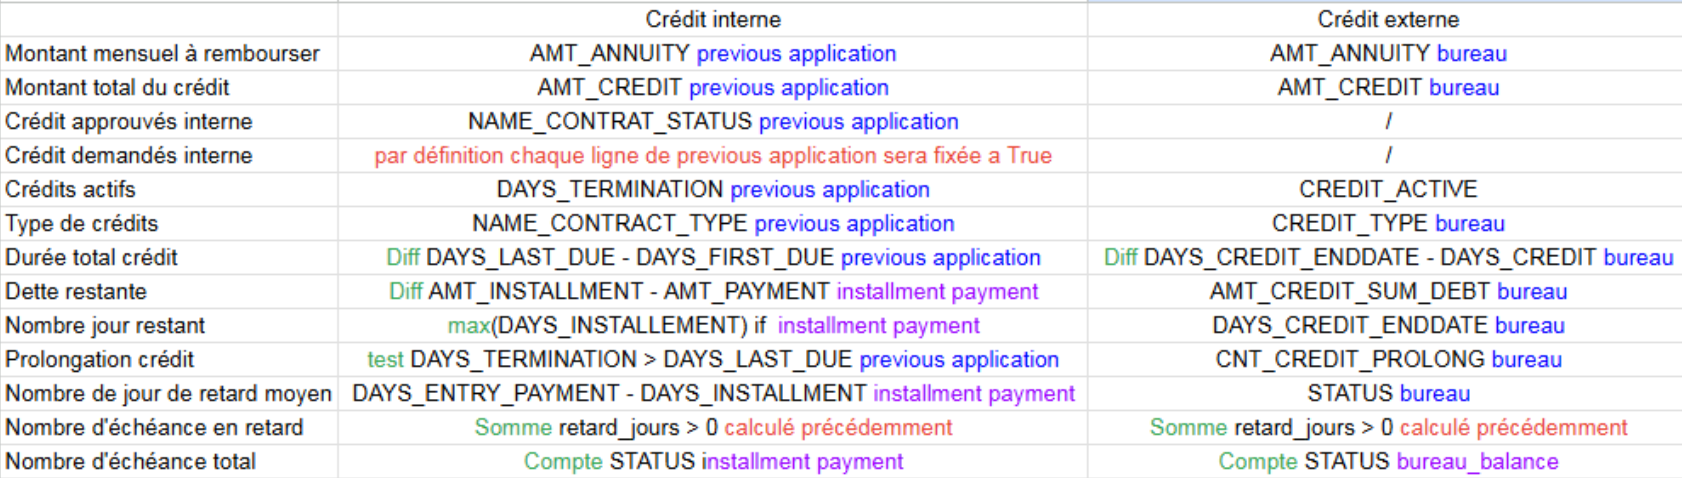

In [58]:
# Affichage du tableau de variables utilisées
display(Image(filename='../Images/Tableau.png'))

**Notes**
- L'analyse exploratoire à permis de noter que les types de crédits étaient annotés différement pour les crédits internes et les crédits externes. Il sera donc important pour cette variable d'uniformiser les différentes valeurs de type de contrats.
- Les tables de données relatives aux crédits externes ne contiennent que des crédits accordés au client. Comme nous souhaitons calculer un ratio mesurant la proportion de crédit approuvés par rapport à l'ensemble des demandes, les crédits externes ne seront pas pris en compte dans le calcule et se verront attribuer une valeur manquante. Cette stratégie de calcul permet d’éviter de surestimer le taux d’approbation en excluant les données pour lesquelles les demandes initiales ne sont pas connues.
- Pour la detection de crédits actifs internes, l'analyse exploratoire à révélé que la variable DAYS_TERMINATION comportait un certains nombre de valeurs manquantes. Pour compléter la détection des crédits actifs internes on pourra également utiliser la variable DAYS_INSTALLMENT de la table installment_payment en calculant la date la plus récente et proccéder de la même manière.

In [59]:
def feat_from_int_credit(data_prev_app, data_installments_pymnts):
    
    """
    Extrait des variables à partir des crédits internes.

    Cette fonction fusionne les informations des crédits internes (`data_prev_app`) et des paiements d'échéances
    (`data_installments_pymnts`) pour produire un jeu de variables agrégées et enrichies par crédit (`SK_ID_PREV`),
    incluant des indicateurs de statut (actif, approuvé), de dette restante, de retard de paiement, etc.

    Paramètres
        data_prev_app (pd.DataFrame) : Table des crédits internes contenant au minimum les colonnes suivantes : 
            'SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE',
            'DAYS_TERMINATION', 'DAYS_LAST_DUE', 'CNT_PAYMENT', 'AMT_ANNUITY', 'NAME_CONTRACT_STATUS'.
        data_installments_pymnts (pd.DataFrame): Table des paiements d’échéances, contenant les colonnes : 
            'SK_ID_PREV', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT'.


    Sortie
        pd.DataFrame: DataFrame contenant une ligne par crédit (`SK_ID_PREV`) avec les variables suivantes :
        - Identifiants : 'SK_ID_CURR', 'SK_ID_PREV'
        - NAME_CONTRACT_TYPE : type du contrat 
        - Active : booléen indiquant si le crédit est actif
        - Approuved : booléen indiquant si le crédit a été approuvé
        - AMT_ANNUITY : montant des annuités
        - montant_total : montant total dû sur la durée du crédit
        - duration_credit_days : durée totale du crédit en jours
        - dette_restante : dette restante estimée pour les crédits actifs
        - n_jours_restant : nombre de jours restants jusqu’à la fin du crédit (si actif)
        - credit_prolonge : booléen indiquant si le crédit a été prolongé (échéance repoussée)
        - n_jours_retard_moyen : retard moyen en jours sur les paiements 
        - nb_echeances_retard : nombre d'échances payées en retard
        - nb_total_echeance :  nombre total d'échéances
        - source : étiquette fixée à 'int' pour indiquer l’origine des crédits
    """

    # Copie des data
    data = data_prev_app.copy()
    
    #--------------------------------------------------------------------------
    # Clean des valeurs abbérantes
    #--------------------------------------------------------------------------
    
    # Définition des variables à cleaner
    var_to_clean = ['DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']

    # Remplacement des valeurs abérantes par des valeurs manquantes
    Data_prev_app[var_to_clean] = Data_prev_app[var_to_clean].replace(365243, np.nan)
    
    #--------------------------------------------------------------------------
    # Infos crédits: type, status, nombre
    #--------------------------------------------------------------------------
    
    # Ajout de la source des crédit
    data['source'] = 'int'
    
    # Mapping types de crédits
    map_int = {"XNA": "Another type of loan"}
    data["NAME_CONTRACT_TYPE"] = data["NAME_CONTRACT_TYPE"].replace(map_int)
    
    # Detection des crédits acceptés
    data['Credit_approuved'] = data['NAME_CONTRACT_STATUS'].apply(
        lambda x: x == 'Approved' if pd.notna(x) else np.nan)
    
    # Detection des crédits demandé
    data['Credit_demande'] = True

    # Calcul du montant total des crédits
    data['montant_total'] = data['AMT_CREDIT']
    
    # Calcul de la durée total de crédits en nombre de jours
    data["duration_credit_days"] = data["DAYS_LAST_DUE"] - data["DAYS_FIRST_DUE"]
    
    # Detection des crédits actifs
    data['Credit_actifs'] = data['DAYS_TERMINATION'].apply(
        lambda x: x > 0  if pd.notna(x) else np.nan)
    
    # Détermination du dernier jour d’échéance prévu
    last_payment = (
        data_installments_pymnts
        .groupby("SK_ID_PREV")["DAYS_INSTALMENT"]
        .max()
        .reset_index(name="last_instalment_day"))
    
    # Ajout du dernier jour d'échéance prévu dans la table
    data = data.merge(last_payment, on="SK_ID_PREV", how="left")
    
    # Remplissage des valeurs manquantes des crédits actifs (=crédits dont la dernière échéance est après la date de demande)
    data['Credit_actifs'] = data['Credit_actifs'].fillna(data['last_instalment_day'].map(
        lambda x: True if x > 0 else (False if pd.notna(x) else np.nan)))
    
    #--------------------------------------------------------------------------
    # Infos complémentaires crédits actifs (durée restante, montant dette)
    #--------------------------------------------------------------------------

    # Calcul de la durée restante en nombre de jours des crédits actifs
    data["n_jours_restant"] = data.apply(
        lambda row: row["last_instalment_day"] if row["Credit_actifs"] is True
        else (np.nan if pd.isna(row["Credit_actifs"]) else 0),axis=1)
    
    # Calcul de la dette restante des crédits actifs
    montant_prevue = data_installments_pymnts.groupby("SK_ID_PREV")["AMT_INSTALMENT"].sum()
    montant_payé = data_installments_pymnts.groupby("SK_ID_PREV")["AMT_PAYMENT"].sum()
    dette = (montant_prevue - montant_payé).reset_index(name="dette_restante")
    
    # Fusion de la variable aux données
    data = data.merge(dette, on="SK_ID_PREV", how="left")
    
    #--------------------------------------------------------------------------
    # Infos relatives aux retards
    #--------------------------------------------------------------------------

    # Détection prolongation
    data["credit_prolonge"] = data.apply(
        lambda row: True if pd.notna(row["DAYS_TERMINATION"]) and pd.notna(row["DAYS_LAST_DUE"]) and row["DAYS_TERMINATION"] > row["DAYS_LAST_DUE"]
        else False if pd.notna(row["DAYS_TERMINATION"]) and pd.notna(row["DAYS_LAST_DUE"]) else np.nan, axis=1)
    
    # Calcul du nombre de jours de retards
    data_installments = data_installments_pymnts.copy()
    data_installments["n_retard_jours"] = (data_installments["DAYS_ENTRY_PAYMENT"] - data_installments["DAYS_INSTALMENT"]).clip(lower=0)
    
    # Detection des échéances avec du retard
    data_installments["has_retard"] = data_installments["n_retard_jours"] > 0

    # Agrégation des données par crédits
    retard_agg = (
        data_installments.groupby("SK_ID_PREV")
        .agg(
            nb_echeances_retard=("has_retard", "sum"),
            nb_total_echeances=("has_retard", "count"),
            n_jours_retard_moyen=("n_retard_jours", "mean")  
        )
        .reset_index()
    )
    
    # Fusion des données dans data
    data = data.merge(retard_agg, on="SK_ID_PREV", how="left")

    #--------------------------------------------------------------------------
    # Selecgtion des features finales
    #--------------------------------------------------------------------------

    # Sélection des features finales
    features = data[[
        'SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'Credit_actifs', 'Credit_approuved', 'Credit_demande',
        'AMT_ANNUITY', 'montant_total', 'duration_credit_days', 'dette_restante',
        'n_jours_restant', 'credit_prolonge', 'n_jours_retard_moyen',
        'nb_echeances_retard', 'nb_total_echeances', 'source'
    ]]

    return features


In [60]:
def feat_from_ext_credit(data_bureau, data_bureau_balance):

    """
    Extrait des variables à partir des crédits externe.

    Cette fonction fusionne les informations des crédits externe (data_bureau) et des paiements d'échéances
    (data_installments_balance) pour produire un jeu de variables agrégées et enrichies par crédit (SK_ID_PREV),
    incluant des indicateurs de statut (actif, approuvé), de dette restante, de retard de paiement, etc.

    Paramètres
        data_bureau (pd.DataFrame) : Table des crédits internes contenant au minimum les colonnes suivantes : 
            'SK_BUREAU_ID', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE',
            'DAYS_TERMINATION', 'DAYS_LAST_DUE', 'CNT_PAYMENT', 'AMT_ANNUITY', 'NAME_CONTRACT_STATUS'.
        data_bureau_balance (pd.DataFrame): Table des paiements d’échéances, contenant les colonnes : 
            'SK_ID_PREV', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT'.

    Sortie
        pd.DataFrame: DataFrame contenant une ligne par crédit (`SK_ID_PREV`) avec les variables suivantes :
        - Identifiants : 'SK_ID_CURR', 'SK_ID_PREV'
        - NAME_CONTRACT_TYPE : type du contrat 
        - Active : booléen indiquant si le crédit est actif
        - Approuved : booléen indiquant si le crédit a été approuvé
        - AMT_ANNUITY : montant des annuités
        - montant_total : montant total dû sur la durée du crédit
        - duration_credit_days : durée totale du crédit en jours
        - dette_restante : dette restante estimée pour les crédits actifs
        - n_jours_restant : nombre de jours restants jusqu’à la fin du crédit (si actif)
        - credit_prolonge : booléen indiquant si le crédit a été prolongé (échéance repoussée)
        - n_jours_retard_moyen : retard moyen en jours sur les paiements 
        - nb_echeances_retard : nombre d'échances payées en retard
        - nb_total_echeance :  nombre total d'échéances
        - source : étiquette fixée à 'int' pour indiquer l’origine des crédits
    """
    
    # Copie des données
    data = data_bureau.copy().reset_index()
    
    #--------------------------------------------------------------------------
    # Clean des valeurs abbérantes
    #--------------------------------------------------------------------------
    
    data.loc[data['AMT_ANNUITY']> 1000000, 'AMT_ANNUITY'] = np.nan
    data.loc[data['AMT_CREDIT_SUM']> 3000000, 'AMT_ANNUITY'] = np.nan
    data.loc[data['AMT_CREDIT_SUM_DEBT']> 3000000, 'AMT_ANNUITY'] = np.nan
    
    #--------------------------------------------------------------------------
    # Infos crédits: type, status, nombre
    #--------------------------------------------------------------------------
    
    # Ajout de la source des crédits
    data["source"] = "ext"
    
    # Création d'un dictionnaire pour faciliter le regroupement des types de crédits
    map_int = {
        # Regrouper en "Another type of loan"
        'Unknown type of loan': 'Another type of loan',
        'Interbank credit': 'Another type of loan',
        'Mobile operator loan': 'Another type of loan',
        'Loan for purchase of shares (margin lending)': 'Another type of loan',

        # Regrouper en "business credit"
        'Loan for the purchase of equipment': 'business credit',
        'Loan for business development': 'business credit',
        'Loan for working capital replenishment': 'business credit',

        # Regrouper en "Immo_credit"
        'Mortgage': 'Immo_credit',
        'Real estate loan': 'Immo_credit',

        # Regrouper en "Consumer loans"
        'Credit card': 'Consumer loans',
        'Car loan': 'Consumer loans',
        'Cash loan (non-earmarked)': 'Consumer loans'
    }
    
    # Mapping des types de crédits  
    data["NAME_CONTRACT_TYPE"] = data["CREDIT_TYPE"].replace(map_int)

    # Detection des crédits acceptés
    data['Credit_approuved'] = np.nan
    
    # Detection des crédits demandés
    data['Credit_demande'] = np.nan
    
    # Calcul du montant total des crédit
    data["montant_total"] = data["AMT_CREDIT_SUM"]
    
    # Detection des crédits actifs 
    data["Credit_actifs"] = data['CREDIT_ACTIVE'].apply(
        lambda x: x == 'Active' if pd.notna(x) else np.nan)
    
    # Modification du nom de la variable identifiant
    data['SK_ID_PREV'] = data['SK_ID_BUREAU']
    
    #--------------------------------------------------------------------------
    # Infos complémentaires crédits actifs (durée restantes, montant dette)
    #--------------------------------------------------------------------------

    # Calcul de la durée restante en nombre de jours des crédits actifs
    data["n_jours_restant"] = data["DAYS_CREDIT_ENDDATE"].apply(lambda x: x if x > 0 else 0)
        
    # Calcul de la dette restante des crédits actifs
    data["dette_restante"] = data["AMT_CREDIT_SUM_DEBT"]
    
    # Calcul de la durée total de crédits en nombre de jours
    data["duration_credit_days"] = (data["DAYS_CREDIT_ENDDATE"] - data["DAYS_CREDIT"]).abs()    
    
    #--------------------------------------------------------------------------
    # Infos relatives au retards
    #--------------------------------------------------------------------------

    # Détection prolongation
    data["credit_prolonge"] = data['CNT_CREDIT_PROLONG'].apply(
        lambda x: x > 0 if pd.notna(x) else np.nan)

    # Copie des datas de bureau_balance
    data_bureau_bal = data_bureau_balance.copy()

    # Conversion des codes en nombre de jours de retards (approximatifs)
    status_to_days = {
        "0": 0,
        "1": 30,
        "2": 60,
        "3": 90,
        "4": 120,
        "5": 150,
        "C": 0,
        "X": 0
    }
    
    # Conversion du statut en nombre de jours de retard
    data_bureau_bal["retard_jours"] = data_bureau_bal["STATUS"].map(status_to_days)

    # Identification des paiements en retards
    data_bureau_bal["has_retard"] = data_bureau_bal['retard_jours'].apply(
        lambda x: x > 0 if pd.notna(x) else np.nan)
    
    # Aggregation des données par crédits
    retard_agg = (
        data_bureau_bal.groupby("SK_ID_BUREAU")
        .agg(
            n_jours_retard_moyen=("retard_jours", "mean"),
            nb_echeances_retard=("has_retard", "sum"),
            nb_total_echeances=("STATUS", "count")
        )
        .reset_index()
    )

    # Fusion dans data
    data = data.merge(retard_agg, on="SK_ID_BUREAU", how="left")
    
    #--------------------------------------------------------------------------
    # Selecgtion des features finales
    #--------------------------------------------------------------------------

    # Sélection features
    features = data[[
        'SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'Credit_actifs', 'Credit_approuved', 'Credit_demande',
        'AMT_ANNUITY', 'montant_total', 'duration_credit_days', 'dette_restante',
        'n_jours_restant', 'credit_prolonge', 'n_jours_retard_moyen',
        'nb_echeances_retard', 'nb_total_echeances', 'source'
    ]]

    return features


In [61]:
# Appel de la fonction pour construire les caractéristiques des crédits précédents internes
feat_int = feat_from_int_credit(Data_prev_app, Data_intallment_pymnts )

# Appel de la fonction pour construire les caractéristiques des crédits précédents externes
feat_ext = feat_from_ext_credit(Data_bureau, Data_bureau_bal)

## Analyses des valeurs manquantes des caractéristiques construites

### Crédits internes

<Axes: >

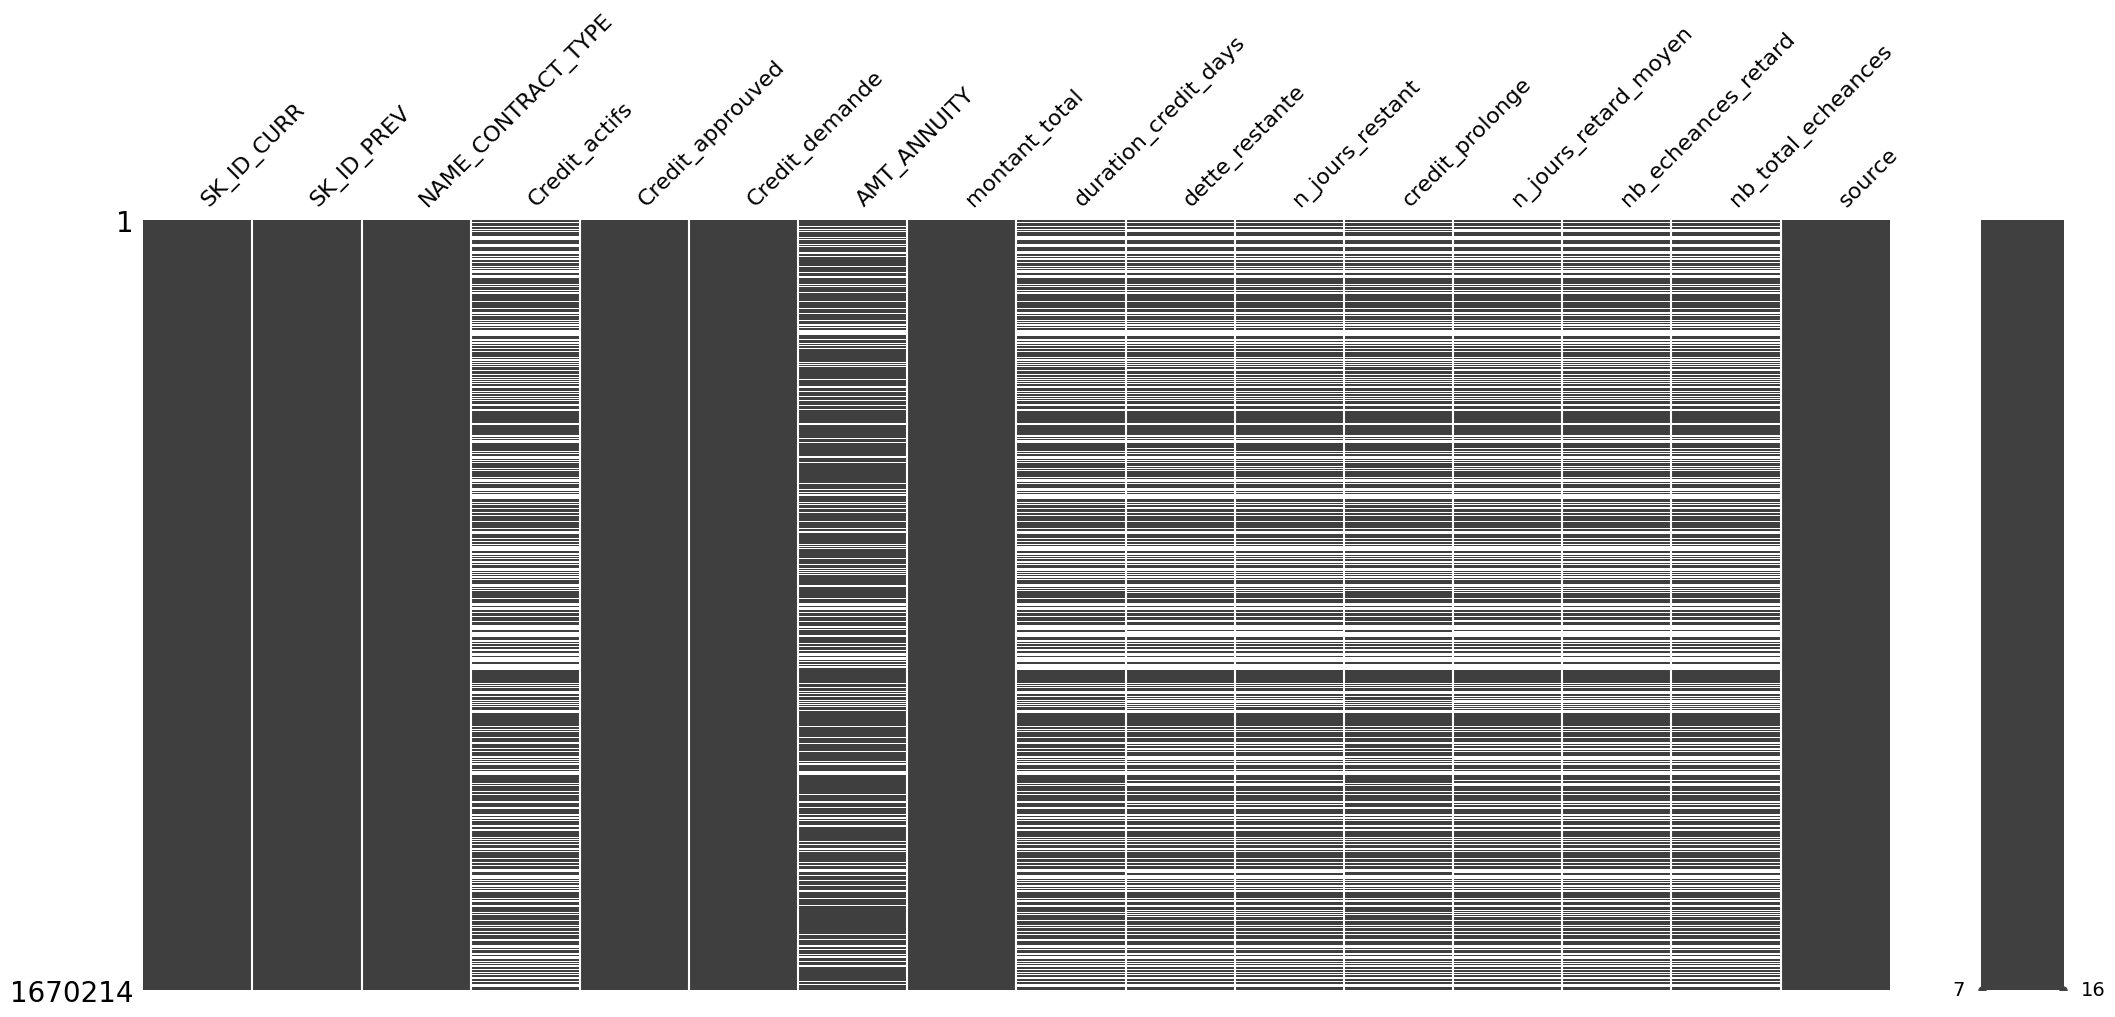

In [62]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(feat_int)

In [63]:
# Appel de la fonction
missing_values_table(feat_int)

La dataframe contient 16 colonnes.
Il y a 10 colonnes qui possèdent des valeurs manquantes.


Missing Values  % of Total Values
n_jours_retard_moyen          711380               42.6
dette_restante                711309               42.6
nb_echeances_retard           711309               42.6
nb_total_echeances            711309               42.6
n_jours_restant               706767               42.3
duration_credit_days          673065               40.3
credit_prolonge               673065               40.3
Credit_actifs                 672671               40.3
AMT_ANNUITY                   372235               22.3
montant_total                      1                0.0

On remarque que 10 variables comportent des valeurs manquantes. Ces valeurs manquantes pourraient s'expliquer par différents facteurs et ne pas être forcément génantes. Par exemple, pour les crédits refusés, il est logique que certaines variables relatives aux crédits accordés telle que le montant à rembourser ou, la durée du crédit ne soient pas renseignées. De même, pour les crédits non actifs, les variables spécifiques aux crédits en cours comme le nombre de jours restant ou la dette restante n'ont pas pu être renseignées. Il est donc important d'analyser le taux de valeur manquantes des variables en prenant en compte ces aspects la.

In [64]:
# Liste des variables à analyser
variables = ['Credit_actifs', 'duration_credit_days', 'AMT_ANNUITY', 'credit_prolonge', 
             'dette_restante', 'n_jours_restant', 'n_jours_retard_moyen',
             'nb_echeances_retard', 'nb_total_echeances']

# Nombre de ligne total
total_lignes = len(feat_int)  

# Initialisation de la liste de résultat
result = []

# Pour chaque variable
for var in variables:
    
    # Isolation des observations pour lesquelles les valeurs sont manquantes
    temp = feat_int[feat_int[var].isna()]
    
    # Compte du nombre crédits approuvés et non approuvés
    counts = temp['Credit_approuved'].value_counts(dropna=False)
    
    # Création d'une ligne avec le nom de la variable
    row = {'variable': var}
    
    # Pour chaque index dans counts
    for val in counts.index:
        
        # Calcul de la proportion sur l'ensemble du dataset
        row[f"approuved_{val}"] = counts[val] / total_lignes *100 if total_lignes > 0 else 0  
    
    # Mise a jour de la liste
    result.append(row)

# Conversion de la liste en dataframe
df_result = pd.DataFrame(result).fillna(0)

# Affichage des résultats
df_result

variable  approuved_False  approuved_True
0         Credit_actifs        37.925260        2.349280
1  duration_credit_days        37.925260        2.372870
2           AMT_ANNUITY        22.286186        0.000479
3       credit_prolonge        37.925260        2.372870
4        dette_restante        37.925260        4.662636
5       n_jours_restant        37.925260        4.390695
6  n_jours_retard_moyen        37.925260        4.666887
7   nb_echeances_retard        37.925260        4.662636
8    nb_total_echeances        37.925260        4.662636

Les taux de valeurs manquantes calculés en fonction du status accordé/non accordé des crédits confirment que la majorité des valeurs manquantes est associée aux crédits non accordés et que ce taux reste en dessous de 5% pour toutes les variables associées aux crédits accordés. Lors de l'imputation des valeurs manquantes, il sera important de prendre en compte le fait qu'un crédit ait été accordés ou non. Pour les clients ayant eu par le passé des crédits accordées on pourra faire une imputation via une mesure statistiques (médiane ou moyenne), et pour les clients n'ayant eu aucun crédit accordé dans le passé on pourra imputer les valeurs manquantes par une valeur sentinelle comme -1 pour différencier ces cas et ne pas introduire de biais. 

### Crédits externes

<Axes: >

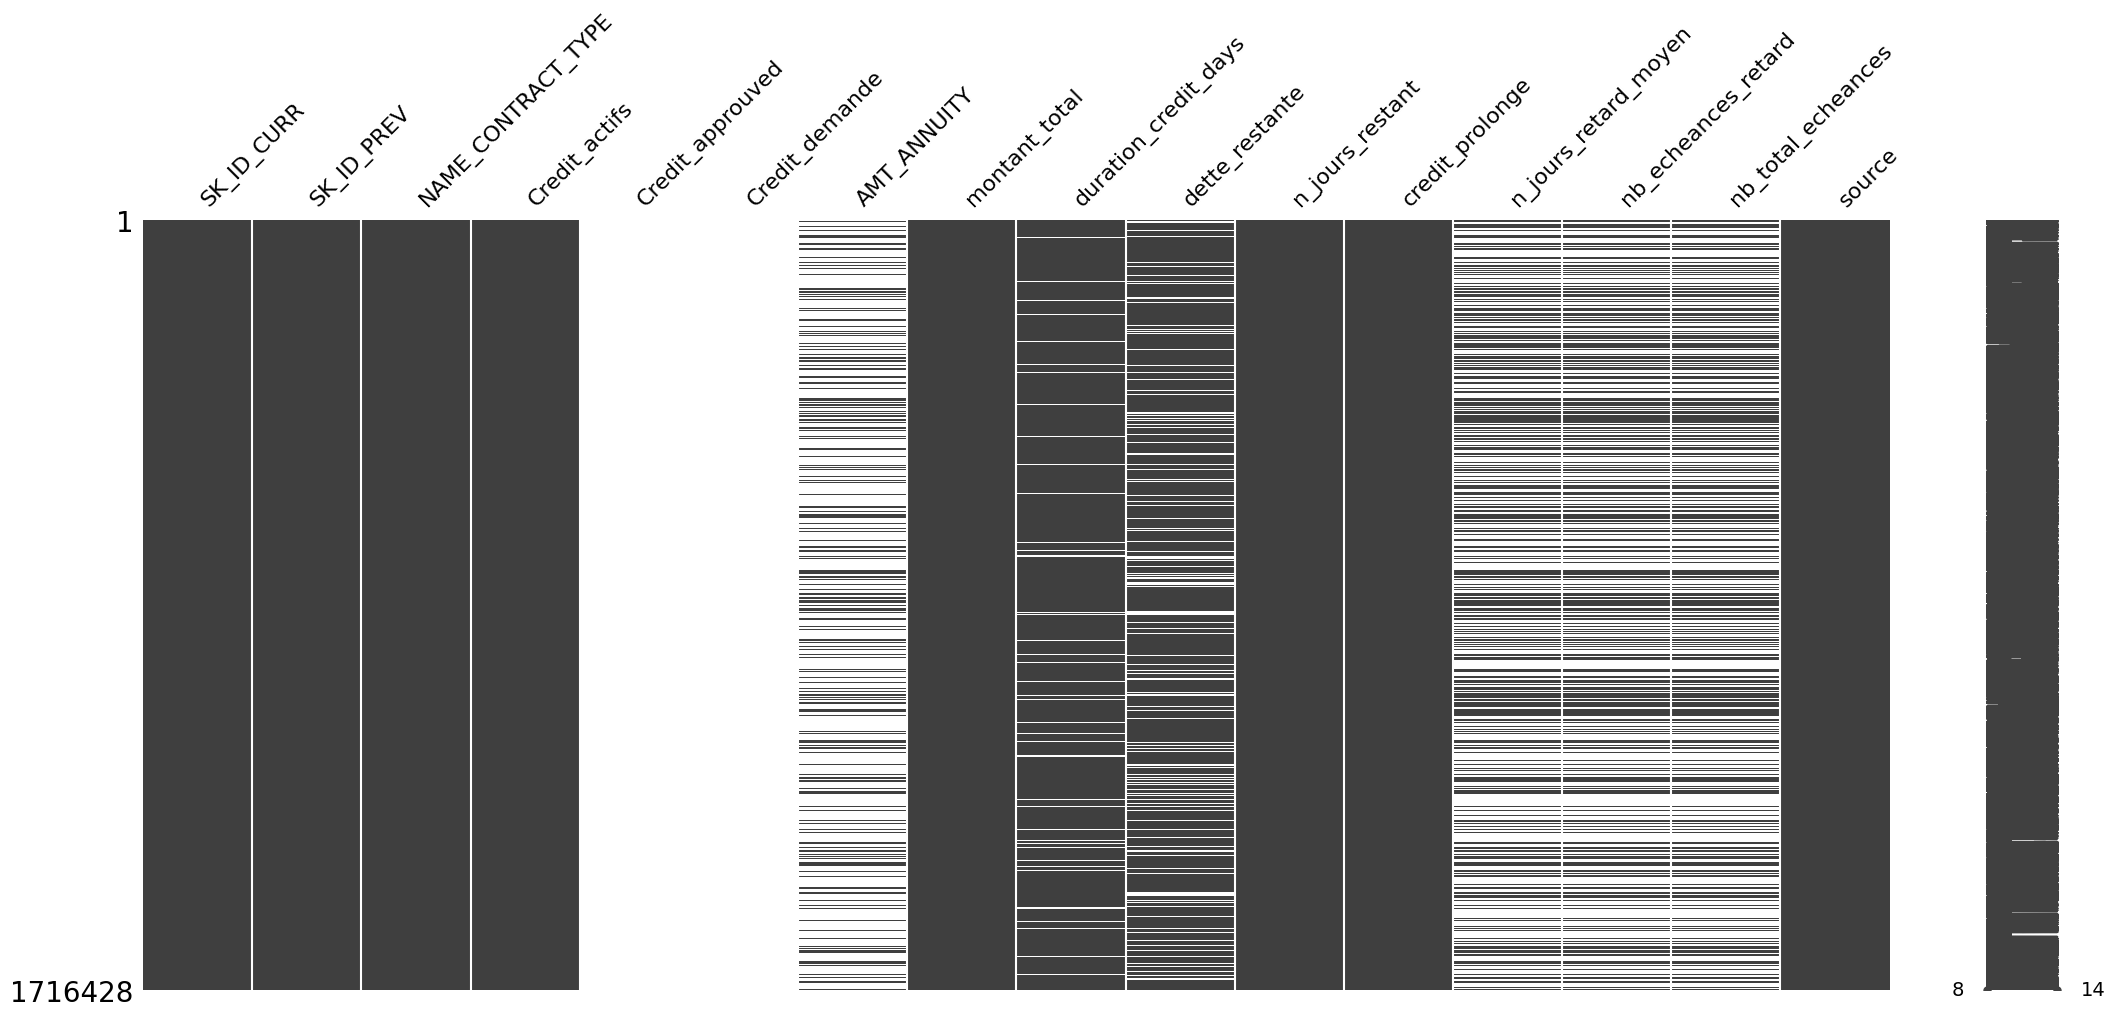

In [65]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(feat_ext)

In [66]:
# Appel de la fonction
missing_values_table(feat_ext)

La dataframe contient 16 colonnes.
Il y a 9 colonnes qui possèdent des valeurs manquantes.


Missing Values  % of Total Values
Credit_approuved             1716428              100.0
Credit_demande               1716428              100.0
AMT_ANNUITY                  1235955               72.0
n_jours_retard_moyen          942074               54.9
nb_echeances_retard           942074               54.9
nb_total_echeances            942074               54.9
dette_restante                257669               15.0
duration_credit_days          105553                6.1
montant_total                     13                0.0

Là encore, on observe 9 variables contenant des valeurs manquantes. Les valeurs des variables credit_approuved et credit_demande sont par définition totalement manquantes puisqu'elles ont été construite par remplissage de valeur manquantes. Pour les autres variables, c'est plus problématique puisque tous les crédits externes sont par définition accordés, ils devraient avoir des valeurs dans ces autres variables. Comme ces variables étaient mieux renseignées pour les crédits internes, l'aggregation des données des crédits externes et internes permettra peut être de diminuer les taux de valeurs manquantes. Si les clients n'avaient que des crédits externes, on pourra également imputer les valeurs manquantes restantes en utilisant l'ensemble des crédits passés. 

## Feat int + feat ext

<Axes: >

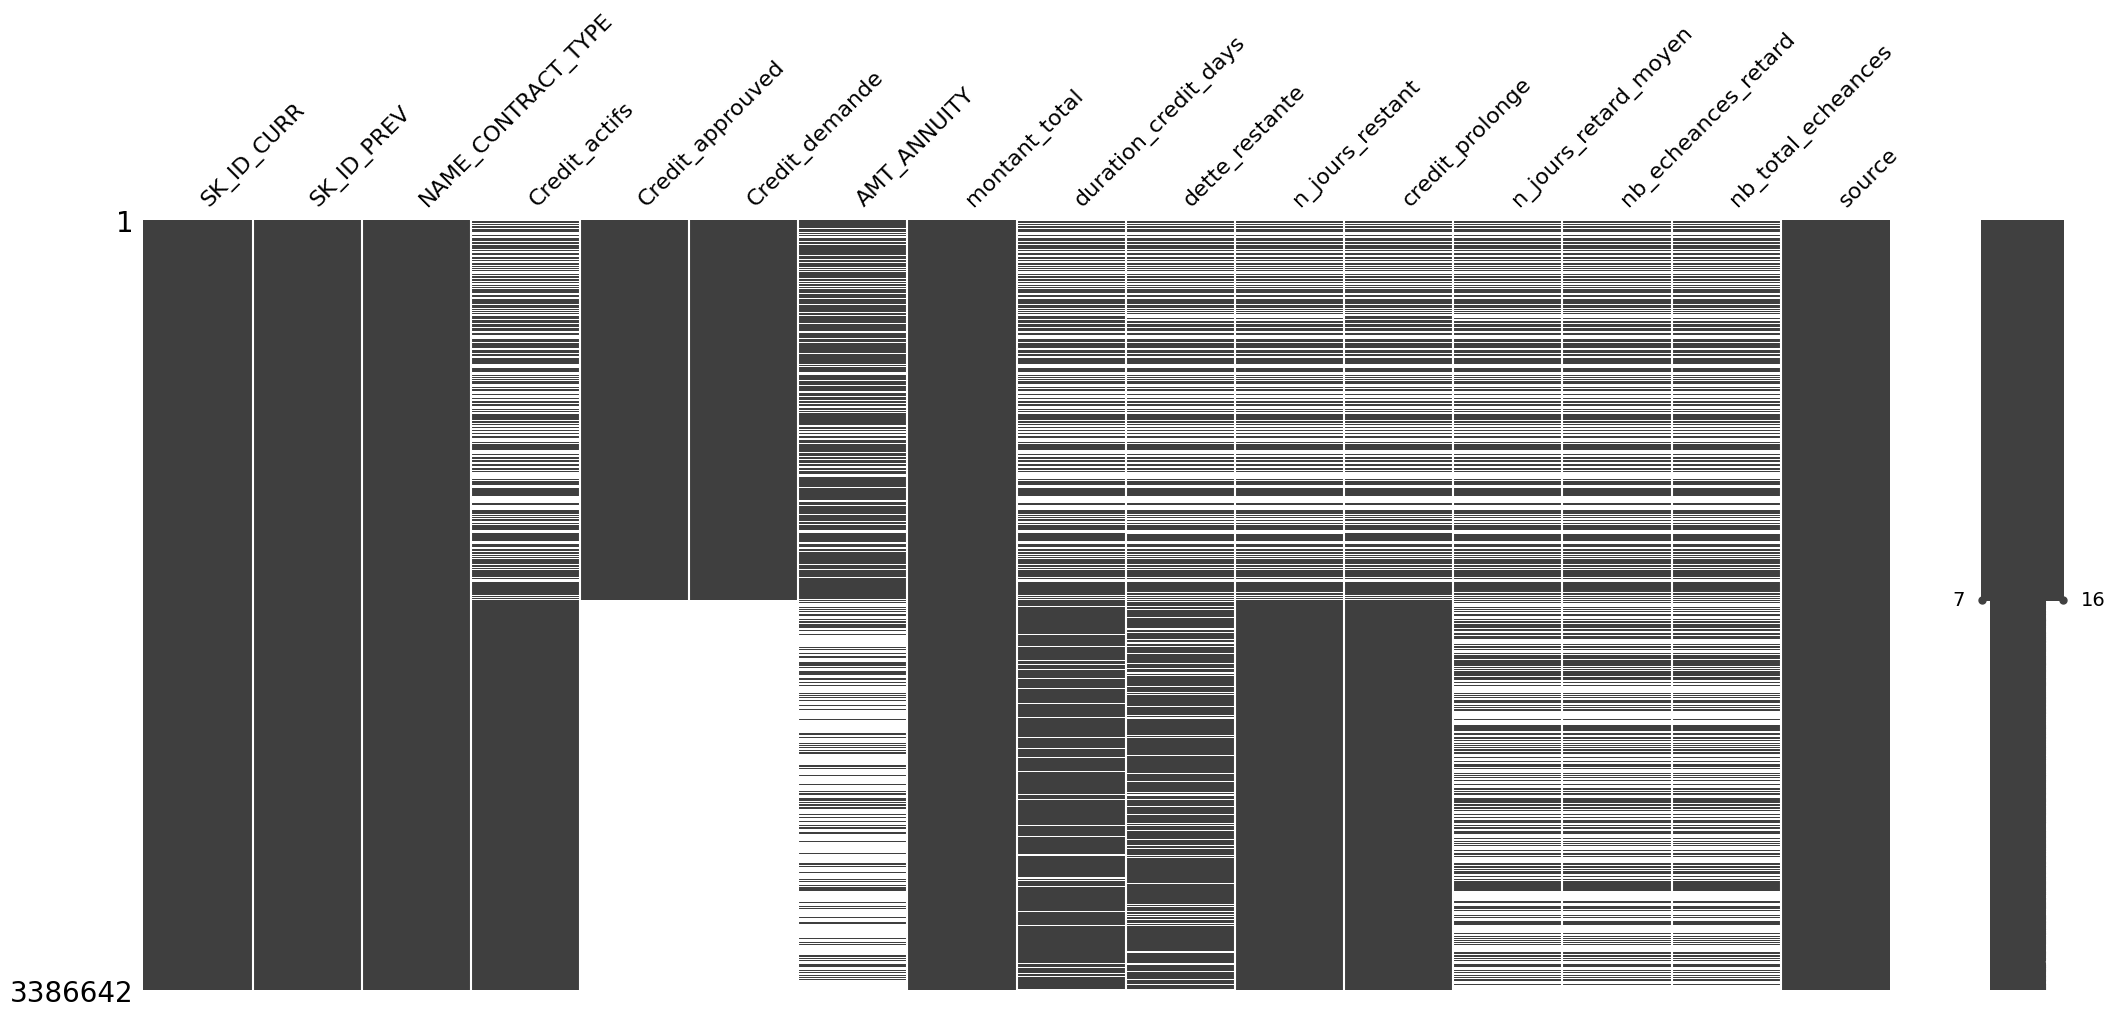

In [67]:
# Concaténation des données internes et externes
feat_all = pd.concat([feat_int, feat_ext], axis=0)

# Viusalisation du taux de valeurs manquantes
msno.matrix(feat_all)

In [68]:
# Appel de la fonction
missing_values_table(feat_all)

La dataframe contient 16 colonnes.
Il y a 12 colonnes qui possèdent des valeurs manquantes.


Missing Values  % of Total Values
Credit_approuved             1716428               50.7
Credit_demande               1716428               50.7
n_jours_retard_moyen         1653454               48.8
nb_echeances_retard          1653383               48.8
nb_total_echeances           1653383               48.8
AMT_ANNUITY                  1608190               47.5
dette_restante                968978               28.6
duration_credit_days          778618               23.0
n_jours_restant               706767               20.9
credit_prolonge               673065               19.9
Credit_actifs                 672671               19.9
montant_total                     14                0.0

Lorsque les crédits internes et externes sont analysés ensemble, on remarque que 12 variables sur les 16 contiennent des valeurs manquantes et que pour 7 d'entre elles, le taux de valeur manquante dépasse 25%. Comme précédement, cette analyse peut être affinée en examinant la répartition des valeurs manquantes en fonction du status du crédit, c'est à dire selon s'il a été accordé ou non.

Il serait également intéressant d'étudier les taux de valeur manquante à l'échelle du client. En effet, un même client pouvant posséder plus de un crédit, la présence de valeurs renseignées pour un précédent crédit qui serait absente pour un autre crédit peut compenser les manques observés. L'aggrégation des données par client permettra donc de dilluer les information manquantes et d'obtenir un taux de valeur manquantes atténué. Pour cela, on peut calculer pour chaque variable la proportion de clients n’ayant aucune valeur disponible sur l’ensemble de leurs précédentes demandes de crédit. Cela permettra de distinguer les variables réellement problématiques (absence totale d’information par client) de celles où les manques ne concernent que certains crédits de façon ponctuelle.

In [69]:
# Définition des variables à analyser
variables = ['Credit_actifs', 'duration_credit_days', 'AMT_ANNUITY', 'credit_prolonge', 
             'dette_restante', 'n_jours_restant', 'n_jours_retard_moyen',
             'nb_echeances_retard', 'nb_total_echeances']

# Calcul du nombre de clients uniques
total_clients = feat_all["SK_ID_CURR"].nunique()

# Initialisation de la liste de résultats
result = []

# Pour chaque variable
for var in variables:
    
    # Identification des clients qui ont uniquement des NaN sur cette variable
    clients_all_nan = (
        feat_all.groupby("SK_ID_CURR")[var]
        .apply(lambda x: x.isna().all())
    )
    
    # Calcul du nombre de clients ayant que des nan pour la variable
    nb_clients_all_nan = clients_all_nan.sum()
    
    # Calcul de la proportion de clients ayant que des nan pour la variable
    pct_clients_all_nan = nb_clients_all_nan / total_clients * 100
    
    # Ajout des résultats dans la liste de résultats
    result.append({
        "variable": var,
        "nb_clients_all_nan": nb_clients_all_nan,
        "pct_clients_all_nan": pct_clients_all_nan
    })

# Conversion de la liste de résultats en dataframe
df_result = pd.DataFrame(result)

# Affichage des résultats
print(df_result)

               variable  nb_clients_all_nan  pct_clients_all_nan
0         Credit_actifs                 146             0.041292
1  duration_credit_days                 363             0.102665
2           AMT_ANNUITY               11193             3.165647
3       credit_prolonge                 171             0.048363
4        dette_restante                 970             0.274339
5       n_jours_restant                 253             0.071554
6  n_jours_retard_moyen               11480             3.246818
7   nb_echeances_retard               11476             3.245686
8    nb_total_echeances               11476             3.245686


Cette nouvelle analyse montre que le taux de valeur manquantes est bien réduit lorsqu'on oriente le calcul des valeurs manquantes à l'échelle du client.

## Aggregation des données

Maintenant que les caractéristiques relatives aux crédits internes et aux crédits externes ont été extraites et/ou construites, ces diffrentes données vont être concaténées avant d'être aggrégées par demande de crédit. Pour certaines variables, différentes fonctions d’agrégation (minimum, maximum, somme, etc.) seront utilisées afin de capturer plusieurs aspects de l’information. La table ci dessous recapitule les différentes opérations effectuées.  

**Notes**
Les variables affichées en rouges seront supprimées après utilisation pour le calcul des ratios

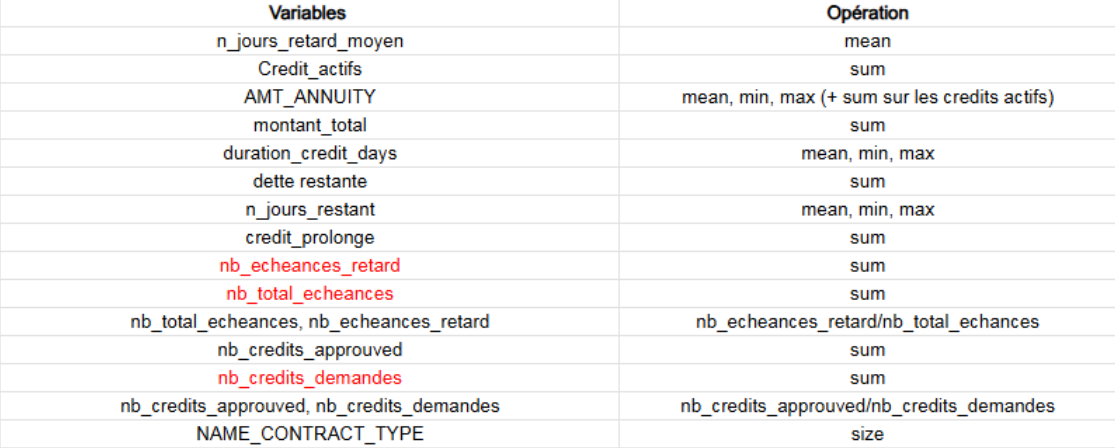

In [70]:
# Affichage du tableau de variables utilisées
display(Image(filename='../Images/Tableau2.png'))

In [71]:
def aggregation_credit_int_ext(application, feat_int, feat_ext):
    
    """
    Agrège et enrichit les informations de crédits internes et externes pour chaque client.

    Cette fonction combine les données de crédits internes et externes, 
    calcule des agrégations par client (SK_ID_CURR), génère des ratios financiers, 
    et fusionne ces informations avec la table principale des applications.

    Paramètres
        - application (pd.DataFrame): Table principale des applications clients, contenant au minimum la colonne 'SK_ID_CURR'.
        - feat_int (pd.DataFrame): Données des crédits internes, avec colonnes telles que 
        'Credit_demande', 'Credit_approuved', 'Credit_actifs', 'credit_prolonge',
        'n_jours_retard_moyen', 'AMT_ANNUITY', 'montant_total', 'duration_credit_days',
        'dette_restante', 'n_jours_restant', 'nb_total_echeances', 'nb_echeances_retard', 'NAME_CONTRACT_TYPE'.
        - feat_ext (pd.DataFrame): Données des crédits externes, avec les mêmes colonnes que `feat_int`.

    Sortie
        pd.DataFrame : Table application enrichie avec les informations agrégées suivantes par client :
            - Agrégations numériques : moyenne, somme, min, max pour les montants et durées.
            - Ratios financiers: 
                - ratio_echeance_retard: proportion d'échéances en retard.
                - ratio_approuve_demande: proportion de crédits approuvés sur crédits demandés.
            - Montant mensuel total des crédits actifs (montant_mensuel_actif).
            - Nombre de crédits par type (NAME_CONTRACT_TYPE).

    """
    
    #--------------------------------------------------------------------------
    # Aggregation
    #--------------------------------------------------------------------------
    
    # Concaténation des crédits internes et externes
    feat_all = pd.concat([feat_int, feat_ext], axis=0)
    
    # Conversion des type de certaines variables
    feat_all['Credit_demande'] = pd.to_numeric(feat_all['Credit_demande'], errors='coerce')
    feat_all['Credit_approuved'] = pd.to_numeric(feat_all['Credit_approuved'], errors='coerce')
    feat_all['Credit_actifs'] = pd.to_numeric(feat_all['Credit_actifs'], errors='coerce')
    feat_all['credit_prolonge'] = pd.to_numeric(feat_all['credit_prolonge'], errors='coerce')

    # Aggrégation des données par clients 
    agg = (
        feat_all.groupby("SK_ID_CURR")
        .agg(
            n_jours_retard_moyen=("n_jours_retard_moyen", "mean"),
            n_contrat_actif=("Credit_actifs", "sum"),
            montant_mensuel_min=("AMT_ANNUITY", "min"),
            montant_mensuel_max=("AMT_ANNUITY", "max"),
            montant_mensuel_mean=("AMT_ANNUITY", "mean"),
            montant_total=("montant_total", "sum"),
            n_jours_credit_mean=("duration_credit_days", "mean"),
            n_jours_credit_min=("duration_credit_days", "min"),
            n_jours_credit_max=("duration_credit_days", "max"),
            montant_dette_restante=("dette_restante", "sum"),
            n_jours_restant_mean=("n_jours_restant", "mean"),
            n_jours_restant_min=("n_jours_restant", "min"),
            n_jours_restant_max=("n_jours_restant", "max"),
            n_prolongation_credit=("credit_prolonge", "sum"),
            n_total_echeance=('nb_total_echeances', 'sum'),
            n_echeance_retard=('nb_echeances_retard', 'sum'),
            nb_credit_demandes=('Credit_demande', 'sum'),
            nb_credit_approuves=('Credit_approuved', 'sum')
        )
        .reset_index()
    )
    
    #--------------------------------------------------------------------------
    # Calcul des ratios
    #--------------------------------------------------------------------------
    
    # Calcul du ratio d'échéances en retard
    agg['ratio_echeance_retard'] = agg.apply(
        lambda row: row['n_echeance_retard'] / row['n_total_echeance'] if row['n_total_echeance'] > 0 else -1,
        axis=1)
    
    # Suppression des colonnes intermédiaires
    agg = agg.drop(['n_total_echeance', 'n_echeance_retard'], axis=1)
    
    # Calcul du ratio d'échéances en retard
    agg['ratio_approuve_demande'] = agg.apply(
        lambda row: row['nb_credit_approuves'] / row['nb_credit_demandes'] if row['nb_credit_demandes'] > 0 else -1,
        axis=1)
    
    # Suppression des colonnes intermédiaires
    agg = agg.drop(['nb_credit_demandes'], axis=1)
    
    #--------------------------------------------------------------------------
    # Calcul des montants mensuels des crédits actifs
    #--------------------------------------------------------------------------
    
    # Calcul du montant mensuel des crédits actifs
    montant_mensuel_actif = (
        feat_all[feat_all["Credit_actifs"] == 1]
        .groupby("SK_ID_CURR")["AMT_ANNUITY"]
        .sum()
        .reset_index()
        .rename(columns={"AMT_ANNUITY": "montant_mensuel_actif"})
    )
    
    #--------------------------------------------------------------------------
    # Calcul du nombre de crédits par type
    #--------------------------------------------------------------------------
    
    # Calcul du nombre de contrat par type
    credits_n_type = (
        feat_all
        .groupby(["SK_ID_CURR", "NAME_CONTRACT_TYPE"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )
    
    #--------------------------------------------------------------------------
    # Fusion des données
    #--------------------------------------------------------------------------
    
    # Fusion des données aggrégées entres elles
    agg = agg.merge(montant_mensuel_actif, on="SK_ID_CURR", how="left")
    agg = agg.merge(credits_n_type, on="SK_ID_CURR", how="left")
    
    # Fusion avec la table d'application
    application_enrichi = application.merge(agg, on="SK_ID_CURR", how="left")
    
    return application_enrichi


In [72]:
# Appel de la fonction d'aggrégation
App_train_enrichi = aggregation_credit_int_ext(App_train_2, feat_int, feat_ext)

# Sauvegarde de la table de données
App_train_enrichi.to_csv("../Output/Data_clients/App_train_enrichi.csv", index=False)

In [73]:
# Vérification du nombre d'observation
App_train_enrichi.shape

(246006, 97)

Les étapes de concaténation des caractéristiques relatives aux crédits internes et externes, d'aggrégation des données selon l'ID de la demande et de jointure sur la table principale se sont bien déroulées et n'ont pas altéré le nombre d'observations de la table principale. 
Une fonction compatible avec les pipeline scikit learn pourrait être définie afin d'intégrer cette étape dans une pipeline. Cela permettrait de pouvoir reconstuire la table de facon cohérente si les tables de données étaient mise ajour avec de nouveaux clients.

In [74]:
class EnrichCreditFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, data_prev_app, data_installments_pymnts,
                 data_bureau, data_bureau_balance):
        self.data_prev_app = data_prev_app
        self.data_installments_pymnts = data_installments_pymnts
        self.data_bureau = data_bureau
        self.data_bureau_balance = data_bureau_balance

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feat_int = feat_from_int_credit(self.data_prev_app, self.data_installments_pymnts)
        feat_ext = feat_from_ext_credit(self.data_bureau, self.data_bureau_balance)
        X_enrichi = aggregation_credit_int_ext(X, feat_int, feat_ext)
        return X_enrichi

#  Analyse de la table

## Valeur manquantes

<Axes: >

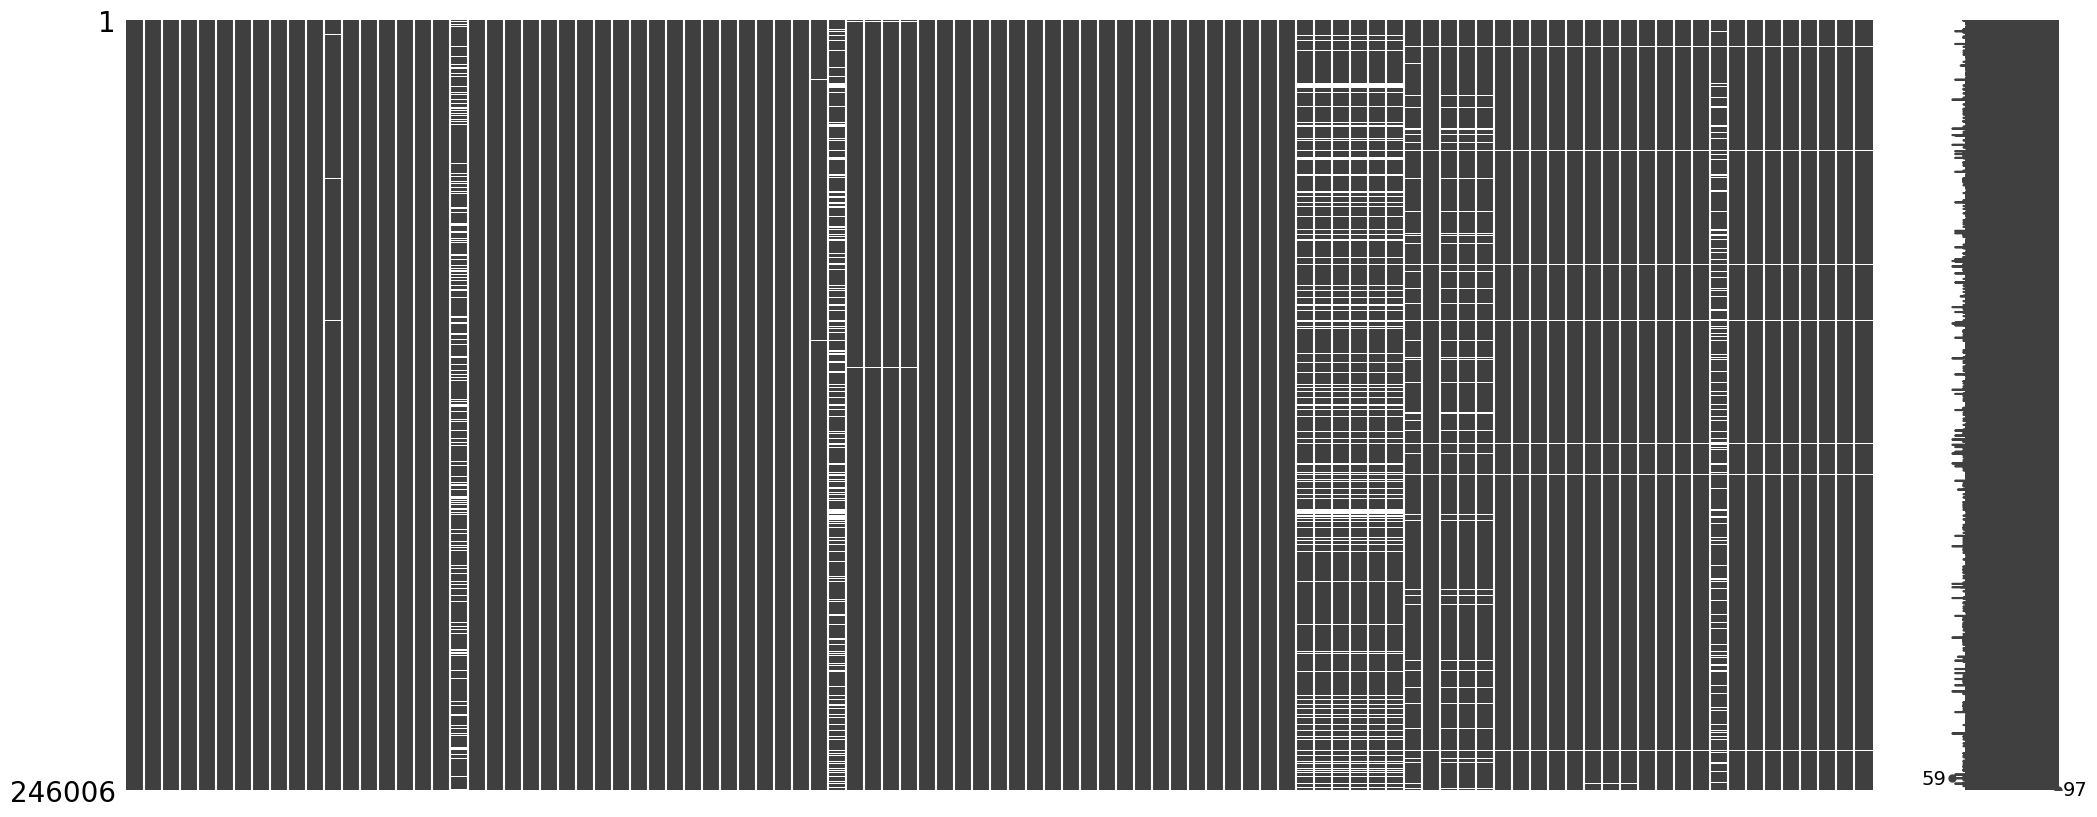

In [75]:
# Viusalisation du taux de valeurs manquantes
msno.matrix(App_train_enrichi)

La concaténation de l'ensemble des crédits internes et externes puis l'aggrégations des données a permis de réduire le taux de valeurs manquantes des variables constuites et ajoutées à l'étape précédente dans la table principale puisque le plus fort taux de valeur manquante détéctées pour ces variables est de 4.5%. Les valeurs manquantes restantes seront imputées selon la stratégie discutées précédement.

## Distribution des variables explicatives en fonction de la variable cible

In [76]:
def boxplots_target_features(df, target_col, features, save_name, ncols=2, figsize_per_plot=(6,4)):
    """
    Affiche des boxplots des variables numériques en fonction de la variable cible.

    Paramètres:
        df (pandas DataFrame): dataframe contenant les données
        target_col (str): nom de la variable cible 
        features (list of str): noms des variables à ploter
        save_name (str): Nom de la sauvegarde
        ncols (int): nombre de colonnes dans la grille de graphiques (par défaut 2)
        figsize_per_plot (tuple): taille (largeur, hauteur) par graphique
    
    """
    
    # Calcul du nombre de plot à construire
    nplots = len(features)
    
    # Calcul du nombre de ligne dans la grille en fonction du nombre de colonnes demandé
    nrows = math.ceil(nplots / ncols)
    
    # Initialisation de la figure
    plt.figure(figsize=(figsize_per_plot[0]*ncols, figsize_per_plot[1]*nrows))
    
    # Pour chaque variable
    for i, feat in enumerate(features, 1):
        
        plt.subplot(nrows, ncols, i)
        sns.boxplot(x=target_col, y=feat, data=df, showfliers=False)
        plt.title(f"{feat} vs {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    # Sauvegarde de la figure
    plt.savefig(f'../Output/Analyses_bivariées/{save_name}.png', format='png')

    # Affichage de la figure
    plt.show()



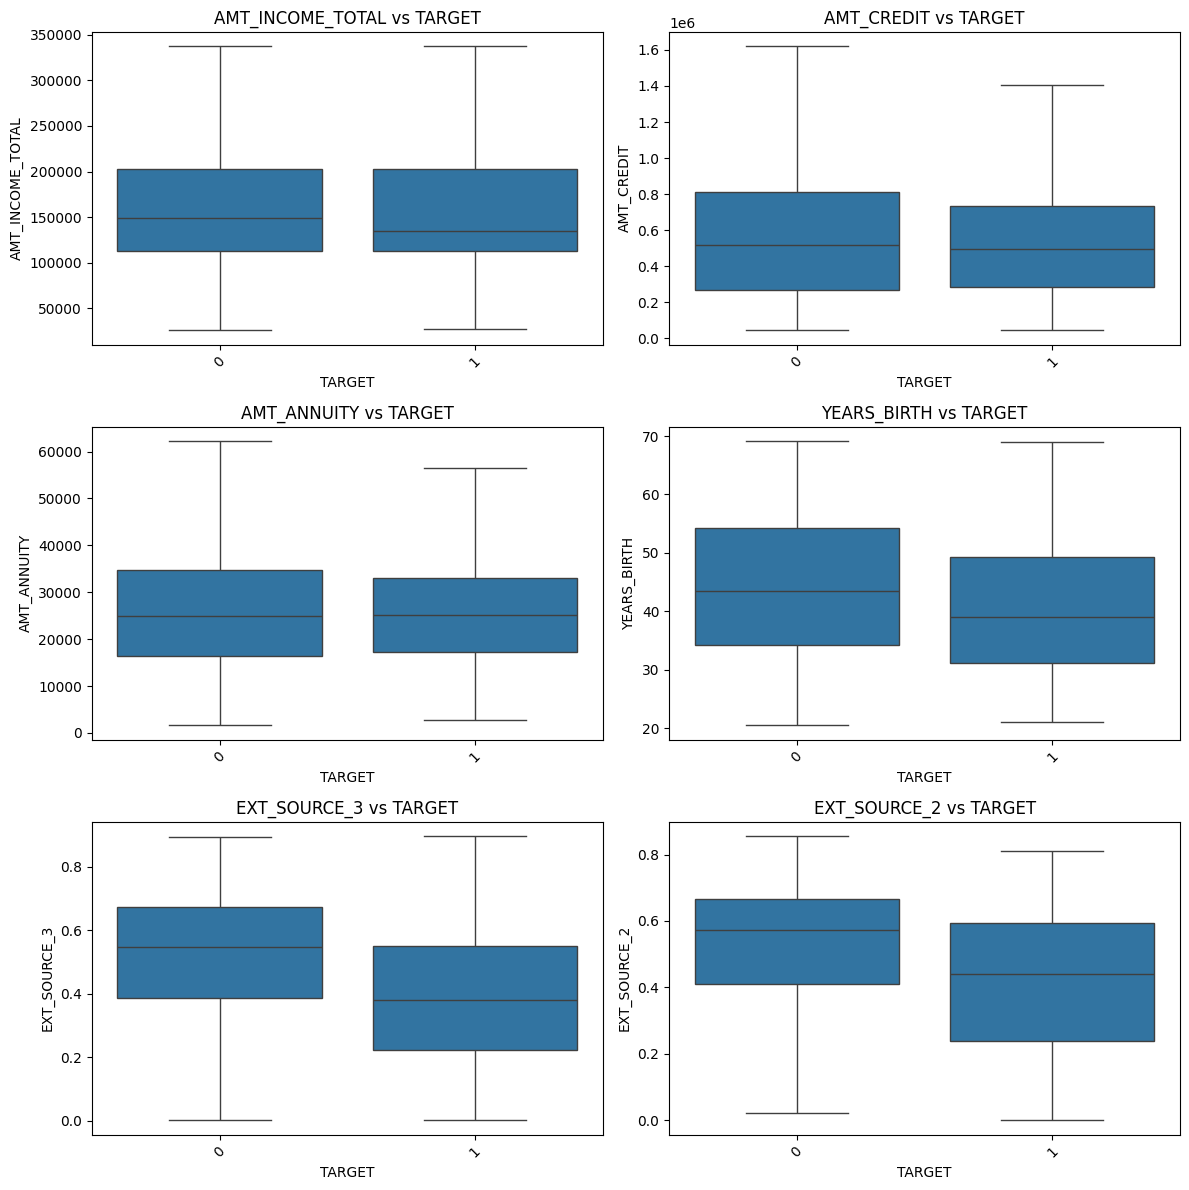

In [77]:
# Features
features = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY', 'YEARS_BIRTH',
           'EXT_SOURCE_3', 'EXT_SOURCE_2']

# Appel de la fonction
boxplots_target_features(df=App_train_enrichi, target_col='TARGET', features=features, save_name="Distribution_variables_numériques_vs_cible_1", ncols=2)

L'analyse de la distribution de quelques variables numériques en fonction de la variable cible met en évidence des différences notables entre les demandes associées à un risque élevé de défaut de paiement et celles qui sont associées à un risque faible. On observe par exemple que les demandes  présentant un risque élevé sont globalement associées à des demandeurs plus jeunes alors que les profils plus âgés semble davantage liés à un risque faible. L'écart entre les distribution des deux classes est plus marqué lorsqu'on s'intéresse aux variables correpondant à un score de fiabilité fourni dans la table de donnée. Ces scores apparaissent donc comme des indicateurs qui auront sans doute une forte capacité à discriminer les deux types de demandes. Il serait toutefois important de discuter avec la société pour vérifier que ces variables seront effectivement disponibles pour les futures demandes et qu'elles peuvent donc être utilisées dans la phase de modélisation. Au contraire, les distributions associées aux revenus et aux montant du crédit demandé sont plus similaire entre les deux classes suggérant que ces variables seules possèdent une capacité à discriminer les deux classes plus limitée.

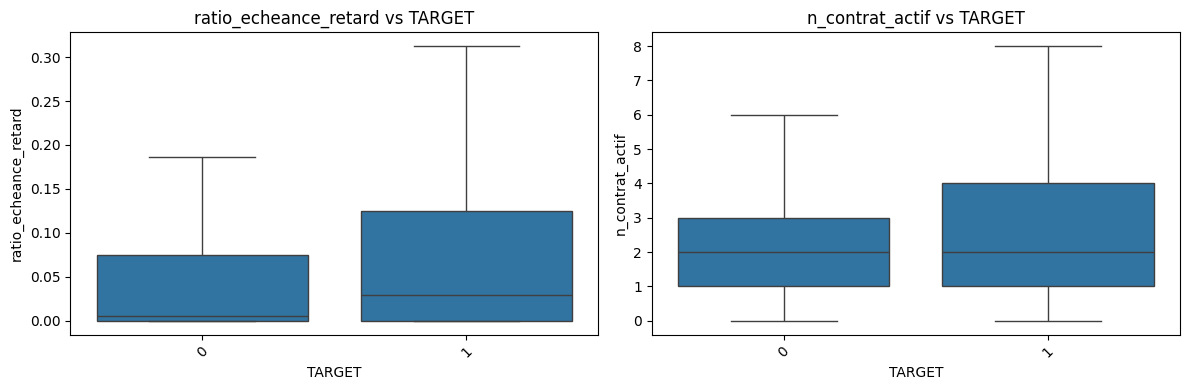

In [78]:
# Features
features = ['ratio_echeance_retard','n_contrat_actif']

# Appel de la fonction
boxplots_target_features(df=App_train_enrichi, target_col='TARGET', features=features, save_name="Distribution_variables_numériques_vs_cible_2", ncols=2)

Parmis les variables crées pour enrichir la table de données principale, on note que le ratio d'échéances en retard pourrait également s'avérer discriminant pour classer les demandes de crédits puisqu'on note des ratio globalement plus élevés parmis les demandes associées à un risque élevée de défaut de paiment comparé à celles associées à un risque faible. En ce qui concerne le nombre de crédits actifs la médiane apparait similaire entre les deux catégories, mais la distribution est plus élargie parmis les demandes à risque avec un troisième quartile qui est plus élevé pour cette classe. Cela suggère que même si la majorité des demandeurs ont un nombre comparable de crédits en cours, une proportion plus importante d'individus associé à un risque élevé détient un nombre de crédits actifs supérieur ce qui pourrait augmenter leur probabilité de défaut de paiment.

In [79]:
def plot_categorical_vars_pct(df, target_col, cat_vars, save_name, ncols=2, figsize_per_plot=(6,4), min_pct_annot=5):
    """
    Affiche des barplots empilés en % des variables catégorielles selon la variable cible,

    Paramètres:
        df (pandas DataFrame): dataframe contenant les données
        target_col (str): nom de la variable cible 
        cat_vars (list of str): noms des variables catégorielles à prendre en compte 
        save_name (str): Nom de la sauvegarde
        ncols (int): nombre de colonnes dans la grille de graphiques (par défaut 2)
        figsize_per_plot (tuple): taille (largeur, hauteur) par graphique (par défaut (6,4))
        min_pct_annot (int): pourcentage minimum requis pour que celui ci soit annoté sur le graphique
    
    """
    
    # Calcul du nombre de plot à construire
    nplots = len(cat_vars)
    
    # Calcul du nombre de lignes dans la grille en fonction du nombre de colonnes demandées
    nrows = math.ceil(nplots / ncols)
    
    # Initialisation de la figure
    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize_per_plot[0]*ncols + 2, figsize_per_plot[1]*nrows))
    
    # Aplatissement de l'objet axs
    axs = axs.flatten() if nplots > 1 else [axs]
    
    # Pour chaque variable
    for i, var in enumerate(cat_vars):
        
        # Attribution de la position de la figure
        ax = axs[i]

        # Calcul d'une table de contingence
        cross_tab = pd.crosstab(df[var], df[target_col], normalize='index') * 100

        # Construction du barplot empilé
        plot_ax = cross_tab.plot(kind='bar', stacked=True, ax=ax, legend=False)

        # Ajout de titre et labels
        ax.set_title(f"{var} selon {target_col} (%)")
        ax.set_ylabel("Pourcentage (%)")
        ax.set_xlabel(var)

        # Ajout d'annotations en %
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            if height >= min_pct_annot:
                ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=9, color='white')

        # Ajout d'une légende à l'extérieur à droite 
        handles, labels = plot_ax.get_legend_handles_labels()
        ax.legend(
            handles, labels,
            title=target_col,
            loc='upper left',
            bbox_to_anchor=(1.02, 1),
            fontsize=10,
            title_fontsize=11,
            frameon=True,
            borderpad=1
        )

    # Suppression des axes vides s'il y en a
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Ajustement de la figure
    plt.tight_layout()

    # Sauvegarde de la figure
    plt.savefig(f'../Output/Analyses_bivariées/{save_name}.png', format='png')    
    
    # Affichage de la figure
    plt.show()


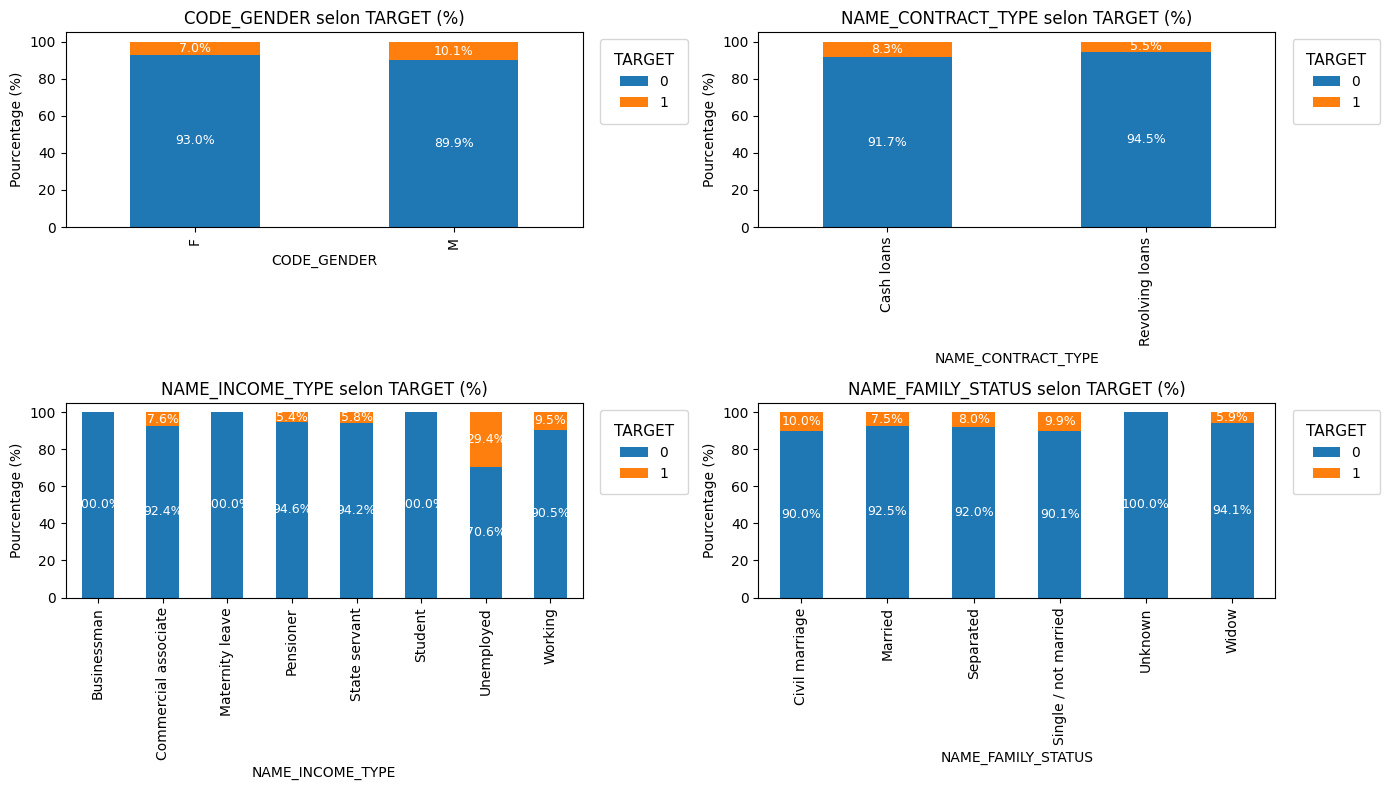

In [80]:
# Appel de la fonction
plot_categorical_vars_pct(df=App_train_enrichi, target_col='TARGET', 
                          cat_vars=['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS'],
                         save_name="Distribution_variables_catégorielles_vs_cible")

L'analyse de la distribution des variables catégorielles met également en évidence des différences entre les demandes associées à un risque élevé de défaut de paiement et celles présentant un risque plus faible. En particulier, on peut observer un plus fort poucentage d'hommes parmis les demandes à risque comparé aux demandes avec un risque plus faible. On note également une légère différence entre les types de contrat demandé, avec notamment les contrat de type cash qui sont davantage associés aux demande risquées. Concernant le type de revenu, on remarque que les demandes associées à un risque élevé repose plus souvent sur des revenus de type salaire ou concernent des personnes sans emploi, tandis que les revenus associés à un statut d’étudiant ou d’indépendant apparaissent exclusivement dans les demandes à risque faible. Enfin, s'agissant du statut familiale, les demande associées a un risque élevé concernent davantage de personnes célibataires, non mariés ou en union civil et moins de personnes marriées officiellement ou veuves.

A noter que ces analyses sont issues d'interprétation graphique et que des tests statistiques pourraient compléter ces observations. On pourrait notament faire un test du Khi2 d'indépendance.

## Corrélation entre les variables explicatives

In [81]:
# Calcul de la matrice de corrélation
corr_matrix = App_train_enrichi.corr(numeric_only=True)

# Masquage de la moitié inférieure
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_masked = corr_matrix.mask(mask) 

# Construction d'une heatmap interactive
fig = px.imshow(
    corr_masked,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    color_continuous_scale='RdBu_r',
    zmin=-1,
    zmax=1,
    labels=dict(x="Variable 1", y="Variable 2", color="Corrélation")
)

# Ajout du texte
fig.update_traces(
    hovertemplate="Variable 1 : %{y}<br>Variable 2 : %{x}<br>Corrélation : %{z:.2f}<extra></extra>"
)

# Ajustement de la figure
fig.update_layout(width=1000, height=1000)

# Sauvegarde de la figure
fig.write_html(f'../Output/Corrélation/Corrélations.html')

# Affichage de la figure
fig.show()

C:\Users\33647\anaconda3\Lib\site-packages\kaleido\_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [82]:
# Triangulation de la matrice
corr_matrix = corr_matrix.where(mask)

# Transformation du format de la matrice
high_corr = corr_matrix.stack().reset_index()

# Changement des noms des colonnes
high_corr.columns = ["Var1", "Var2", "Correlation"]

# Filtre des couples de variables avec une corrélation > 0.8
high_corr = high_corr[high_corr["Correlation"].abs() > 0.8]

# Affichage des couples de variables avec une corrélation > 0.8
print(high_corr)

                            Var1                         Var2  Correlation
186                 CNT_CHILDREN              CNT_FAM_MEMBERS     0.878458
339                   AMT_CREDIT              AMT_GOODS_PRICE     0.987002
1428        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY     0.951187
1690  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION     0.863514
1876      REG_CITY_NOT_WORK_CITY      LIVE_CITY_NOT_WORK_CITY     0.826856
2110    OBS_30_CNT_SOCIAL_CIRCLE     OBS_60_CNT_SOCIAL_CIRCLE     0.998514
2166    DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE     0.859042
3621       n_prolongation_credit          nb_credit_approuves     0.919946


La heatmap représentant la matrice de corrélation indique qu'un certain nombre de variables présentent une forte corrélation. En particulier les couples de variables suivant présentent un coefficient de corrélation d'au moins 80%:
- AMT_GOOD_PRICE et AMT_CREDIT
- CNT_FAM_MEMBERS et CNT_CHILDREN
- REGION_RATING_CLIENT et REGION_RATING_CLIENT_W_CITY
- REG_REGION_NOT_WORK_REGION et LIVE_REGION_NOT_WORK_REGION
- REG_CITY_NOT_WORK_CITY et LIVE_CITY_NOT_WORK_CITY
- OBS_30_CNT_SOCIAL_CIRCLE et OBS_60_CNT_SOCIAL_CIRCLE
- DEF_30_CNT_SOCIAL_CIRCLE et DEF_60_CNT_SOCIAL_CIRCLE
- montant_mensuel_max et montant_mensuel_mean
- n_prolongation_credit et nb_credit_approuves

Pour la phase de modélisation, on ne gardera qu'une seule des deux variables pour chacun de ces couples de variable fortement corrélées. On conservera celle qui a le plus de sens métier de façon à garantir une bonne interprétation des résultats. Pour rester dans une logique de cohérence entre les traitements effectués sur les données d'entrainement et de tests, on utilisera une autre classe de fonctions compatibles avec les pipelines scikit learn.

In [83]:
# Définition des variables à supprimer
Var_with_high_corr= ['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY',
                    'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE', 'montant_mensuel_max', 'n_prolongation_credit']

## Définition d'une deuxième fonction de nettoyage

In [84]:
class cleaning_2(BaseEstimator, TransformerMixin):
    """
    Classe de prétraitement pour nettoyer la table de donnée principale enrichie

    Cette classe supprime une variable prédéfinie pour chaque couple de variables 
    avec un coefficient de corrélation trop élevé.

    Paramètres
        drop_cols (list of str): Liste de colonnes à supprimer systématiquement.
        verbose (bool): Si True, affiche des informations sur les colonnes supprimées et les remplacements effectués.
    """

    def __init__(self, drop_cols=None, verbose=False):
        
        # Initialisation des paramètres de nettoyage
        self.drop_cols = drop_cols if drop_cols is not None else []
        self.verbose = verbose
        self.cols_to_keep_ = None

    def fit(self, X, y=None):
        """
        Apprend les colonnes à conserver.
        """
        # Conversion de la table en dataframe
        X_df = pd.DataFrame(X)

        # Conservation de toutes les colonnes sauf celles à drop
        self.cols_to_keep_ = [col for col in X_df.columns if col not in self.drop_cols]

        # Si demandé, affichage
        if self.verbose:
            dropped_col = [col for col in self.drop_cols if col in X_df.columns]
            if dropped_col:
                print(f"\nColonnes supprimées : {len(dropped_col)}")
                print(dropped_col)
            else:
                print("\nAucune colonne supprimée")
        return self

    def transform(self, X):
        """
        Applique le nettoyage aux données.
        """
        X_df = pd.DataFrame(X)

        # Conservation des colonnes gardées au fit
        return X_df[self.cols_to_keep_].copy()


# Sauvegarde des tables finales

In [85]:
# Ajout d'une variable target dans la table qui sera utilisée pour la partie data drift
Application_test['TARGET'] = np.nan

# Application de la première fonction de nettoyage sur les tables de données de test
App_test_2 = cleaner.transform(App_test)
App_drift_2 = cleaner.transform(Application_test)

# Appel de la fonction d'aggrgation
App_train_enrichi = aggregation_credit_int_ext(App_train_2, feat_int, feat_ext)
App_test_enrichi = aggregation_credit_int_ext(App_test_2, feat_int, feat_ext)
App_drift_enrichi = aggregation_credit_int_ext(App_drift_2, feat_int, feat_ext)

# Initialisation de la deuxième fonction de nettoyage
cleaner_2 = cleaning_2(verbose=True, drop_cols =  Var_with_high_corr)

# Application de la deuxième fonction de nettoyage sur les trois tables de données
App_train_final = cleaner_2.fit_transform(App_train_enrichi)
App_test_final = cleaner_2.transform(App_test_enrichi)
App_drift_final = cleaner_2.transform(App_drift_enrichi)

# Exctraction de la date pour nommer les sauvegardes en fonction de la date
date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Sauvegardes des trois tables de données
App_train_final.to_csv(f"../Output/Data_clients/App_train_final_{date_str}.csv", index=False)
App_test_final.to_csv(f"../Output/Data_clients/App_test_final_{date_str}.csv", index=False)
App_drift_final.to_csv(f"../Output/Data_clients/App_drift_final_{date_str}.csv", index=False)

 11231 valeurs [365243] remplacées par NaN dans 'DAYS_EMPLOYED'
 1 valeurs > 10000000 remplacées par NaN dans 'AMT_INCOME_TOTAL'
 Conversion jours -> années sur : ['DAYS_BIRTH']
 Conversion jours -> valeur absolue sur : ['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
 Conversion jours -> valeur absolue sur : ['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
 Conversion jours -> valeur absolue sur : ['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
 Filtrage sur 'CODE_GENDER': 2 lignes supprimées
 9274 valeurs [365243] remplacées par NaN dans 'DAYS_EMPLOYED'
 Conversion jours -> années sur : ['DAYS_BIRTH']
 Conversion jours -> valeur absolue sur : ['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
 Conversion jours -> valeur absolue sur : ['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
 Conversion jours -> valeur absolue sur : ['DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
 Filtrage sur 'CODE_GENDER': 0 lignes supprimées

Colonnes su

# Conclusions

L'objectif du projet est de développer un outil de scoring capable d'estimer la probabilité qu'un client rembourse son crédit. Pour cela, plusieurs tables de données nous ont été fournies: la table de données principale contenant des informations relatives aux demandes de crédits ainsi que plusieurs tables supplémentaires fournissant des informations relatives aux précédents crédits. Certaines tables étaient spécifiques aux crédits internes à la soociété tandis que d'autres étaient spécifiques aux crédits externes.

La table de données principale a été découpée en jeu de données d'entrainement et en jeu de données test pour que l'analyse et les différentes actions de nettoyages mises en place ne soient pas biaisée par des données qui ne seront pas vues par les modèles d'apprentissage automatique. L'analyse de la variable cible ayant révélé un fort déséquilibre des deux classes, le découpage des données s'est effectué en utilisant une stratégie de stratification permettant de conserver des proportions similaires dans les deux sous ensemble de données obtenus. Les différentes tables ont ensuite été explorées.

La table principale a été analysée dans le détail et différentes étapes de nettoyage ont été mises en place puis appliquées aux deux sous ensemble de données. L'exploration des autres tables a permis d'identifier des variables pertinentes à ajouter à la table principale et a permis de construire de nouvelles variables permettant d'enrichir le jeu de données de la table principale. Les variables (extraites et construites) rrelatives aux crédits internes et externes ont été traitées séparément, puis concaténées et agrégées par client avant d’être ajoutéés à la table principale.

La table enrichie obtenu a ensuite été analysée pour étudier les relations entre les variables explicatives et la variable cible. Enfin l'analyse de la corrélation entre les variables explicatives a permis de supprimer certaines variables fortement corrélées.

Ces différentes étapes ont permis de construire le jeu de données finale prêt à être utilisé comme entrée pour le modèle de scoring.